In [237]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../Coding')
from itertools import combinations
from Algorithms import pattern_count
import time
from Algorithms import NewAlgRanking_19_20211216 as newalg
from Algorithms import NaiveAlgRanking_4_20211213 as naivealg
import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import NewAlgRanking_definition2_13_20220509 as newalg2
from Algorithms import NaiveAlgRanking_definition2_5_20220506 as naivealg2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 15
f_size = (14, 8)

In [251]:
def string2num(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                p.append(int(item))
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        p.append(int(item))
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
    else:
        print(tuples_idx)
        for id in tuples_idx:
            print(id, shap_values.values[id][-1])
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        output_file.write(str(avg))
        print("group {} size {}".format(group, len(tuples_idx)))
        print(avg)

def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

def check_another_group_global_bounds(g, data, selected_attributes, thc):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    if size_topk < Lowerbounds[0]:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True


def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    lowerbound = alpha * size_whole_data * k / len(data)
    print(size_whole_data, size_topk, lowerbound)
    if size_topk < lowerbound:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True

# student data


In [226]:

all_attributes = ['school_C', 'sex_C', 'age_C', 'address_C', 'famsize_C', 'Pstatus_C', 'Medu_C',
                  'Fedu_C', 'Mjob_C', 'Fjob_C', 'reason_C', 'guardian_C', 'traveltime_C', 'studytime_C',
                  'failures_C', 'schoolsup_C', 'famsup_C', 'paid_C', 'activities_C', 'nursery_C', 'higher_C',
                  'internet_C', 'romantic_C', 'famrel_C', 'freetime_C', 'goout_C', 'Dalc_C', 'Walc_C',
                  'health_C', 'absences_C', 'G1_C', 'G2_C', 'G3_C']

original_data_file = r"../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)


## 16att

In [248]:
selected_attributes = all_attributes[:16]

k = 50
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [228]:
selected_attributes = \
    ['school_C', 'sex_C', 'age_C', 'address_C', 'famsize_C', 'Pstatus_C',
     'Medu_C', 'Fedu_C', 'Mjob_C', 'Fjob_C', 'reason_C',
     'health_C', 'absences_C', 'G1_C', 'G2_C', 'G3_C']

alpha = 0.8
k = 50
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 1.9563829898834229
finish kmin
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, 2, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2]
[-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 0, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, 

In [232]:

x = ranked_data[all_attributes]
y = ranked_data['rank']

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

school_C = 13.62283
sex_C = 3.74994
age_C = 21.58114
address_C = 9.59259
famsize_C = -2.53632
Pstatus_C = 6.69229
Medu_C = -3.16792
Fedu_C = -1.79844
Mjob_C = -1.71096
Fjob_C = -1.47305
reason_C = -0.0908
guardian_C = 1.23539
traveltime_C = -1.59712
studytime_C = 0.46849
failures_C = -5.80891
schoolsup_C = -7.64857
famsup_C = -3.48639
paid_C = 3.10652
activities_C = 4.29685
nursery_C = -1.37875
higher_C = 1.03296
internet_C = 0.54819
romantic_C = -3.61323
famrel_C = -3.55531
freetime_C = 0.22307
goout_C = 4.11919
Dalc_C = 1.28626
Walc_C = -1.04685
health_C = 1.747
absences_C = 22.40992
G1_C = -26.17014
G2_C = -22.57083
G3_C = -91.37035


Permutation explainer: 396it [00:13, 10.88it/s]                         


.values =
array([[  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       ...,
       [  10.89826409,   -1.94996825,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   -1.51067972, ...,   14.13187482,
          35.21048952,  143.45144968]])

.base_values =
array([193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 19

In [250]:
# for the whole dataset
output_path = r'student_avg_wholedata.txt'
output_file = open(output_path, "w")
output_file.write(", ".join(all_attributes))
output_file.write("\n")

# for g in groups_global_bounds:
#     average_shapley_values_of_group(ranked_data, g, selected_attributes, shap_values, output_file)
g = groups_global_bounds[0]
tuples_idx = idx_of_tuples_in_group(g, ranked_data[selected_attributes].copy(deep=True)).to_list()
print(g, tuples_idx)



average_shapley_values_of_group(ranked_data[:k], g, selected_attributes, shap_values, output_file)


[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] [4, 5, 8, 12, 14, 15, 16, 20, 21, 23, 27, 28, 29, 31, 34, 38, 40, 48, 50, 54, 56, 59, 60, 61, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 78, 80, 84, 86, 87, 88, 90, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 108, 110, 112, 113, 119, 120, 122, 123, 124, 125, 128, 129, 131, 139, 141, 145, 147, 148, 154, 155, 156, 157, 160, 167, 168, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 187, 189, 191, 192, 193, 197, 199, 200, 201, 202, 204, 206, 207, 208, 209, 210, 211, 214, 215, 220, 222, 223, 224, 225, 227, 228, 235, 236, 237, 238, 239, 240, 245, 248, 250, 251, 253, 254, 256, 258, 259, 260, 261, 263, 265, 266, 268, 269, 271, 273, 276, 277, 278, 281, 282, 283, 285, 286, 287, 289, 290, 293, 294, 295, 296, 297, 298, 299, 301, 304, 306, 309, 316, 318, 324, 325, 329, 330, 331, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 345, 346, 348, 350, 351, 354, 356, 358, 359, 361, 363, 366, 372, 374, 375, 378, 379, 380, 381,

In [211]:
def plot_distribution_number(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    group_value_dis = [s[i] if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    whole_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    other_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i] if i in s else 0 for i in x_list]


    s = ranked_data[:k][attribute].value_counts().sort_index()
    topkdis = [s[i] if i in s else 0 for i in x_list]

    index = np.arange(len(x_list))
    bar_width = 0.2

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="another group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(index, x_list)

    plt.ylabel('number of tuples')
    plt.xlabel('value of attribute ' + attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()



In [212]:
def plot_distribution_ratio(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    total = sum(s)
    whole_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    other_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i]/total if i in s else 0 for i in x_list]
    bar_width = 0.20

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="another group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    plt.xticks(range(x_list[0], x_list[-1]+1))

    plt.ylabel('ratio')
    plt.xlabel('value of attribute '+attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()



True


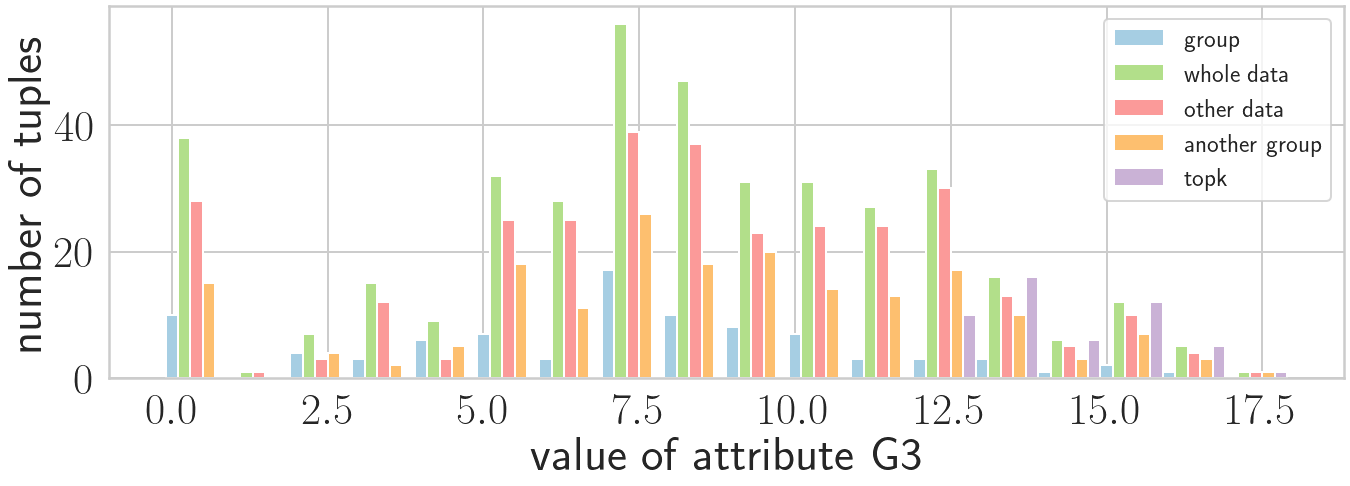

In [213]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc))
plot_distribution_number(ranked_data, 'G3', groups_global_bounds[1], another_group, k)

True


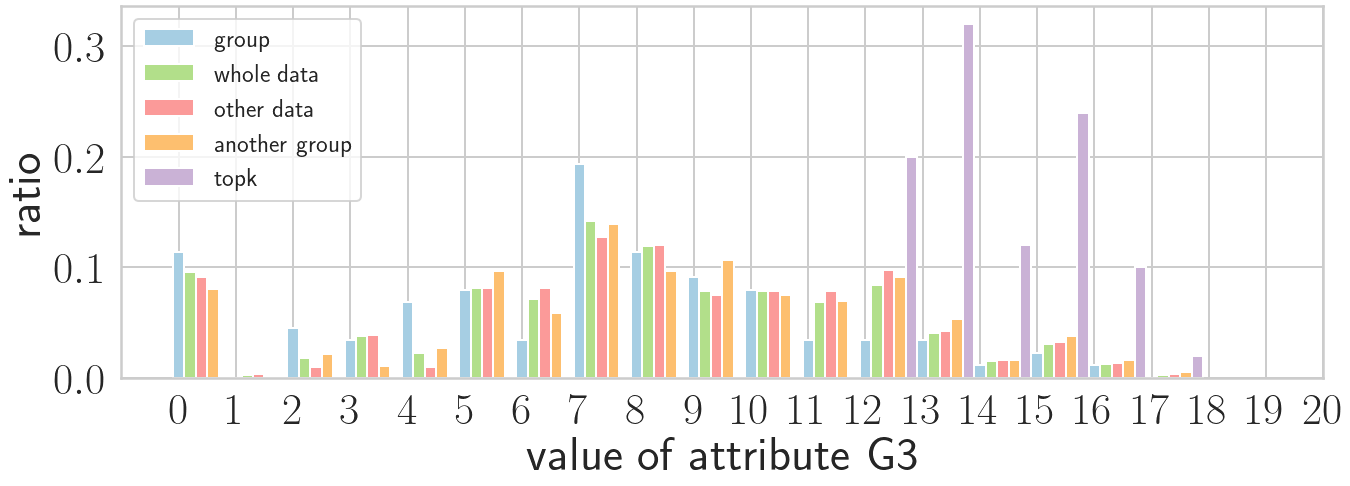

In [214]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc))
plot_distribution_ratio(ranked_data, 'G3', groups_global_bounds[1], another_group, k)


395 50 40.0
True


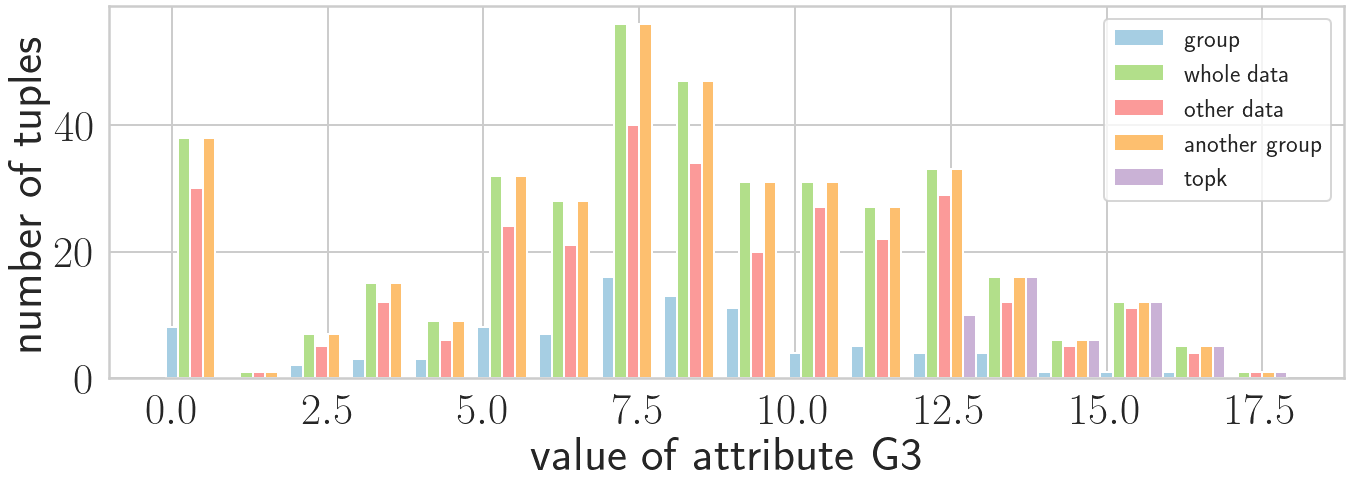

In [215]:
# proportional bounds
another_group = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))
plot_distribution_number(ranked_data, 'G3', groups_prop_bounds[3], another_group, k)

395 50 40.0
True


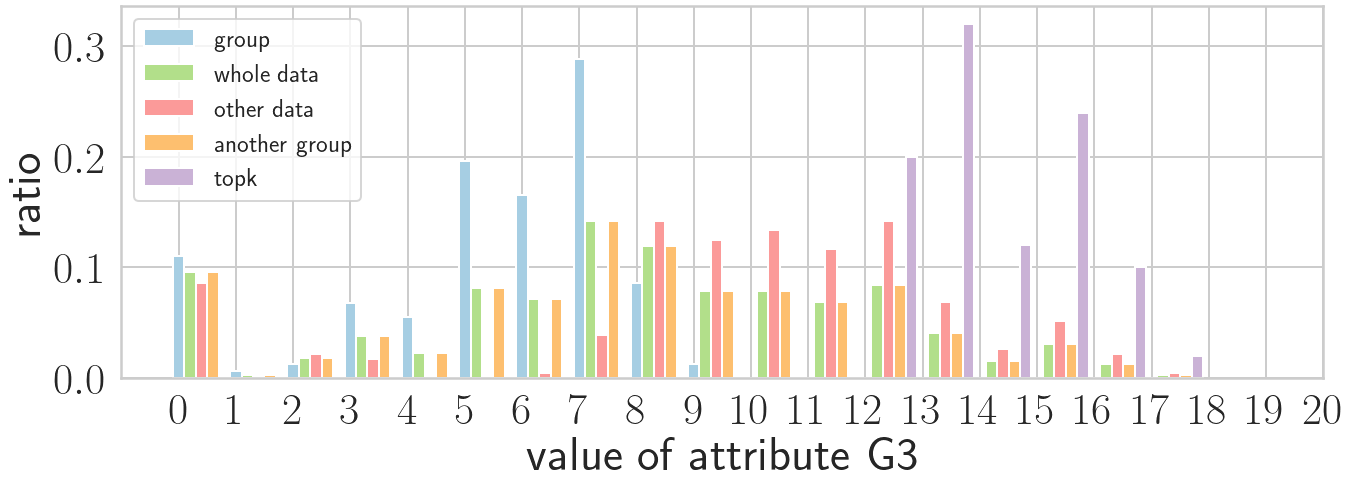

In [216]:
# proportional bounds
another_group = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))
plot_distribution_ratio(ranked_data, 'G3', groups_prop_bounds[6], another_group, k)

# compas

In [217]:

all_attributes = ["age_binary", "sex_binary", "race_C", "MarriageStatus_C", "juv_fel_count_C", "decile_score_C", "juv_misd_count_C", "juv_other_count_C", "priors_count_C", "days_b_screening_arrest_C",
                  "c_days_from_compas_C", "c_charge_degree_C", "v_decile_score_C", "start_C", "end_C",
                  "event_C"]

original_data_file = r"../../../InputData/CompasData/general/compas_data_cat_necessary_att_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)

# scoring attributes:
# c days from compas,
# juv other count, days b screening arrest, start, end,
# age, and priors count


# all att

In [218]:
selected_attributes = all_attributes

k = 50
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [219]:
selected_attributes = all_attributes

alpha = 0.8
k = 10
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 145.60156917572021
finish kmin
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0]
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]
[-1, -1, 0, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

In [220]:

x = ranked_data[selected_attributes]
y = ranked_data['rank']

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

age_binary = 118.35712
sex_binary = -106.43005
race_C = -48.16972
MarriageStatus_C = -15.31068
juv_fel_count_C = 123.51085
decile_score_C = 246.2854
juv_misd_count_C = 610.78696
juv_other_count_C = 886.57479
priors_count_C = 1245.29947
days_b_screening_arrest_C = 595.05885
c_days_from_compas_C = 1391.6477
c_charge_degree_C = -2.53718
v_decile_score_C = 4.28951
start_C = 1254.30561
end_C = 1908.92354
event_C = -86.05551


Permutation explainer: 6890it [03:07, 34.79it/s]                          


.values =
array([[  -26.03856592,    17.02880754,   -21.67637241, ...,
            0.        , -1698.94194701,   -50.77275139],
       [  -26.03856592,    17.02880754,    26.49334406, ...,
            0.        , -1698.94194701,   -50.77275139],
       [  -26.03856592,    17.02880754,    26.49334406, ...,
            0.        , -1698.94194701,   -50.77275139],
       ...,
       [  -26.03856592,   -89.40123956,    26.49334406, ...,
            0.        ,  2118.90512492,    35.28275944],
       [  -26.03856592,    17.02880754,    26.49334406, ...,
            0.        ,  2118.90512492,    35.28275944],
       [  -26.03856592,    17.02880754,    26.49334406, ...,
            0.        ,   209.98158896,    35.28275944]])

.base_values =
array([3313.66118335, 3313.66118335, 3313.66118335, ..., 3313.66118335,
       3313.66118335, 3313.66118335])

.data =
array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 2

group g doesn't have enough representation in top k 6
False


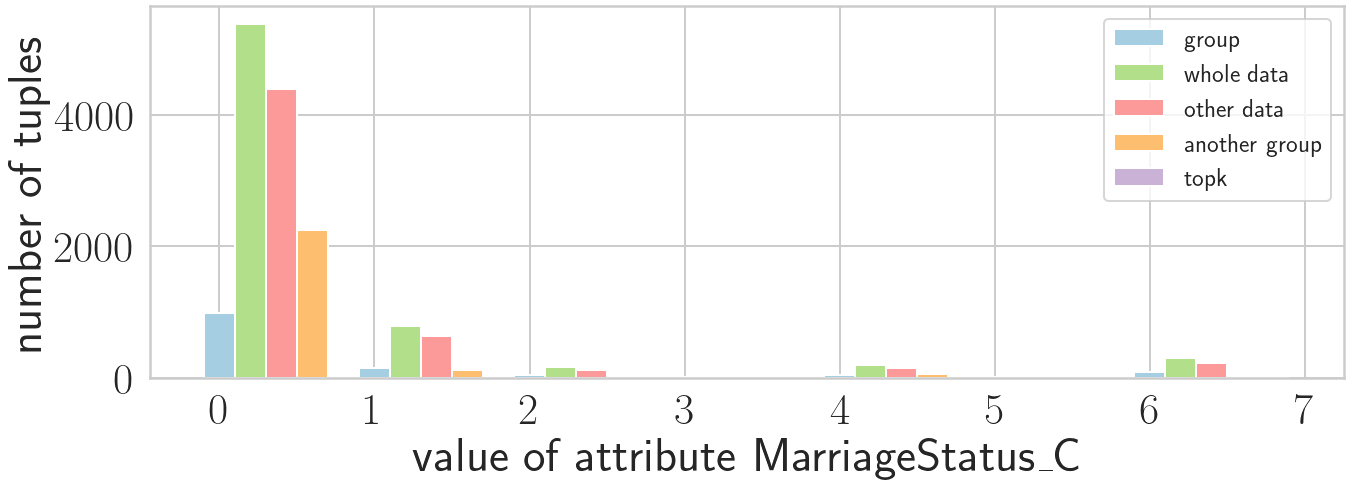

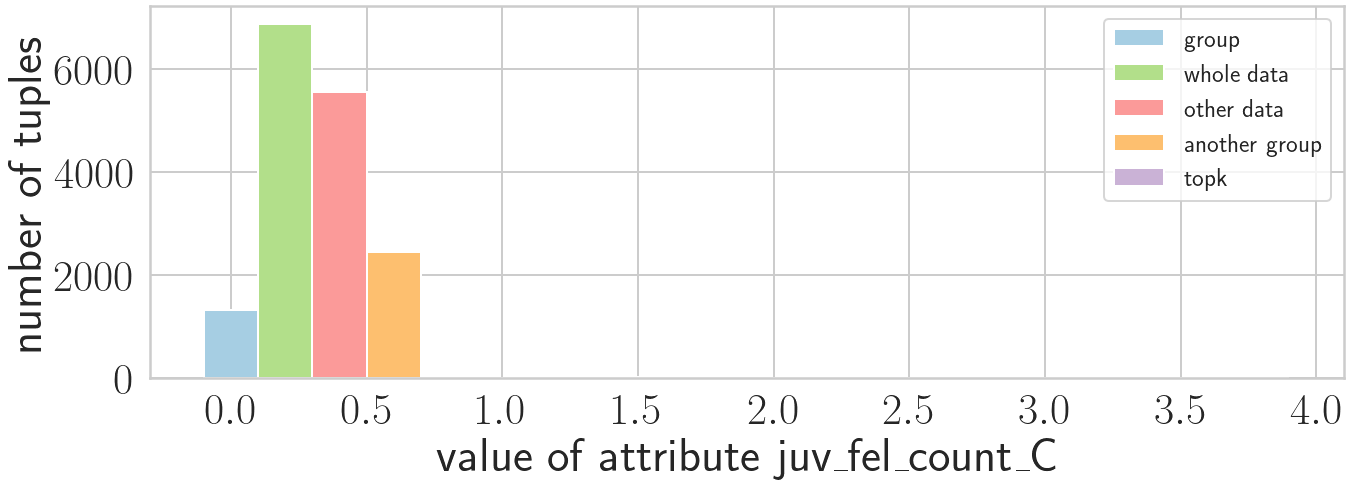

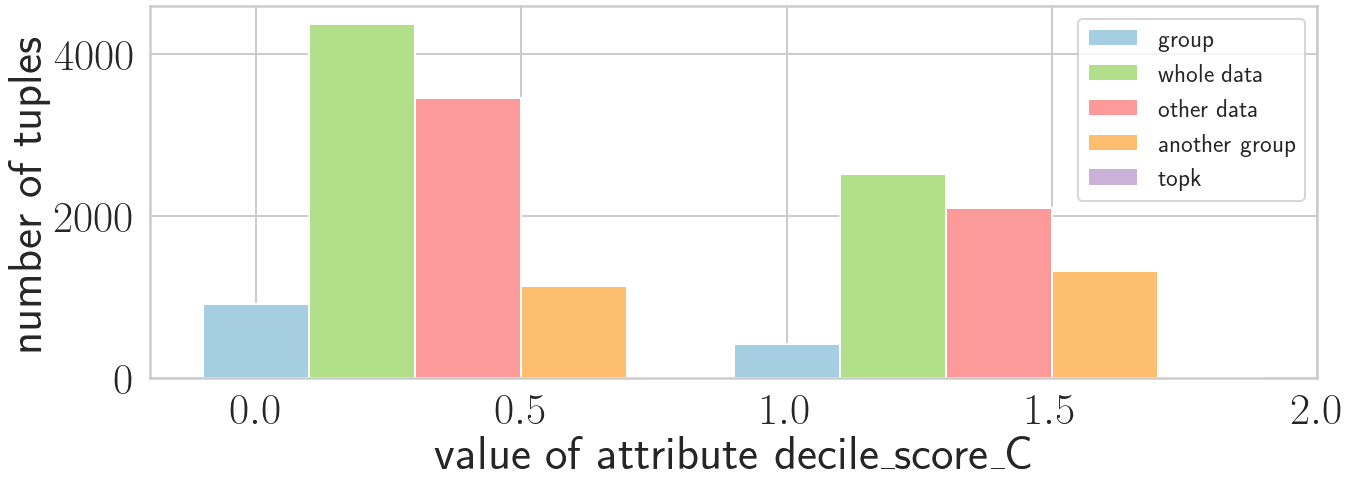

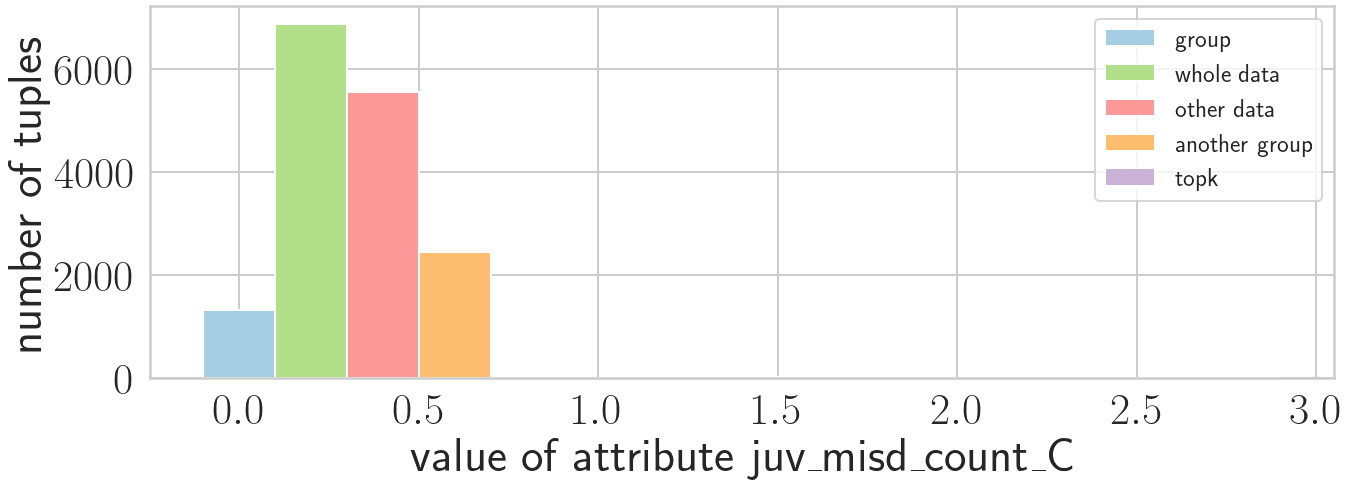

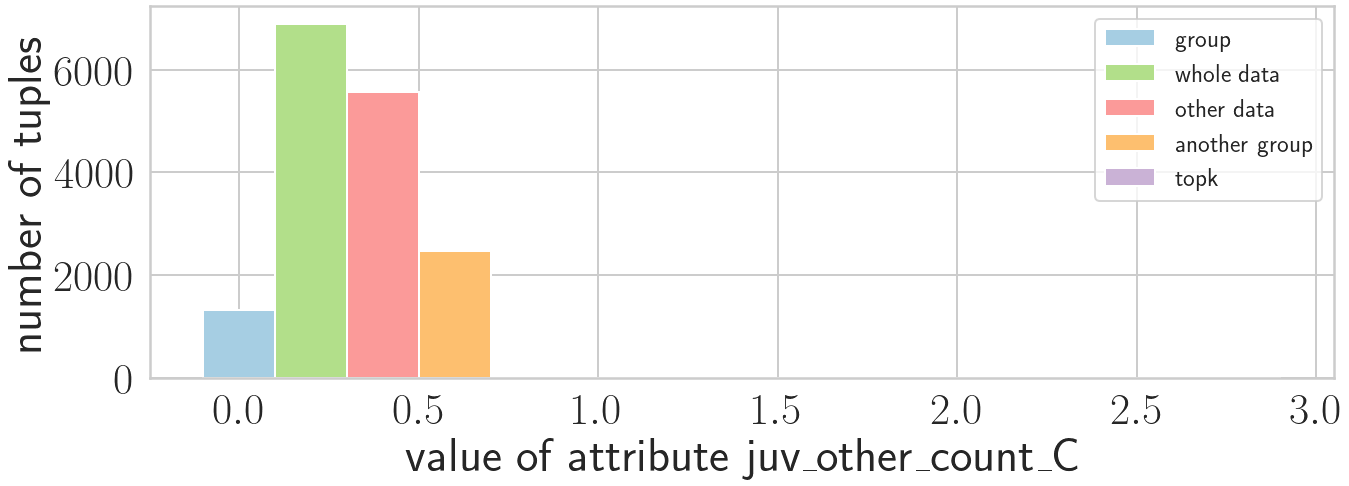

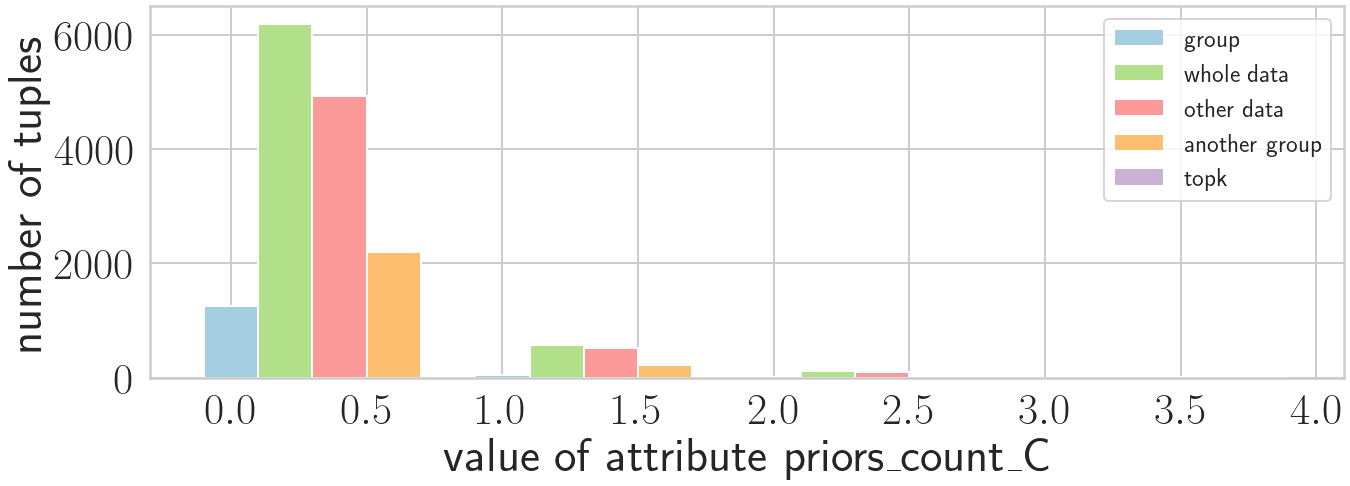

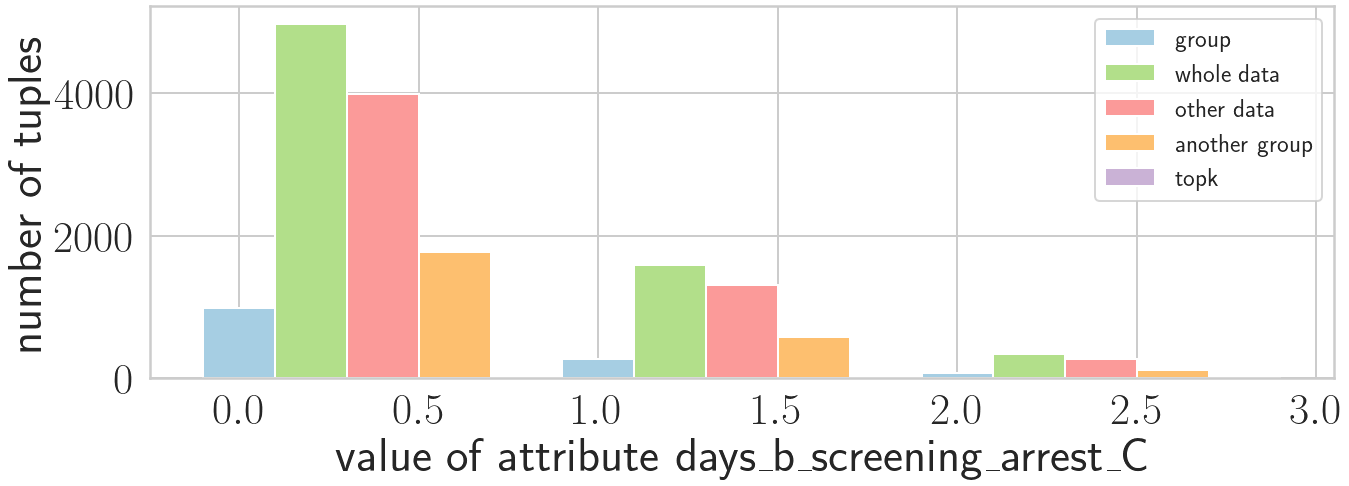

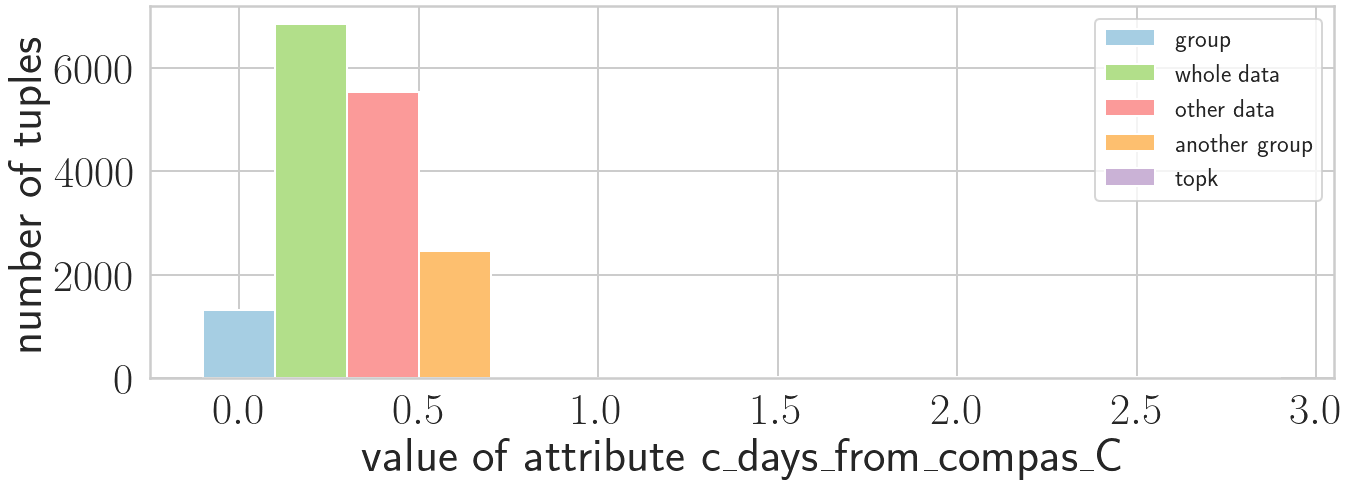

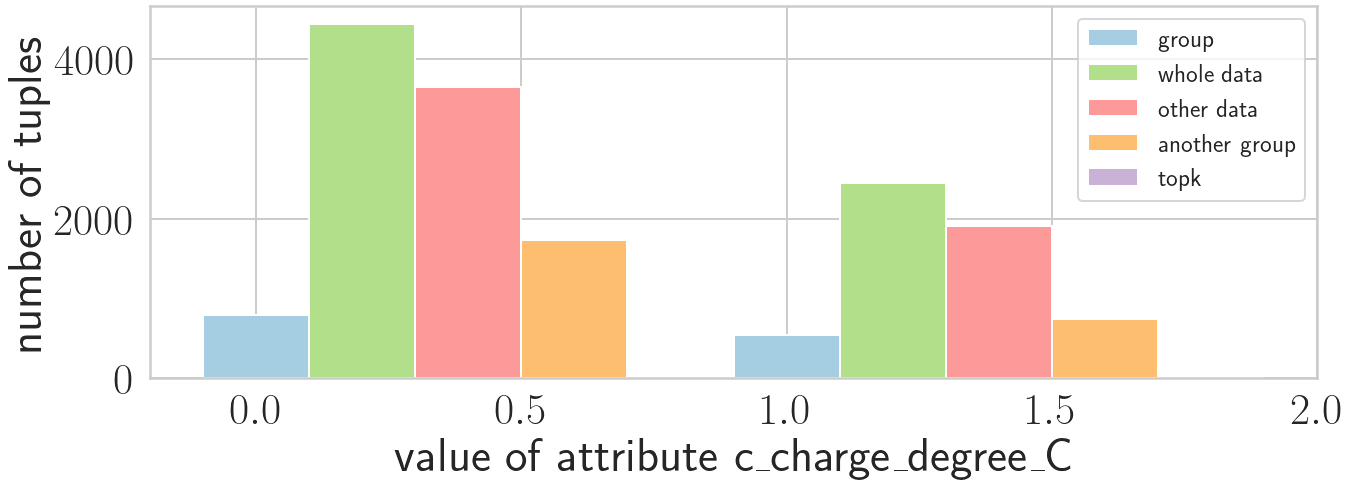

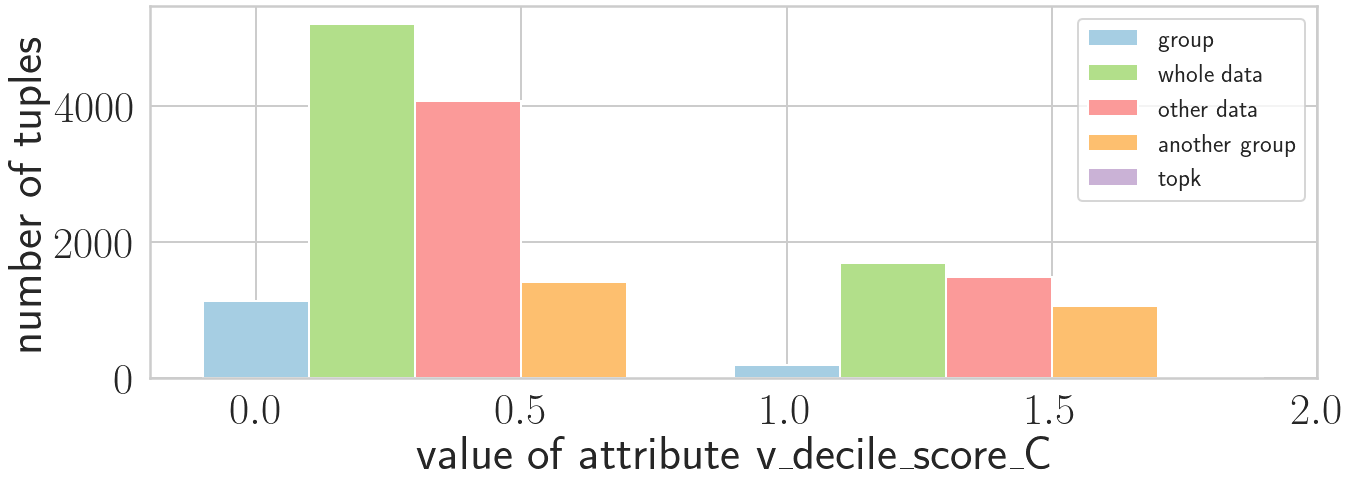

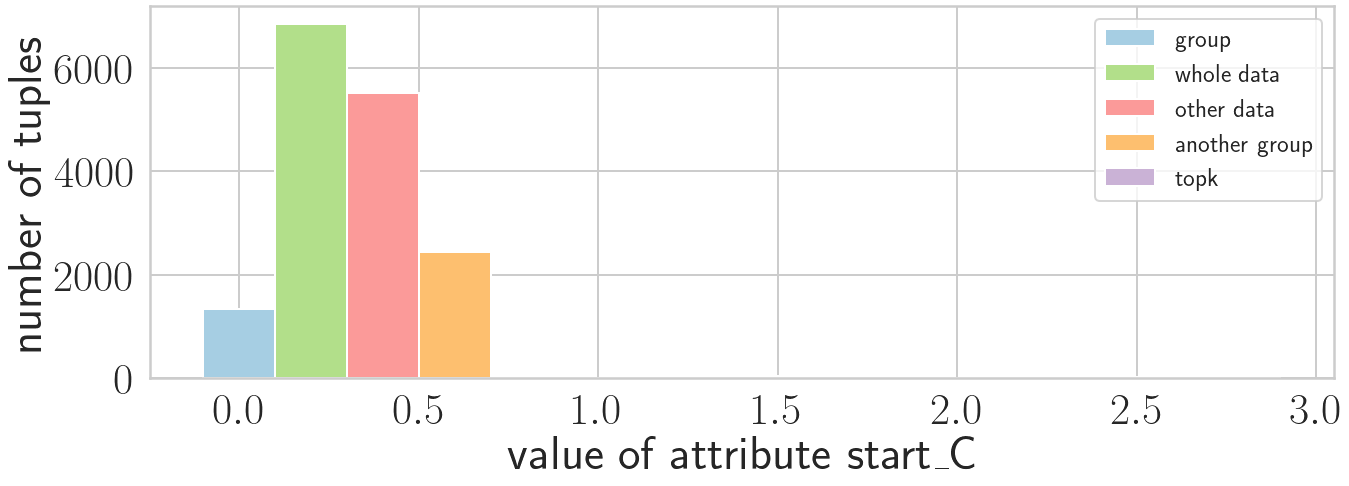

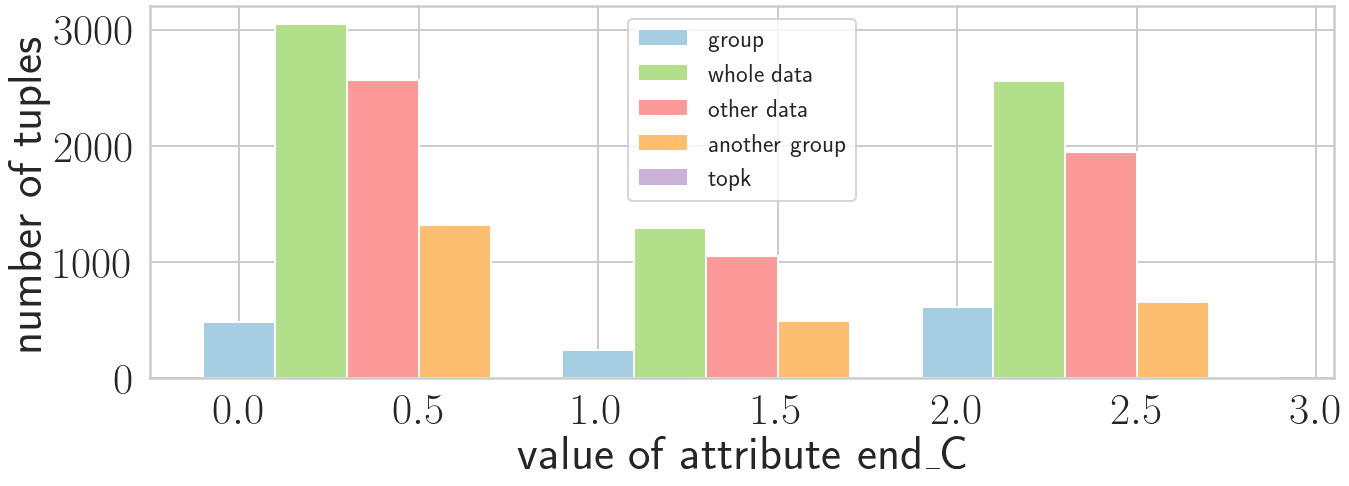

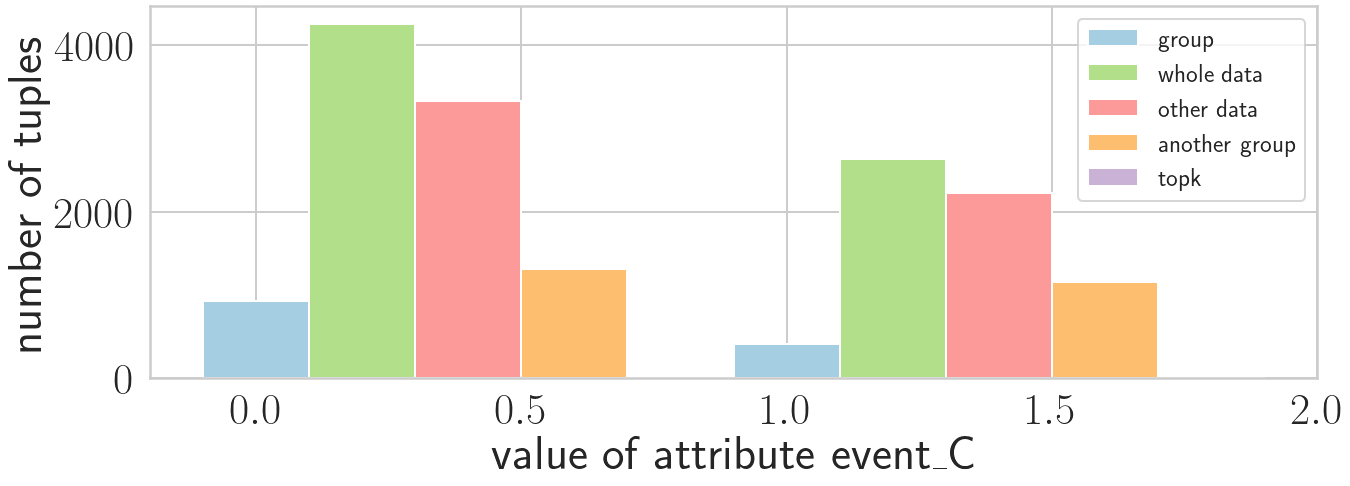

In [222]:
another_group = [0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc))
for att in selected_attributes[3:]:
    plot_distribution_number(ranked_data, att, groups_global_bounds[1], another_group, k)

group g doesn't have enough representation in top k 6
False


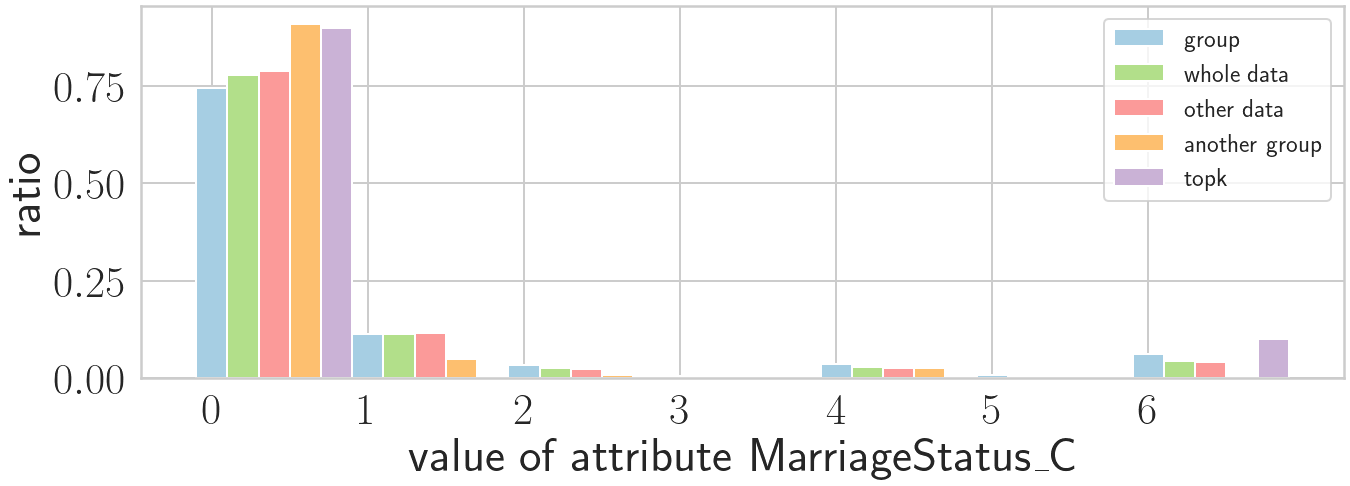

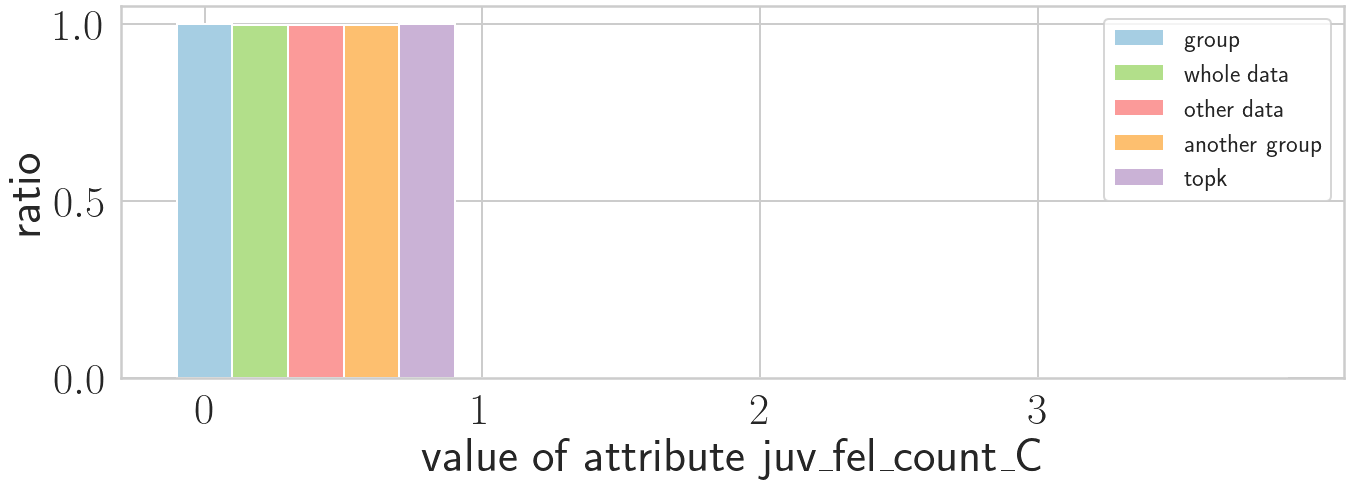

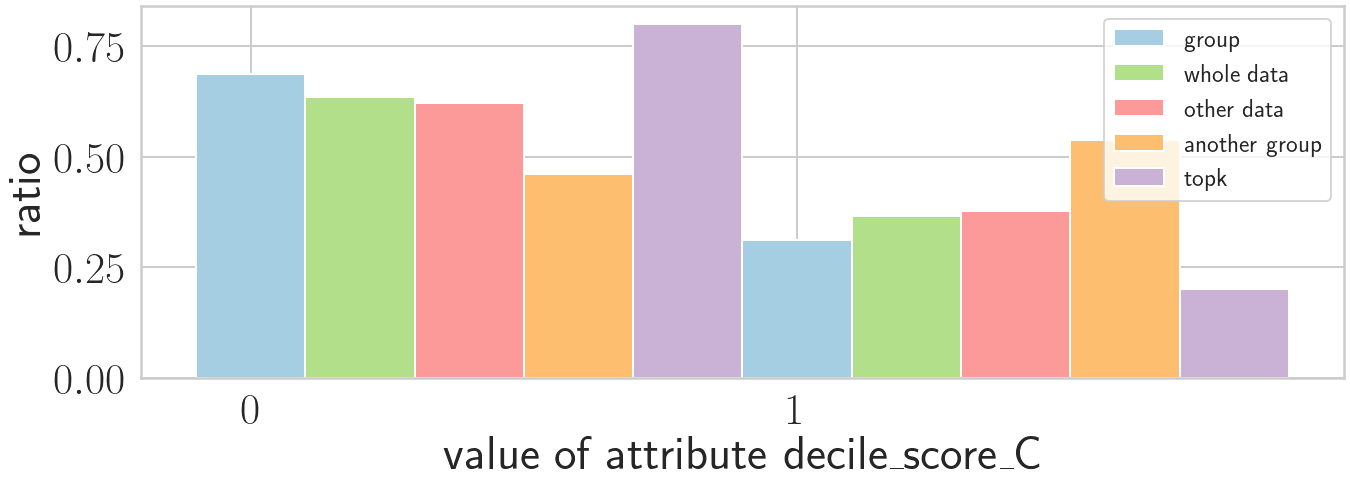

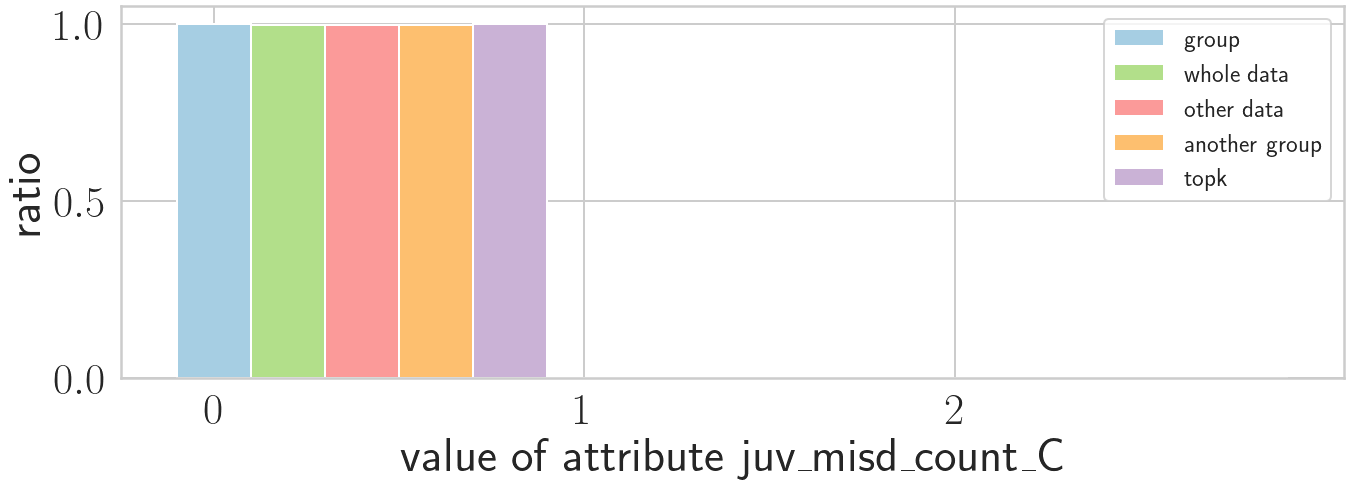

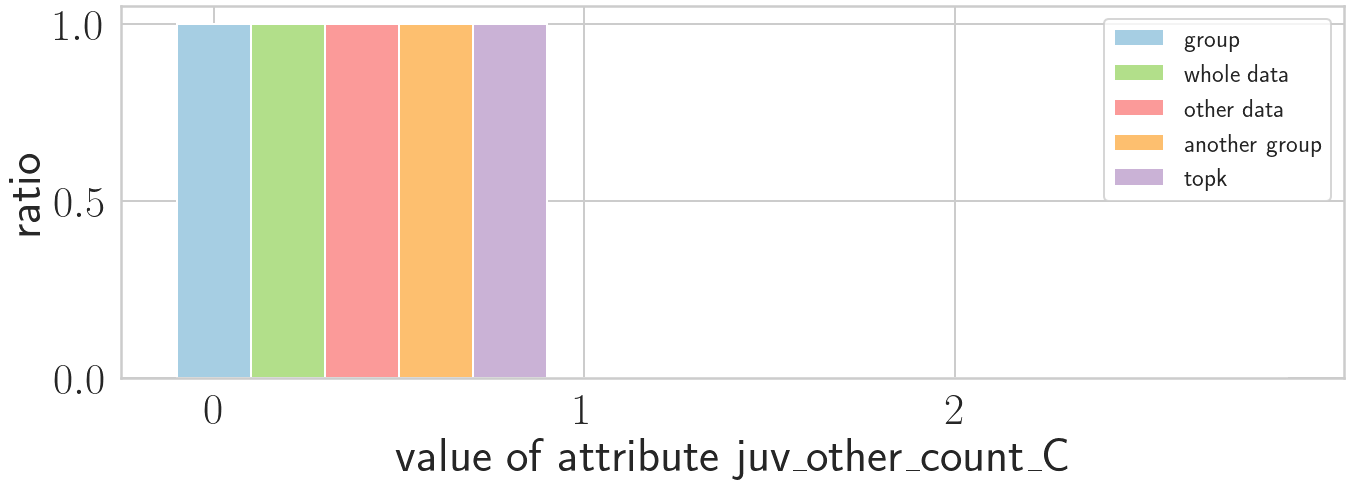

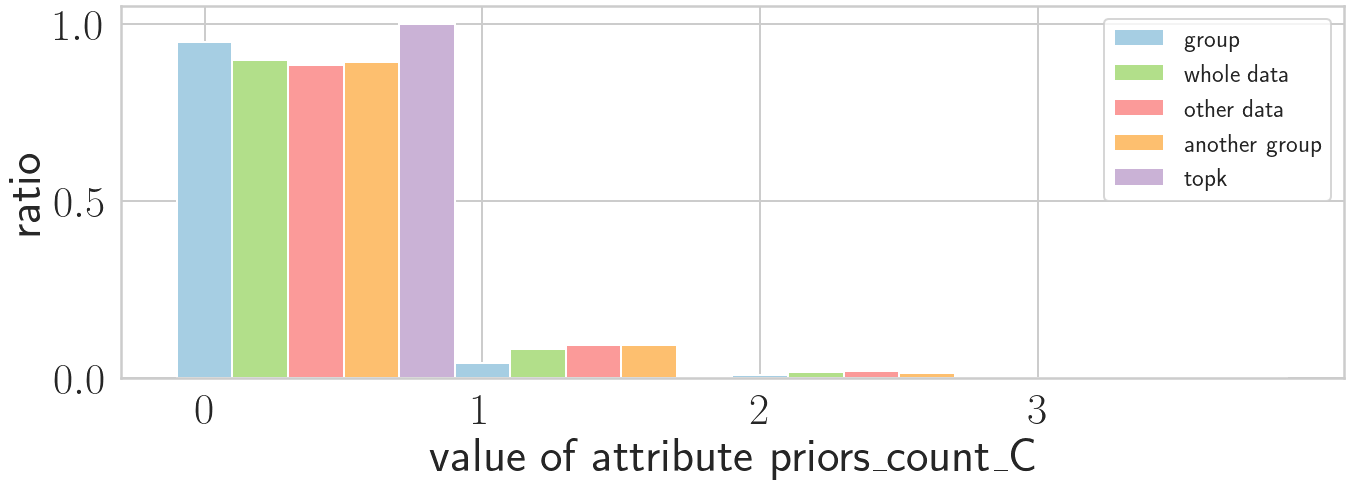

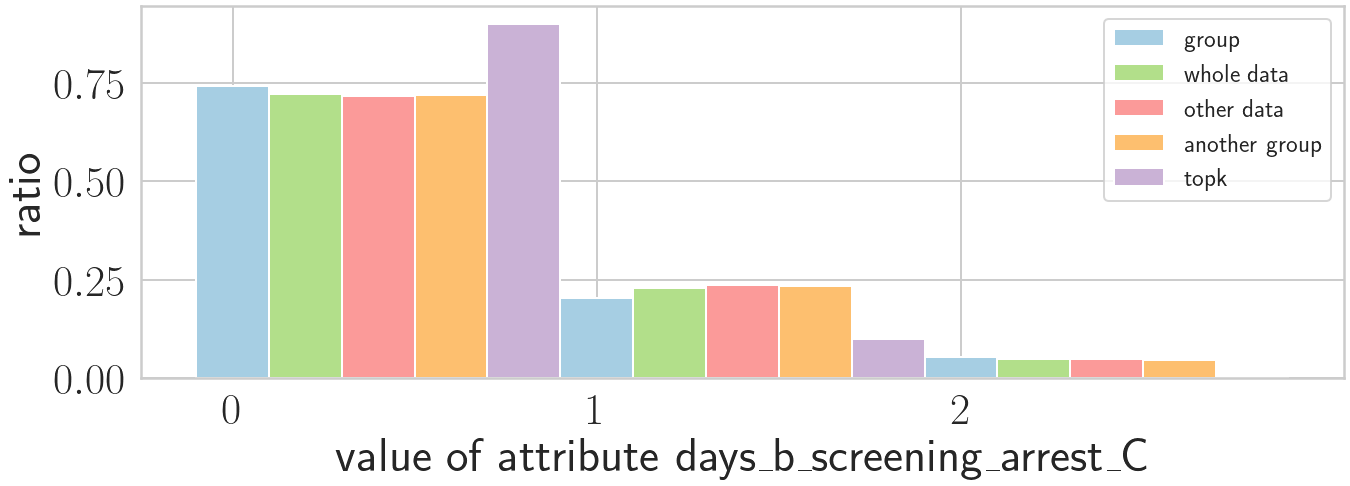

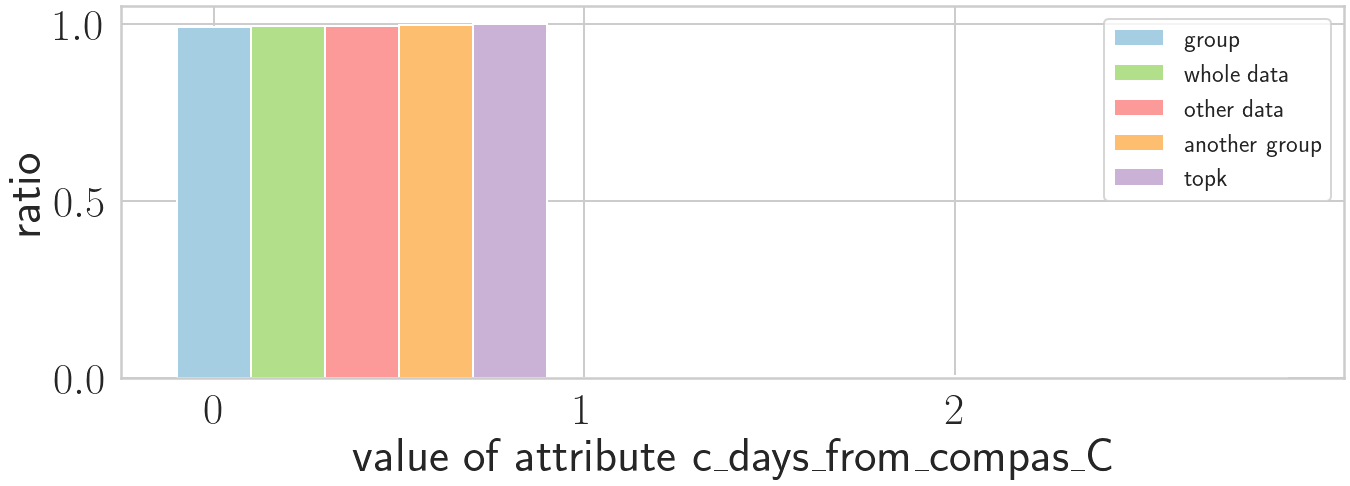

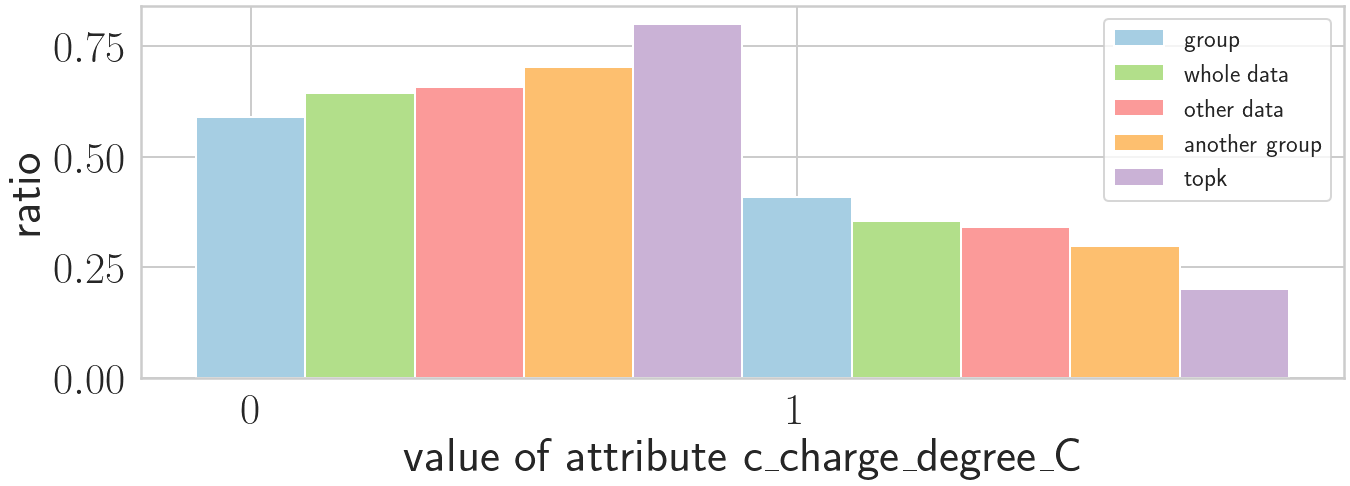

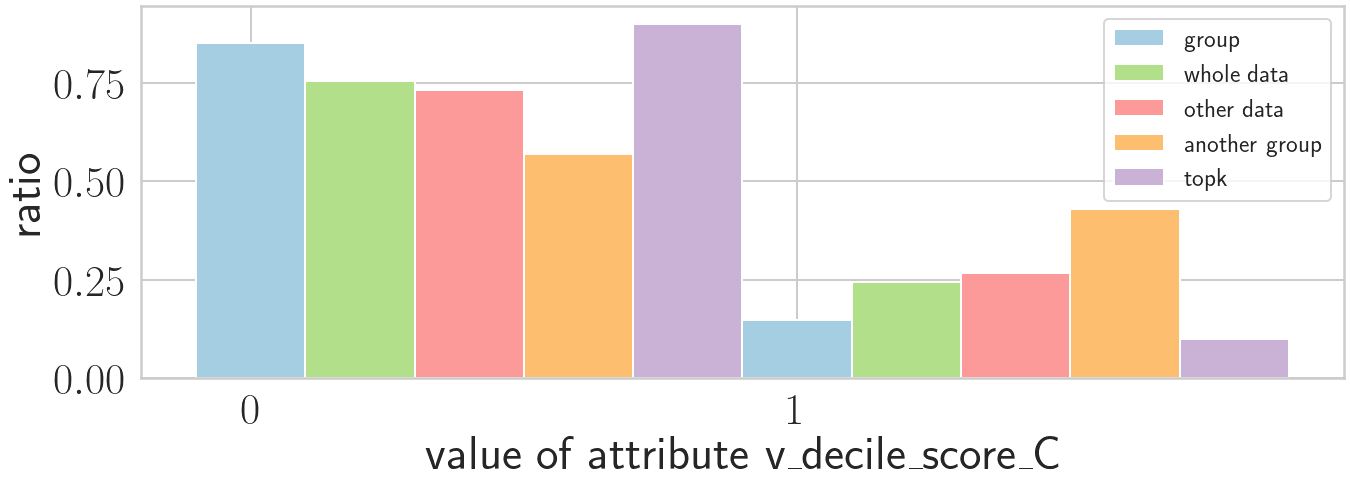

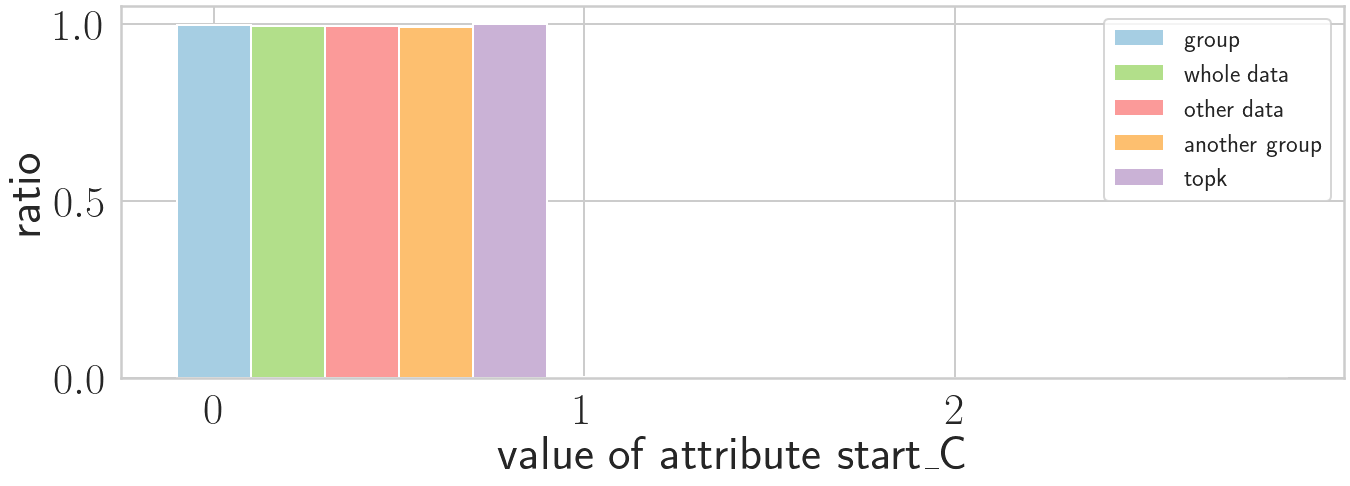

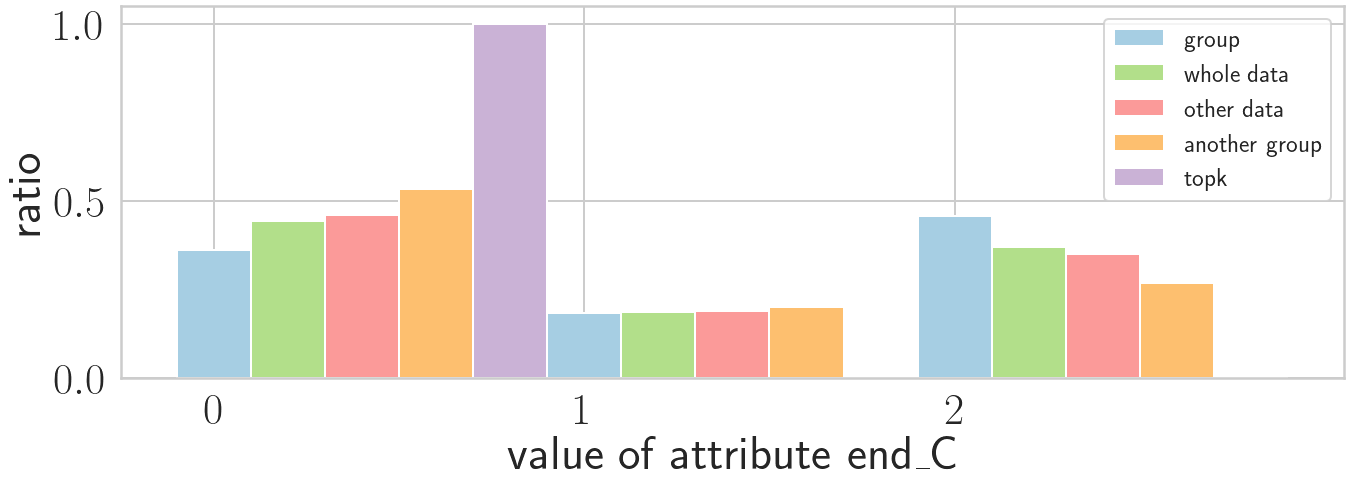

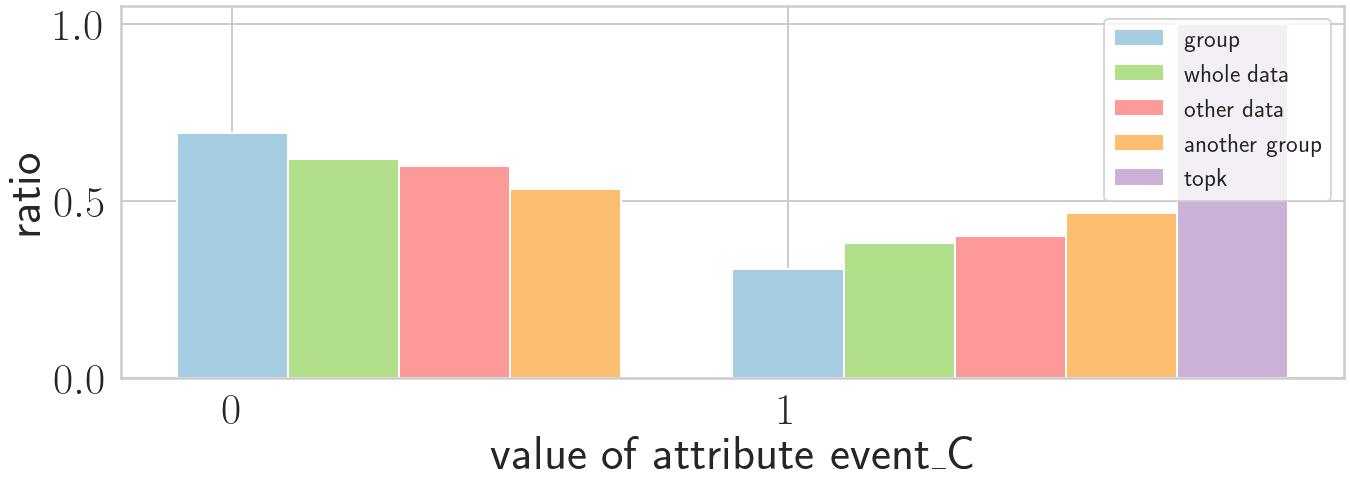

In [223]:
another_group = [0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc))
for att in selected_attributes[3:]:
    plot_distribution_ratio(ranked_data, att, groups_global_bounds[1], another_group, k)

5561 40 32.28915662650602
True


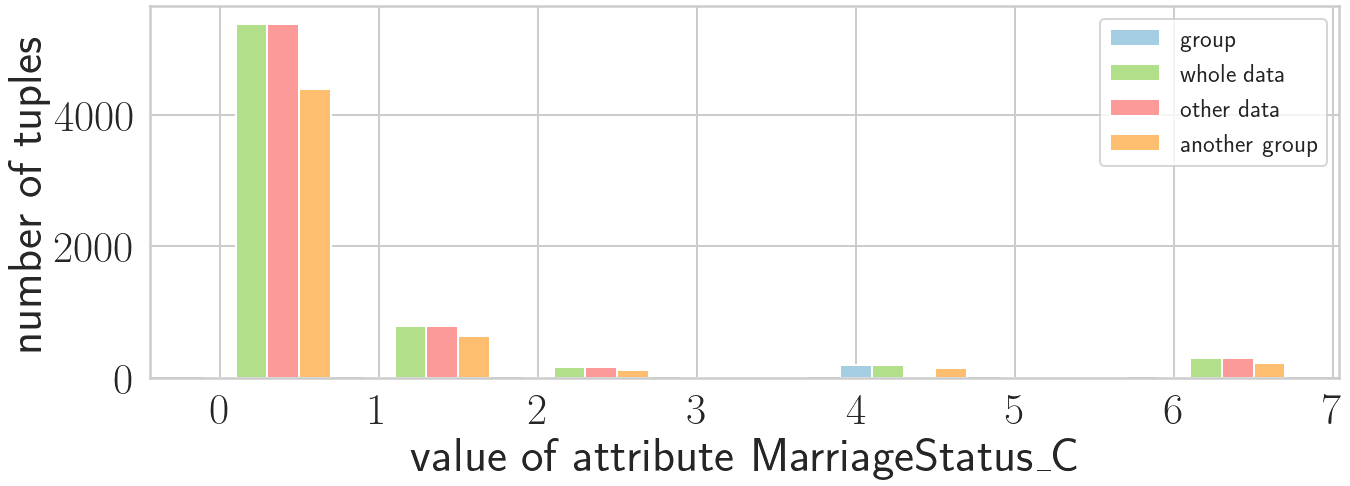

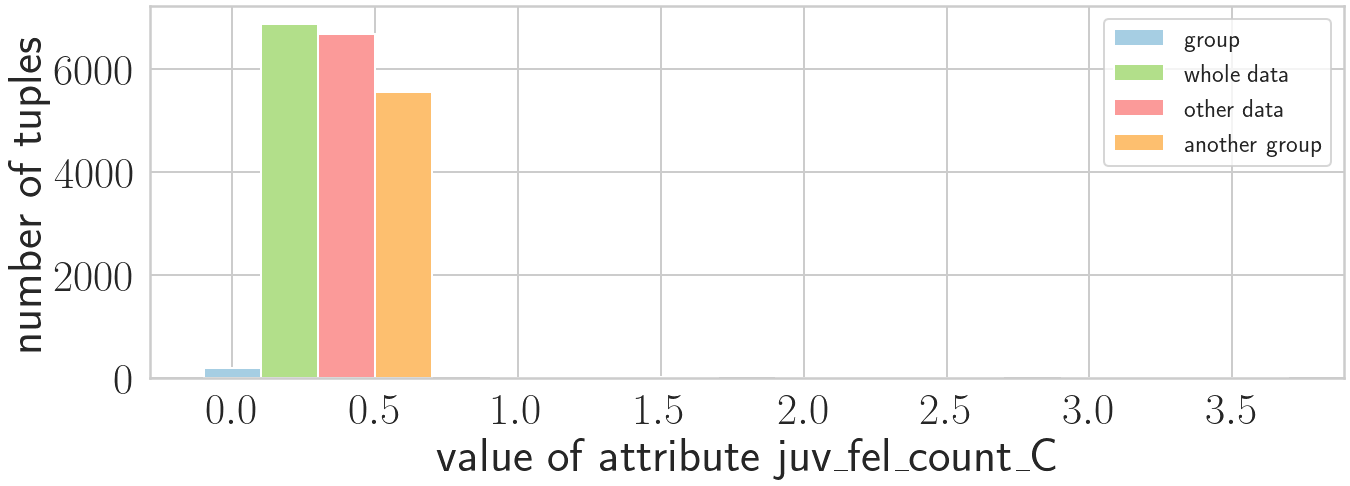

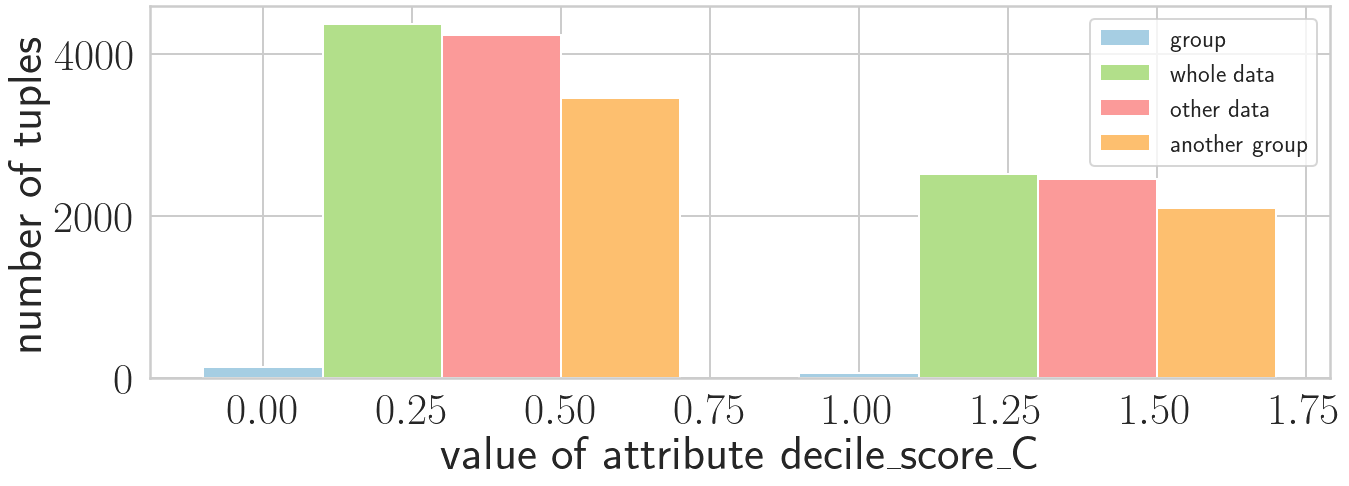

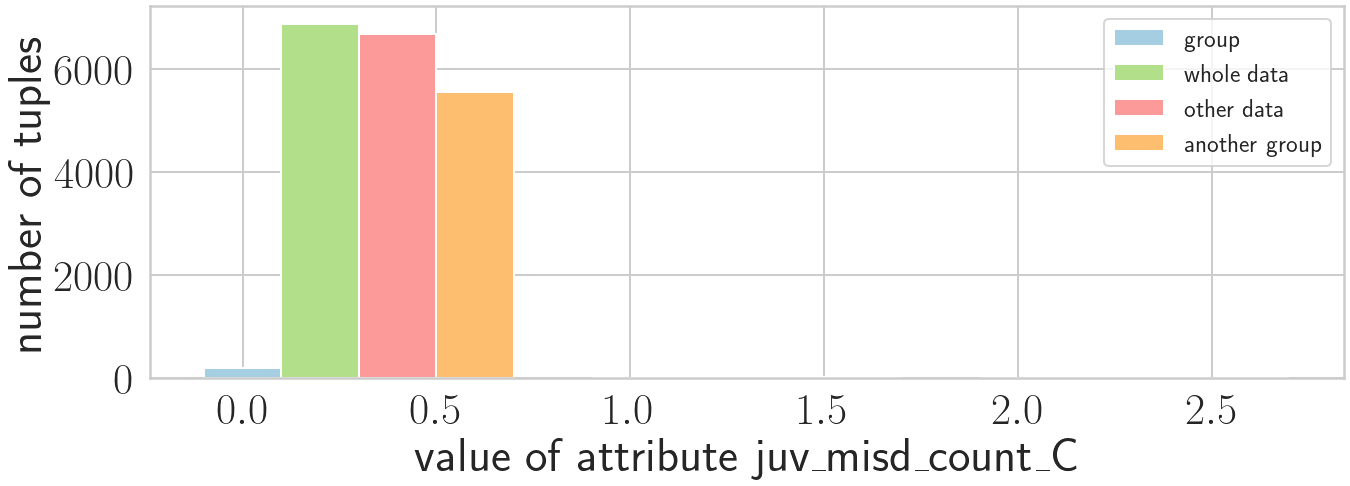

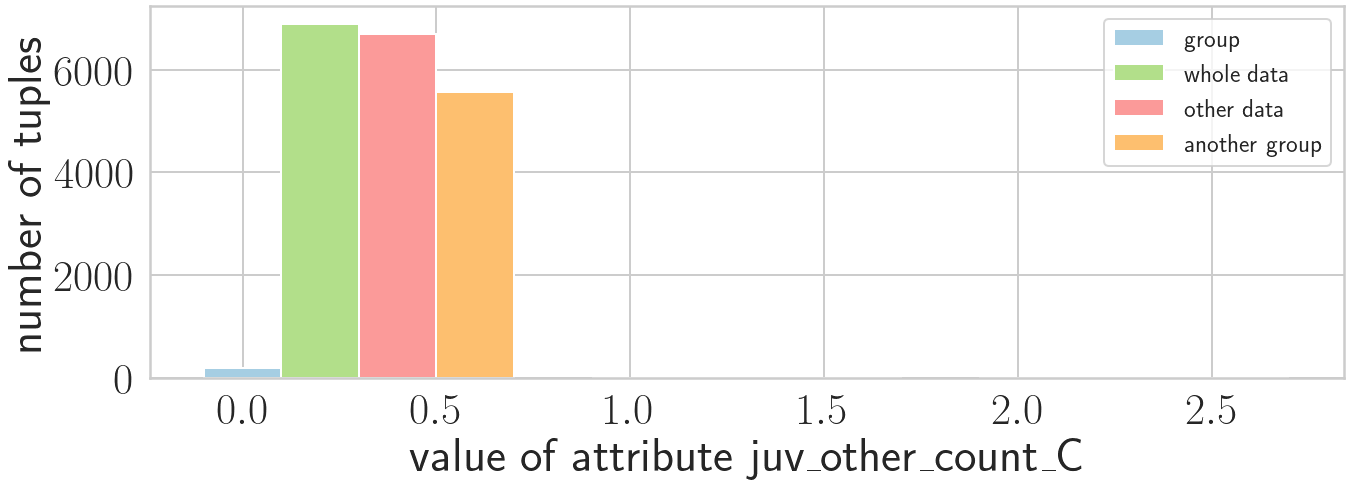

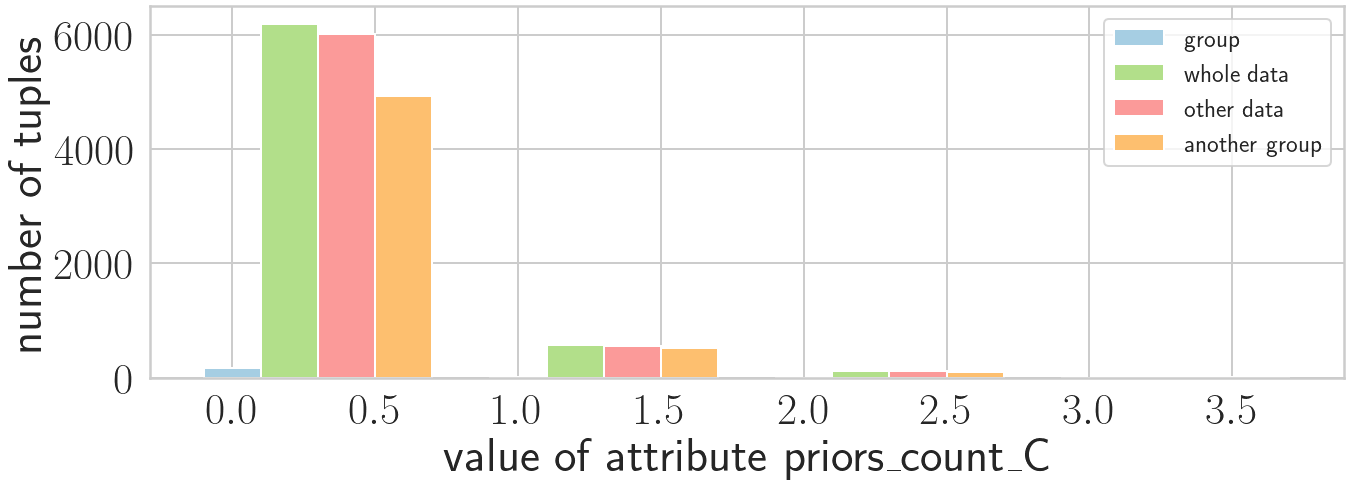

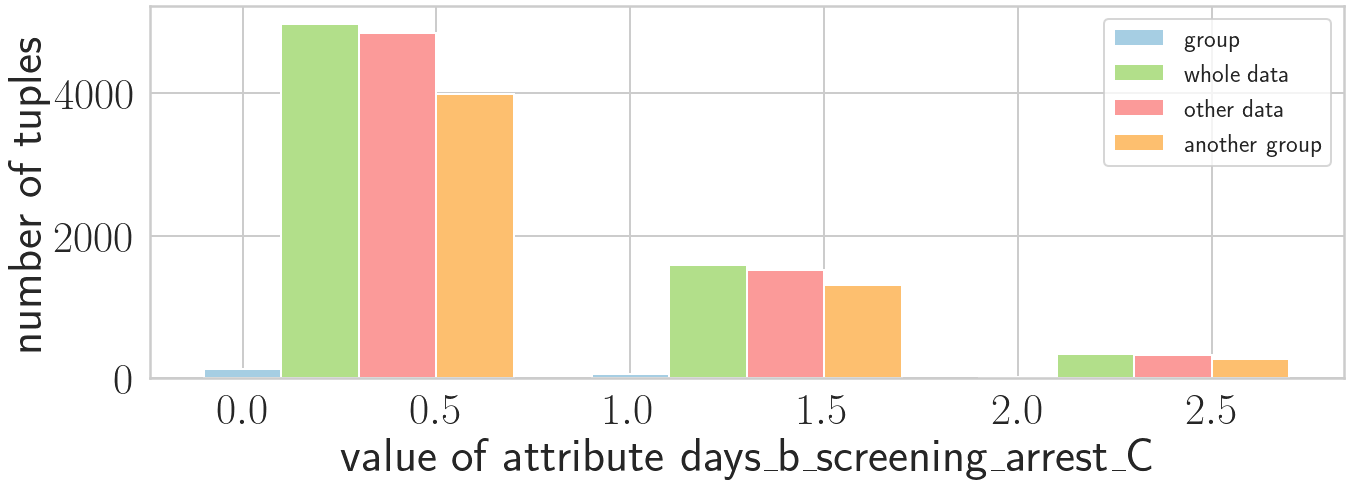

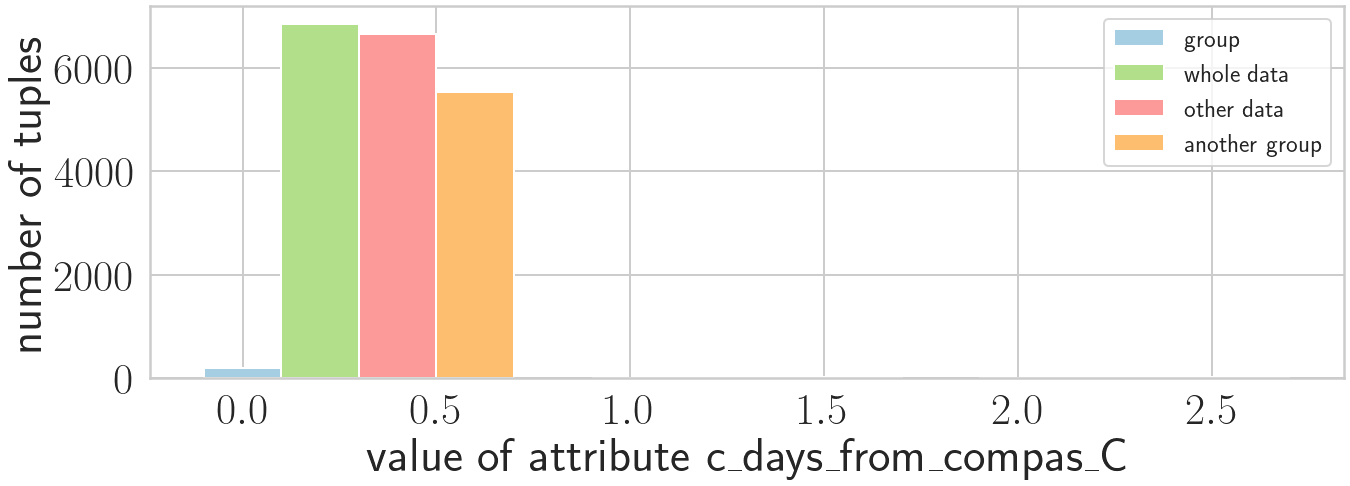

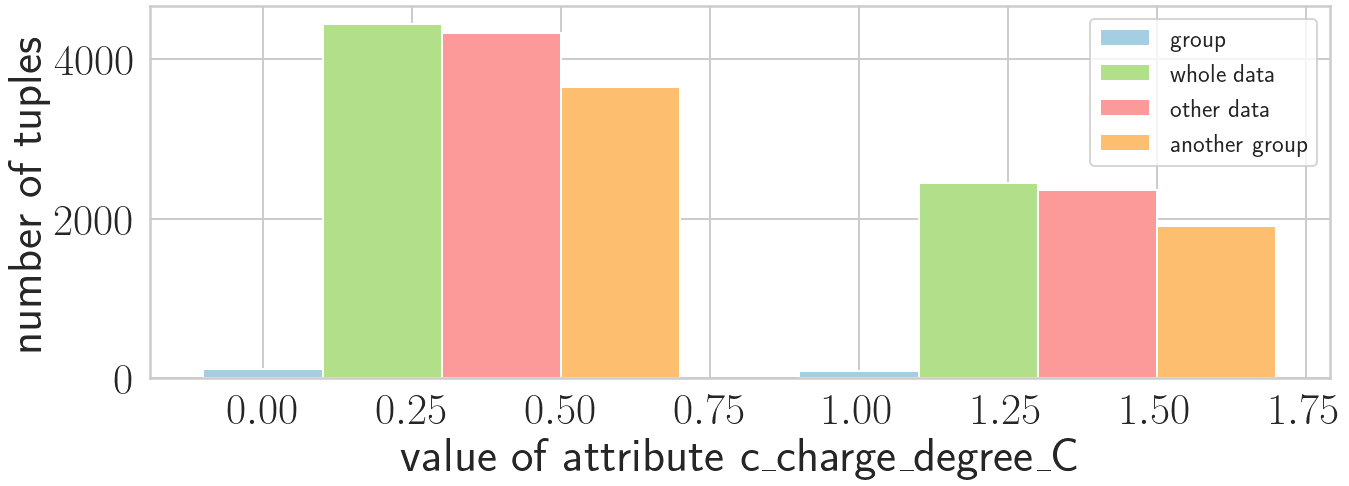

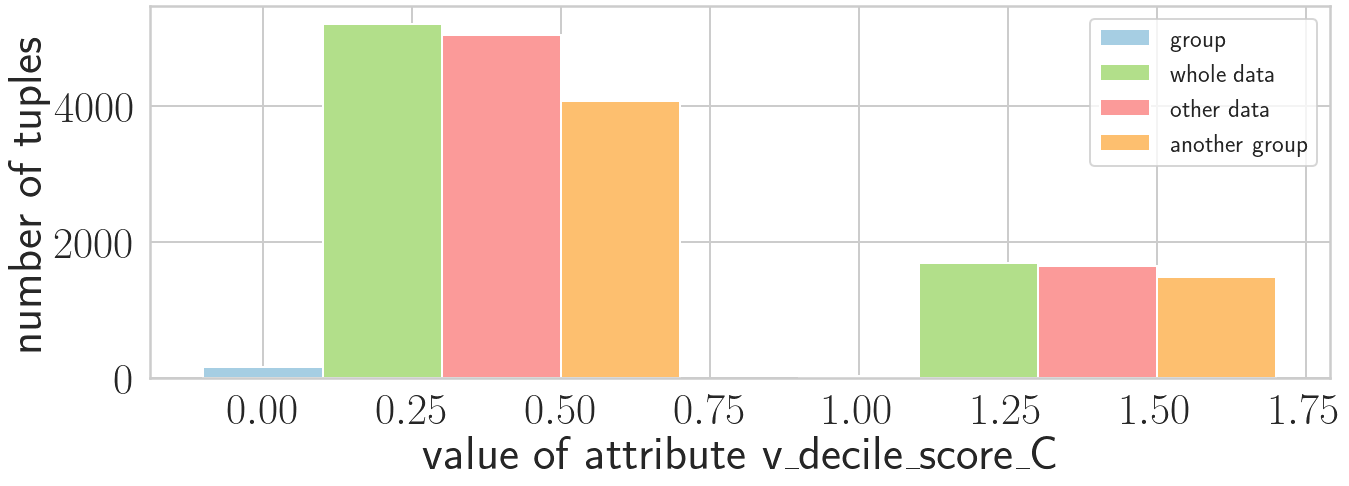

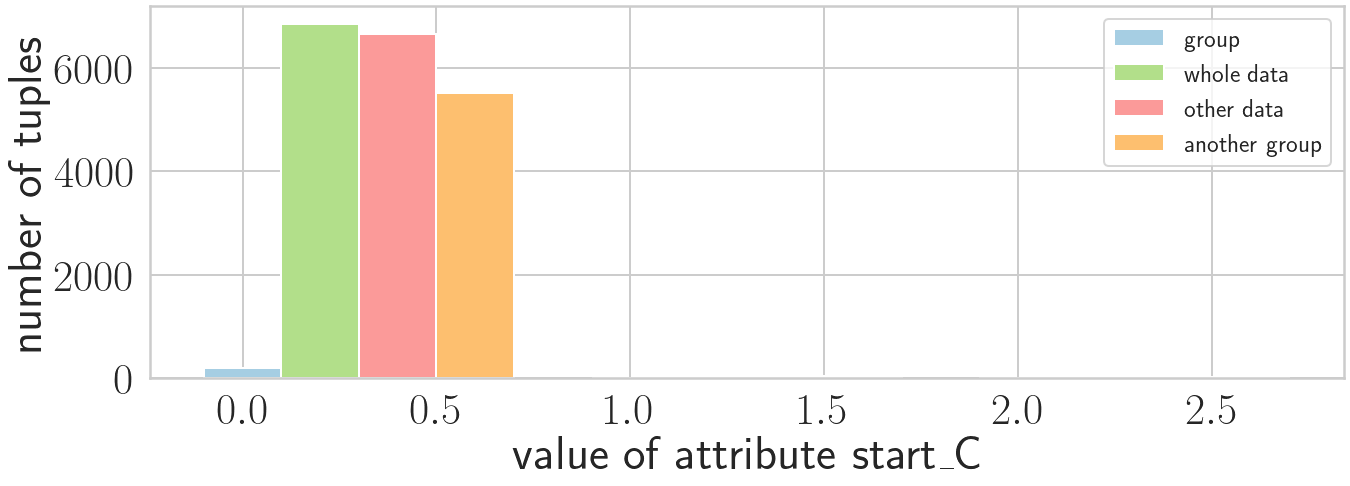

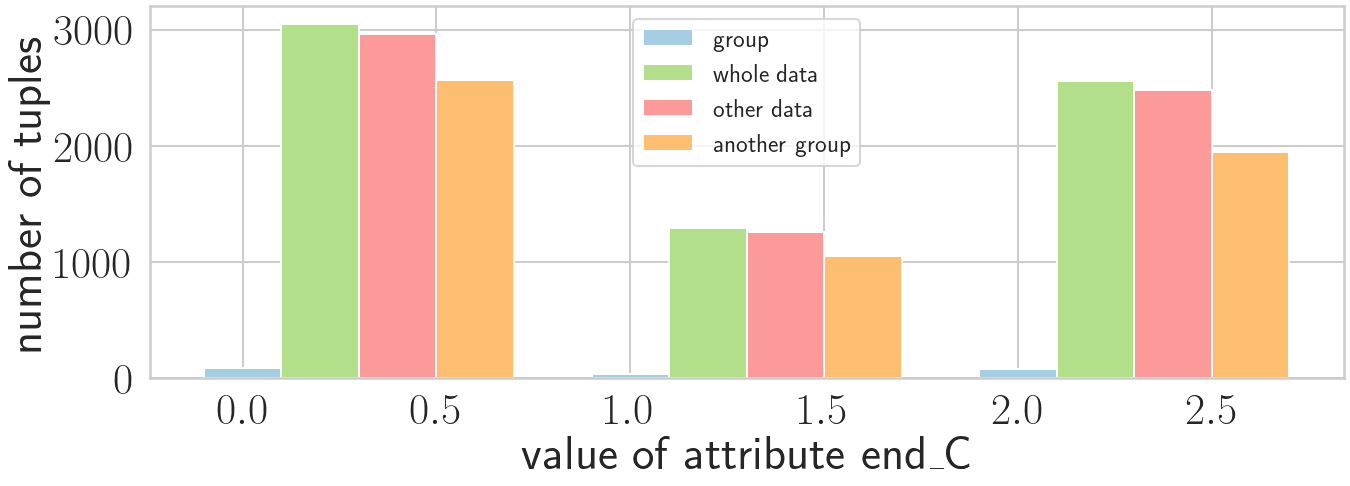

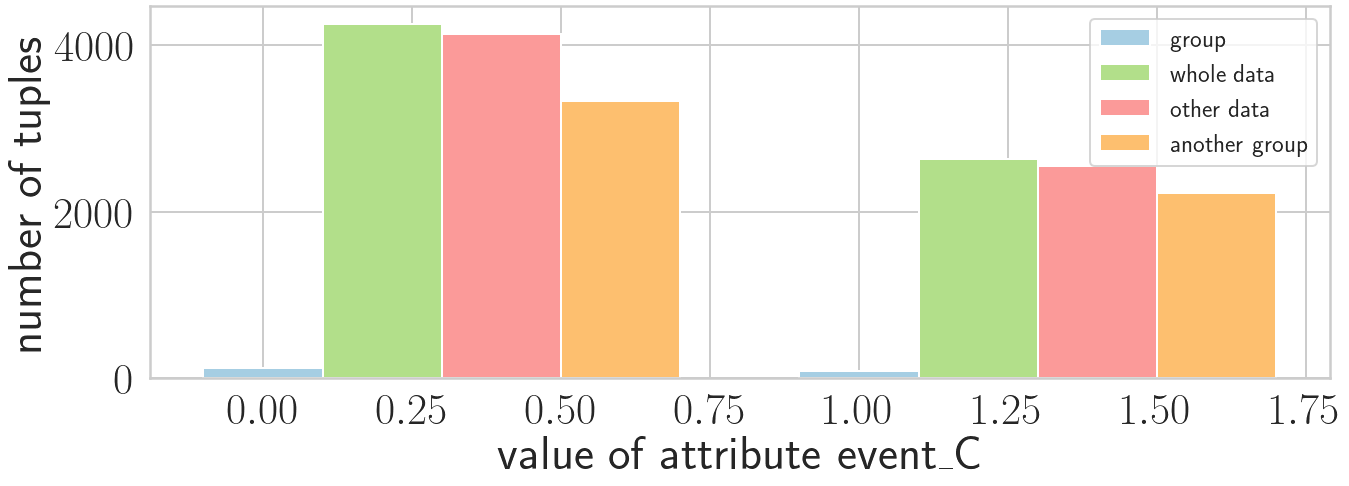

In [159]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))

for att in selected_attributes[3:]:
    plot_distribution_number(ranked_data, att, groups_prop_bounds[1], another_group, k)

5561 40 32.28915662650602
True


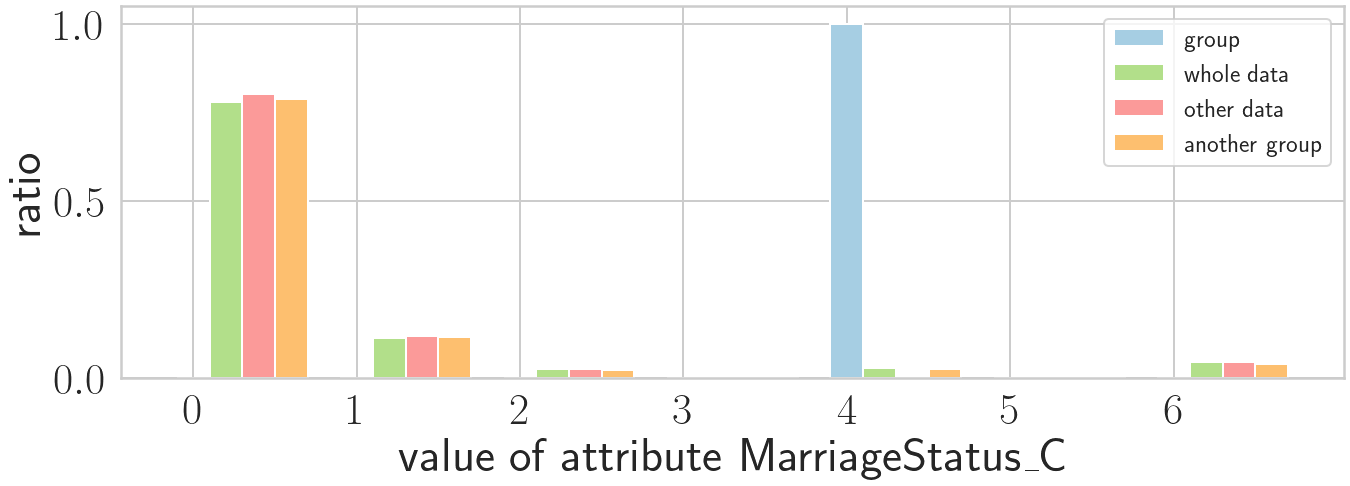

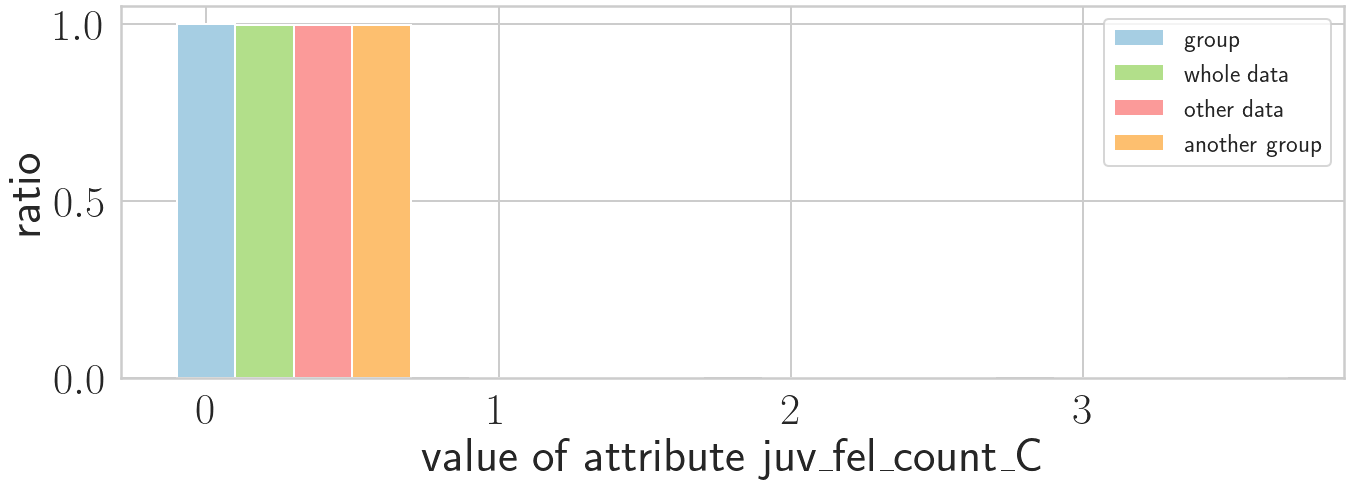

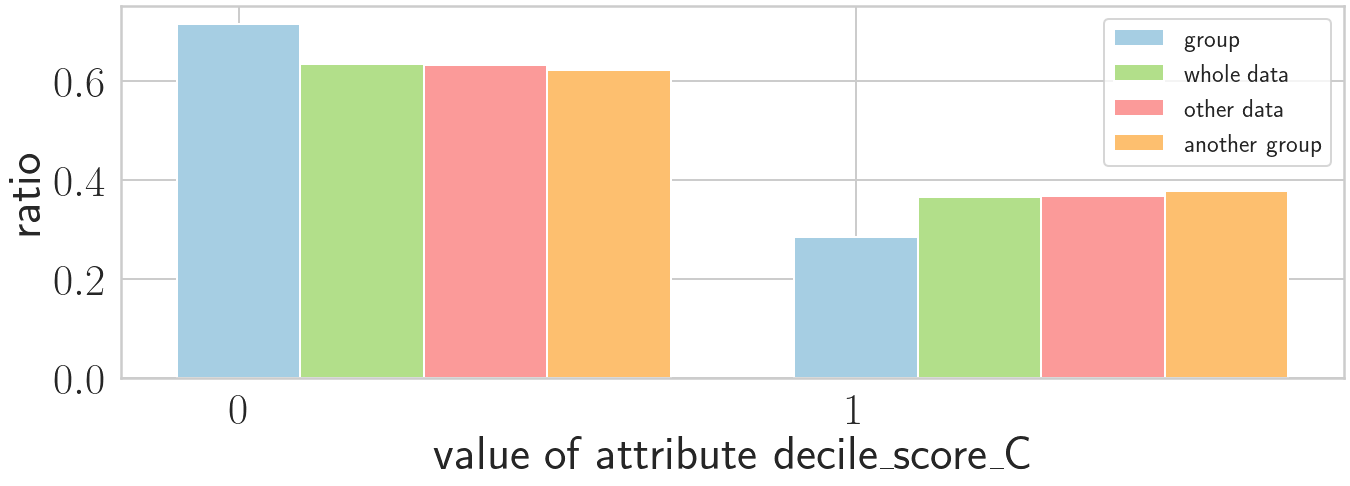

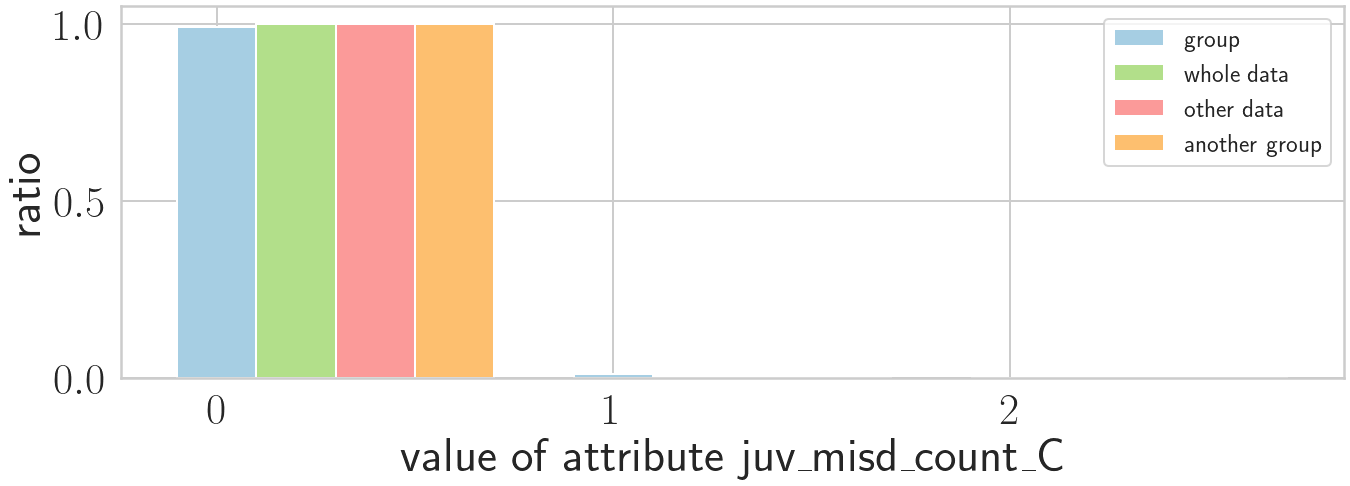

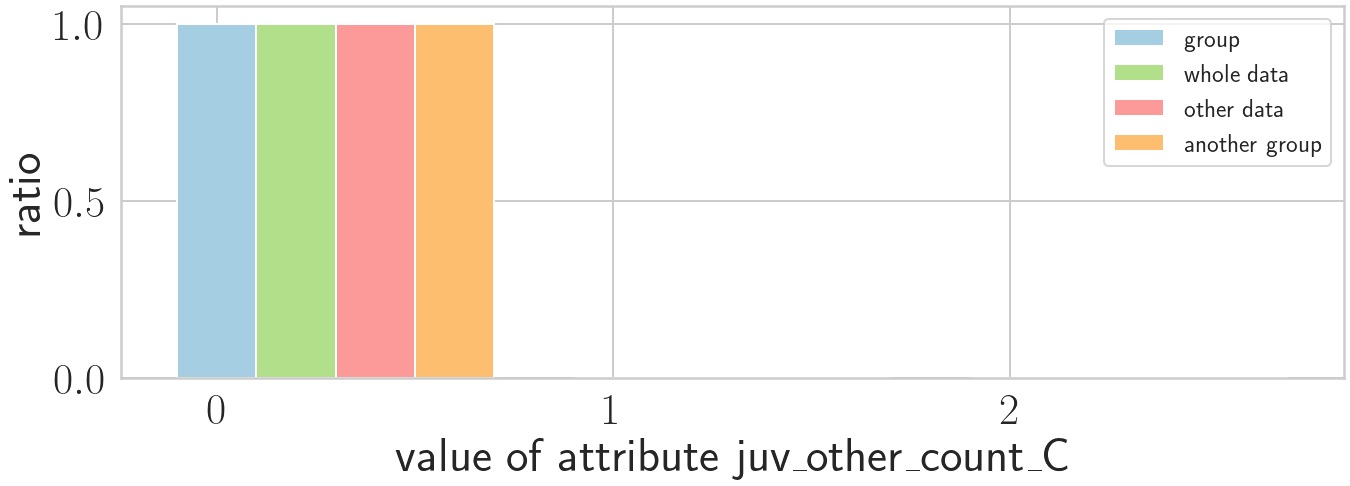

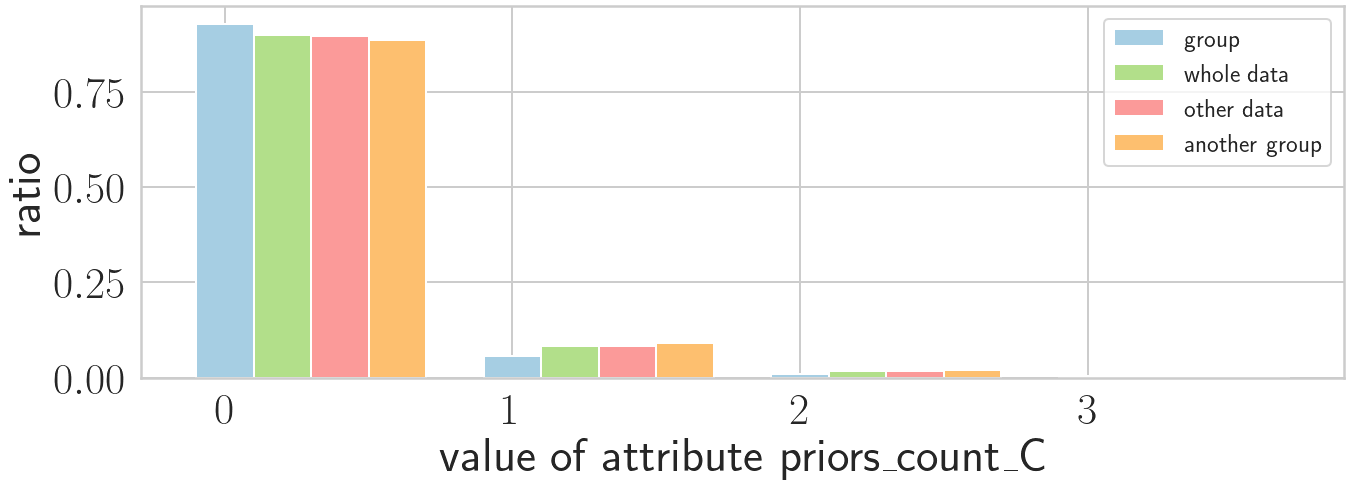

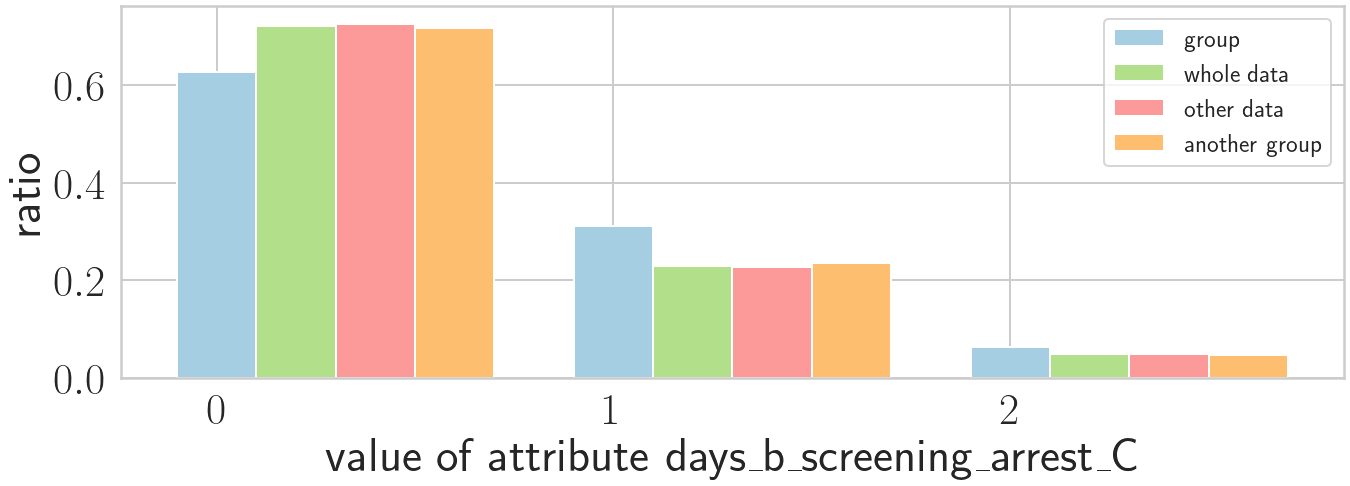

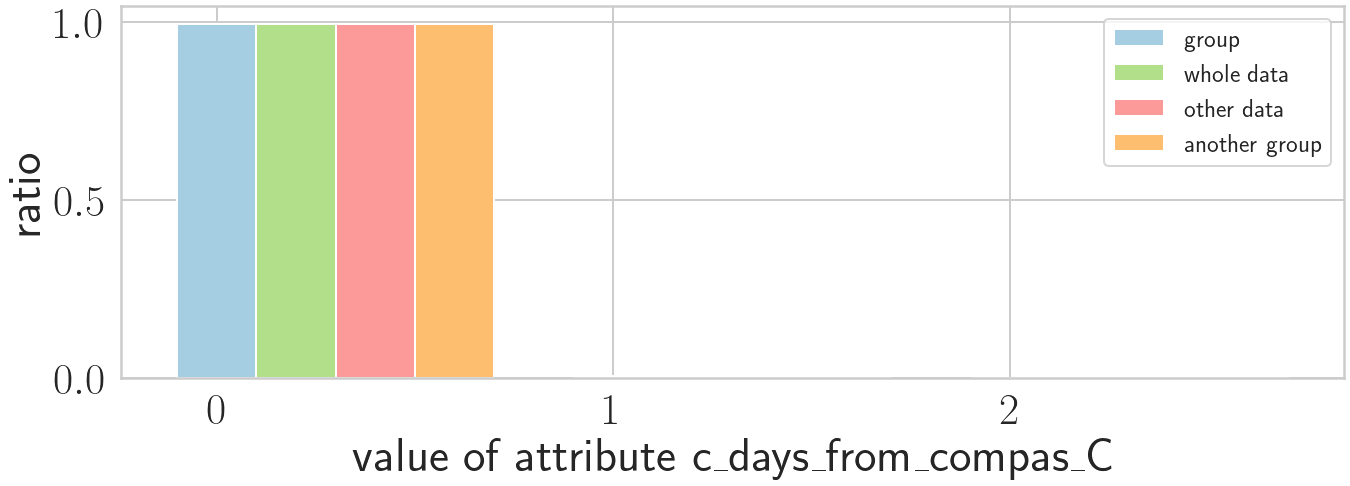

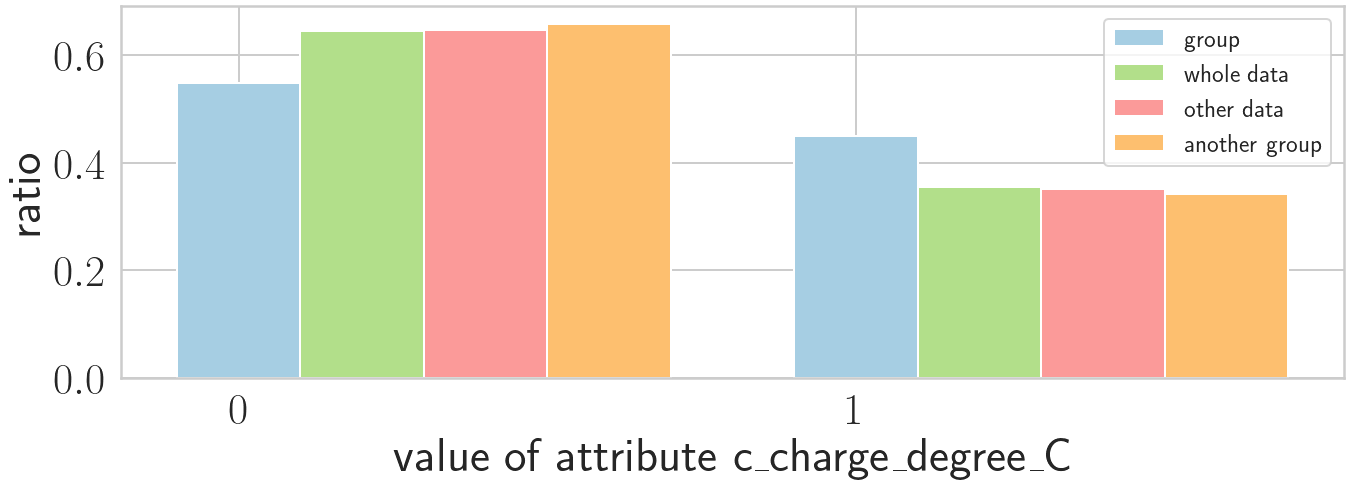

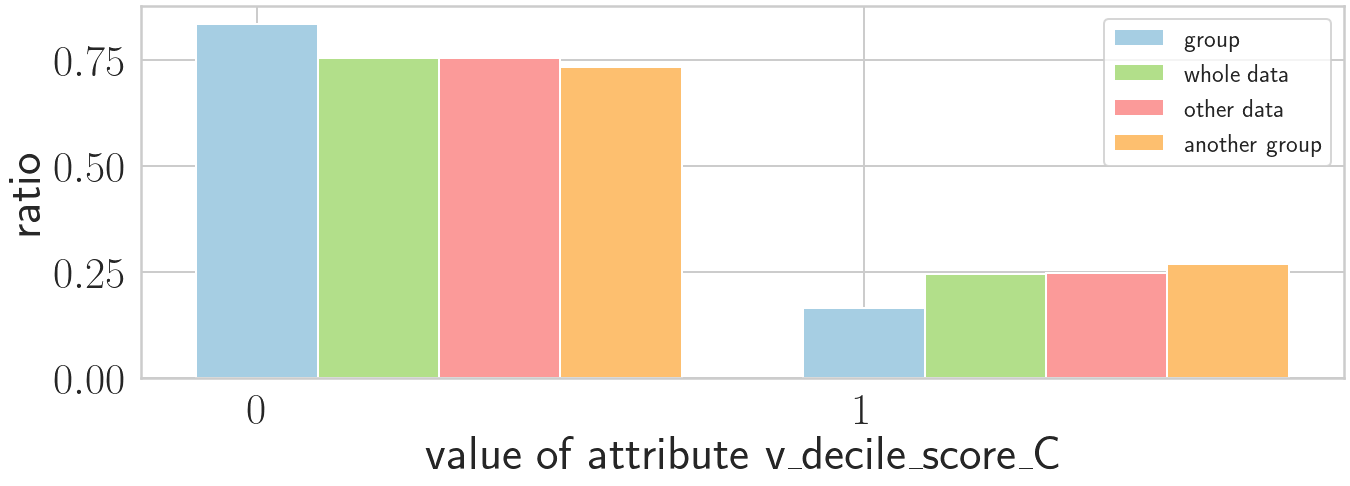

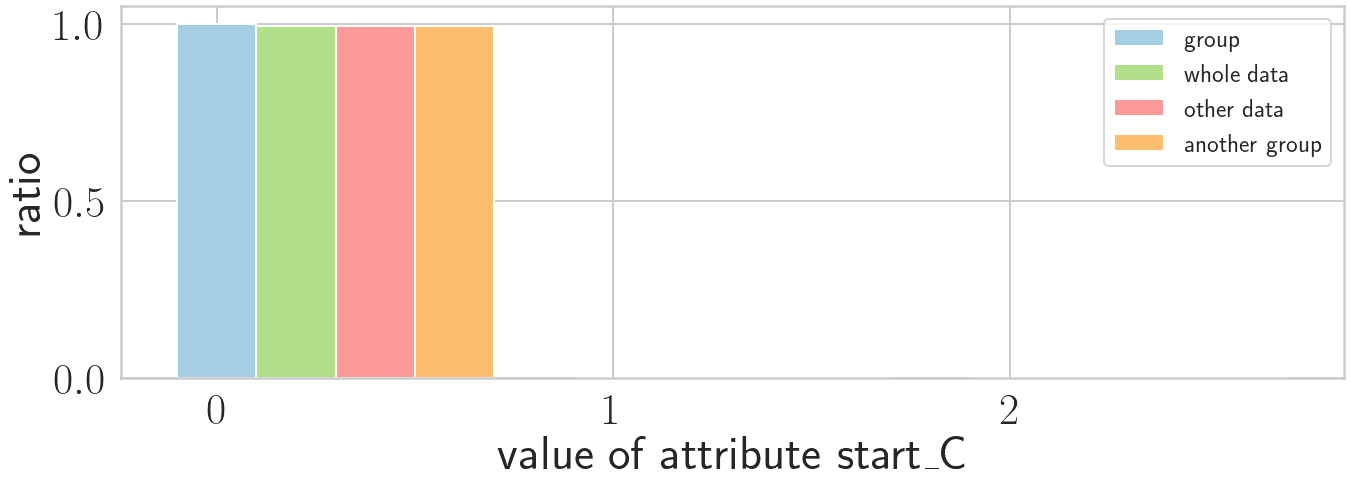

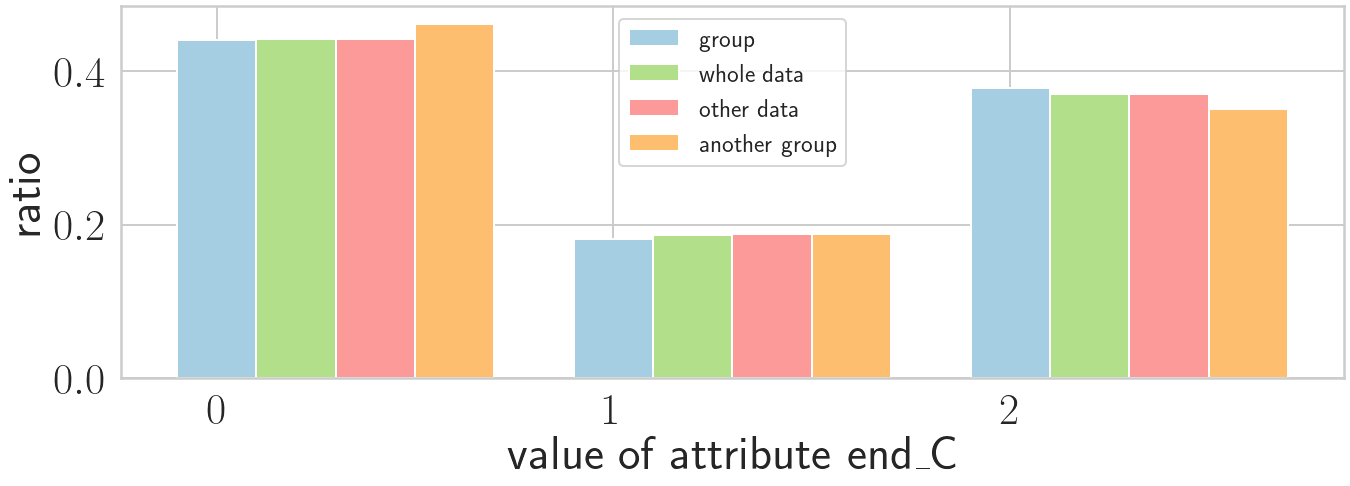

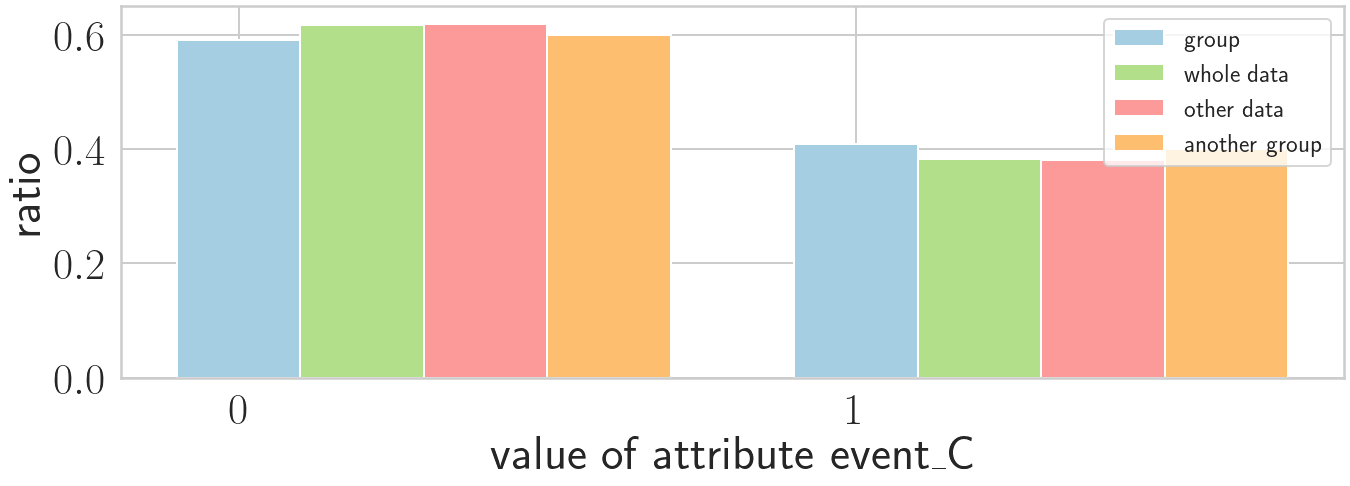

In [158]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))

for att in selected_attributes[3:]:
    plot_distribution_ratio(ranked_data, att, groups_prop_bounds[1], another_group, k)

# german

In [189]:


all_attributes = ['StatusExistingAcc', 'DurationMonth_C', 'CreditHistory', 'Purpose', 'CreditAmount_C',
                  'SavingsAccount', 'EmploymentLength', 'InstallmentRate', 'MarriedNSex', 'Debtors',
                  'ResidenceLength', 'Property', 'Age_C', 'InstallmentPlans', 'Housing',
                  'ExistingCredit', 'Job', 'NumPeopleLiable', 'Telephone', 'ForeignWorker']



original_data_file = r"../../../InputData/GermanCredit/GermanCredit_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)

# scoring attributes:
# I guess they are 'DurationMonth_C', 'CreditAmount_C'


# all att

In [190]:

selected_attributes = all_attributes

k = 50
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


[11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 32, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 9, -1, -1, -1, -1, -1

In [191]:
selected_attributes = all_attributes

alpha = 0.8
k = 50
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 6.717156887054443
finish kmin
[-1, -1, -1, -1, -1, -1, 74, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[11, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 152, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 103, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 93, 101, -1, -1, -1, 143, 152, -1, -1, 2, -1, 201]
[-1, -1, -1, -1, 2, -1, -1, -1, -1, 101, -1, -1, -1, -1, 152, -1, 173, -1, 192, -1]
[11, -1, -1, -1, -1, -1, -1, -1, 93, 101, -1, -1, -1, -1, 152, -1, -1, -1, -1, -1]
[14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, 2, -1, -1, -1, -1]
[-1, -1, -1, 0, -1, -1, -1, -1, 93, -1, -1, -1, -1, -1, -1, -1, 173, -1, -1, 201]
[-1, -1, 34, -1, -1, 61, -1, -1, -1, -1, -1, -1, -1, -1, 152, 2, -1, -1, -1, 201]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 151, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 2, -1, -1, -1, -1, 101, -1, -1, 2, -1, -1, -1, -1, 1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [164]:

x = ranked_data[selected_attributes]
y = ranked_data['rank']

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

StatusExistingAcc = 1.71365
DurationMonth_C = -99.34199
CreditHistory = -3.31579
Purpose = -0.39853
CreditAmount_C = 33.6728
SavingsAccount = -2.74288
EmploymentLength = -140.81162
InstallmentRate = 67.05954
MarriedNSex = 4.65879
Debtors = -2.8357
ResidenceLength = -138.92916
Property = -1.98318
Age_C = 9.53163
InstallmentPlans = 7.44224
Housing = 0.71899
ExistingCredit = -116.76937
Job = -48.39825
NumPeopleLiable = 5.24946
Telephone = 6.99837
ForeignWorker = 45.65932


Permutation explainer: 1001it [00:17, 26.86it/s]                         


.values =
array([[ -1.19955383, -81.46043256,  -1.09421144, ...,  -0.62993564,
          4.33899155,  -2.7395592 ],
       [ -2.91320215, -81.46043256,  -4.41000369, ...,   4.61952806,
          4.33899155,  -2.7395592 ],
       [ -2.91320215,  17.88155837,  -4.41000369, ...,  -0.62993564,
          4.33899155,  -2.7395592 ],
       ...,
       [ -2.91320215,  17.88155837,   2.22158081, ...,  -0.62993564,
         -2.65938192,  -2.7395592 ],
       [ -2.91320215,  17.88155837,   2.22158081, ...,  -0.62993564,
         -2.65938192,  -2.7395592 ],
       [ -1.19955383,  17.88155837,   2.22158081, ...,  -0.62993564,
          4.33899155,  -2.7395592 ]])

.base_values =
array([519.21321518, 519.21321518, 519.21321518, 519.21321518,
       519.21321518, 519.21321518, 519.21321518, 519.21321518,
       519.21321518, 519.21321518, 519.21321518, 519.21321518,
       519.21321518, 519.21321518, 519.21321518, 519.21321518,
       519.21321518, 519.21321518, 519.21321518, 519.21321518,
       519

In [193]:
another_group = [-1, -1, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc))


True


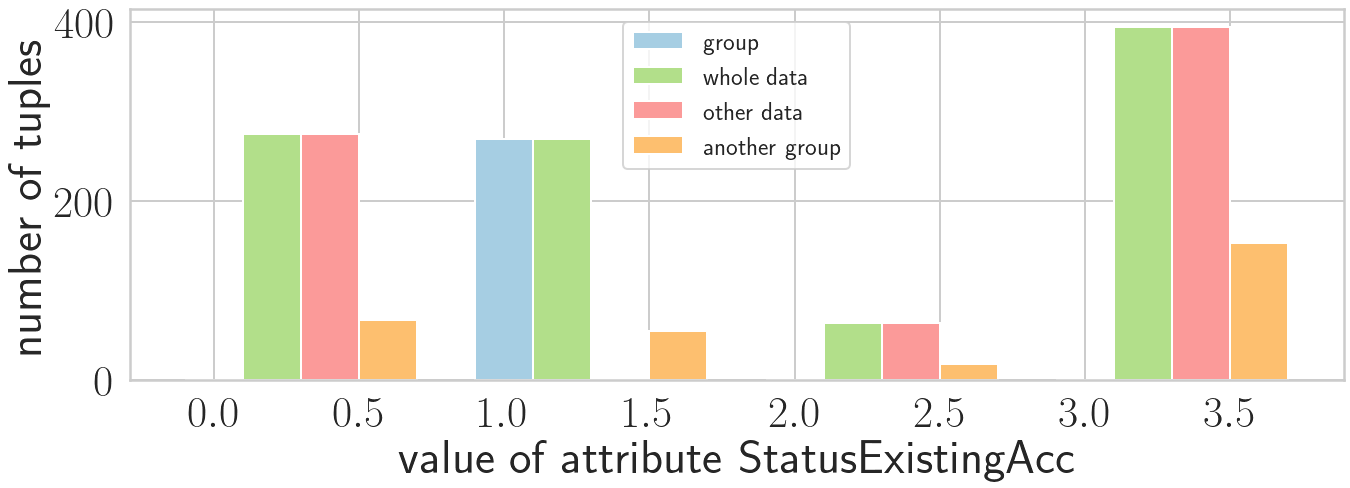

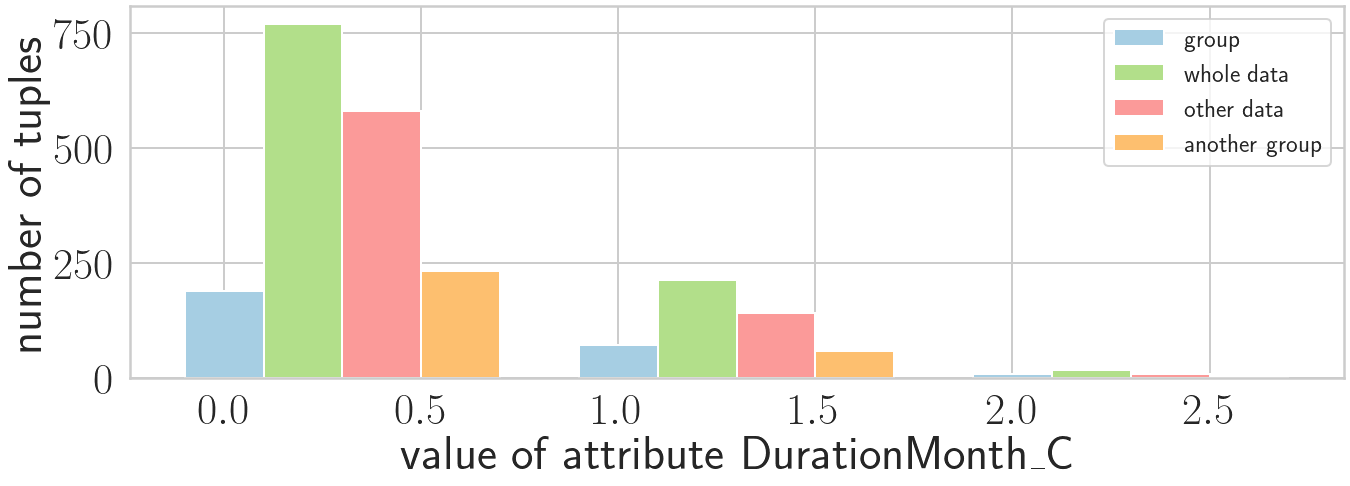

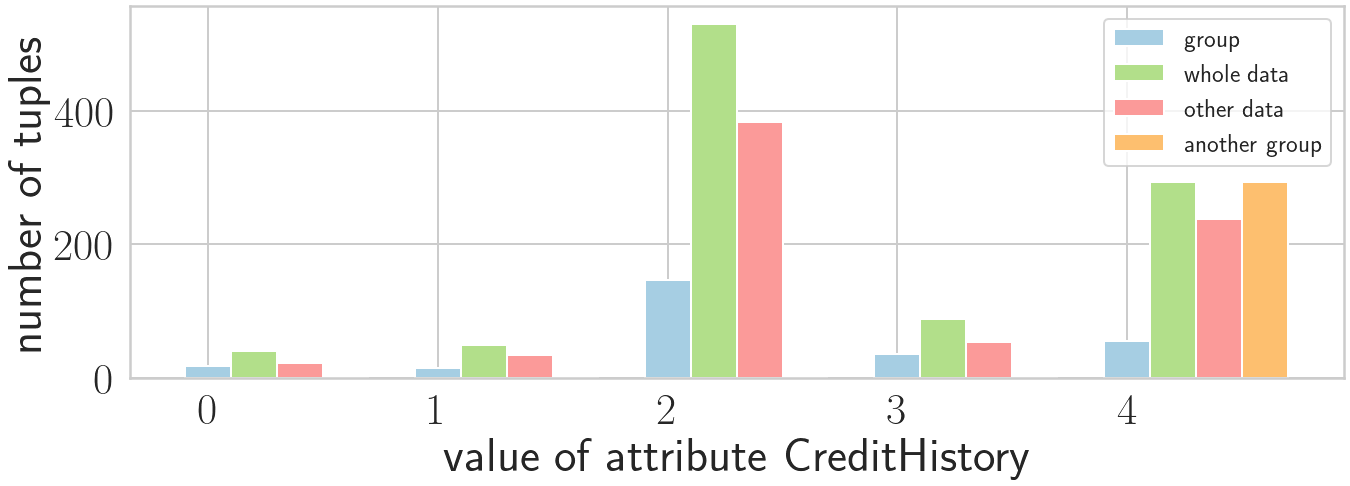

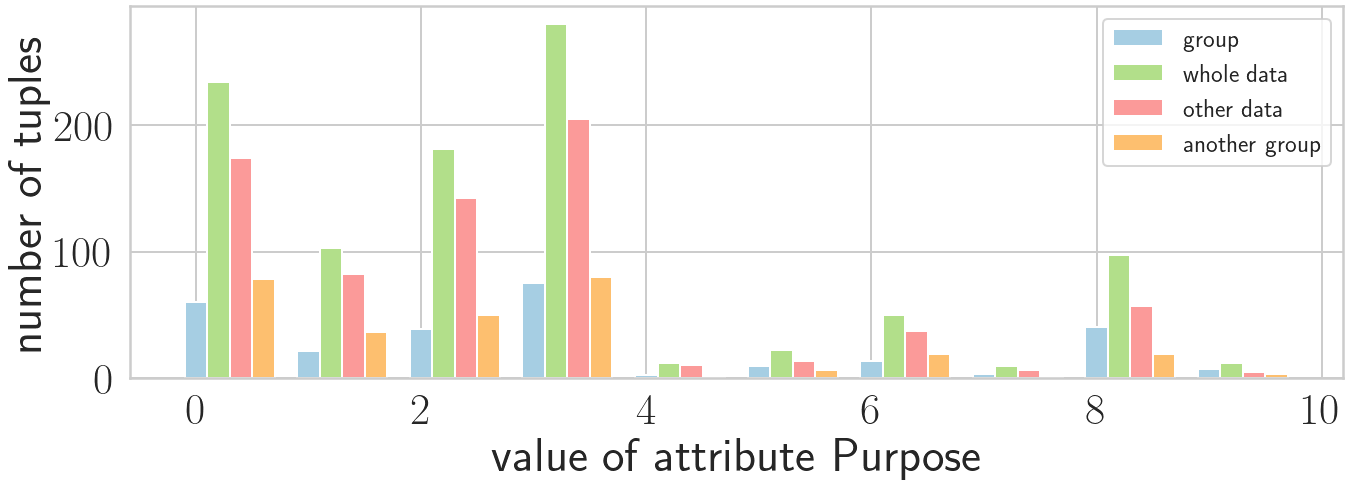

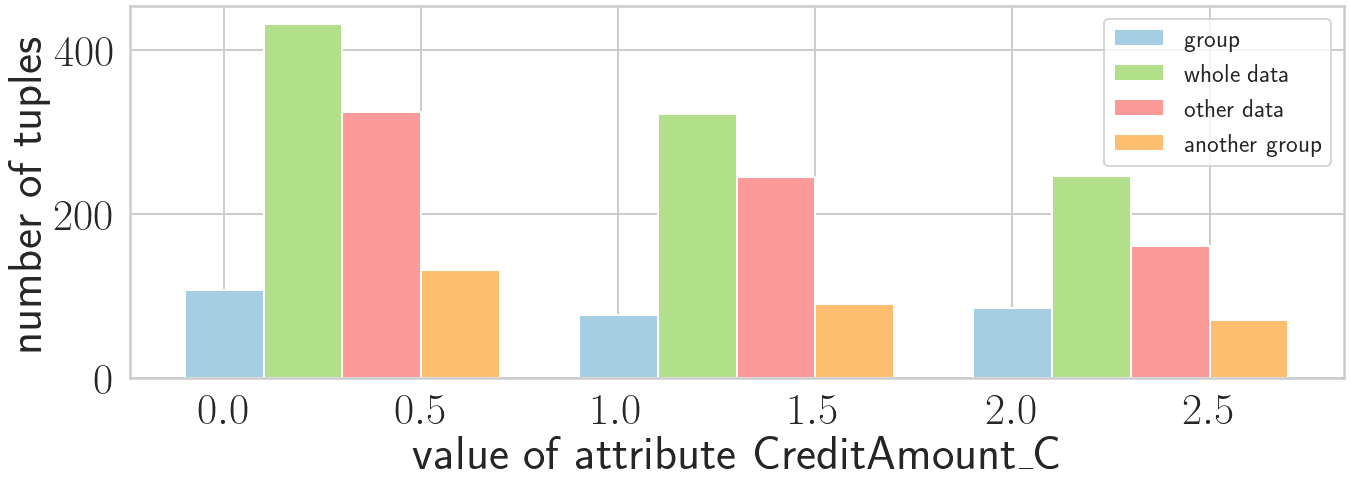

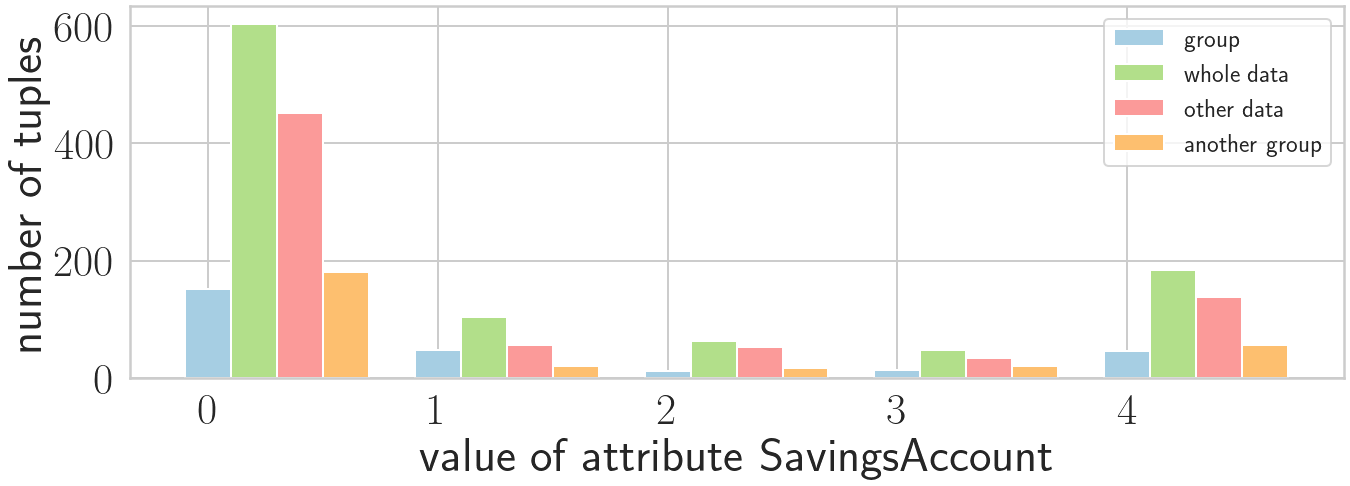

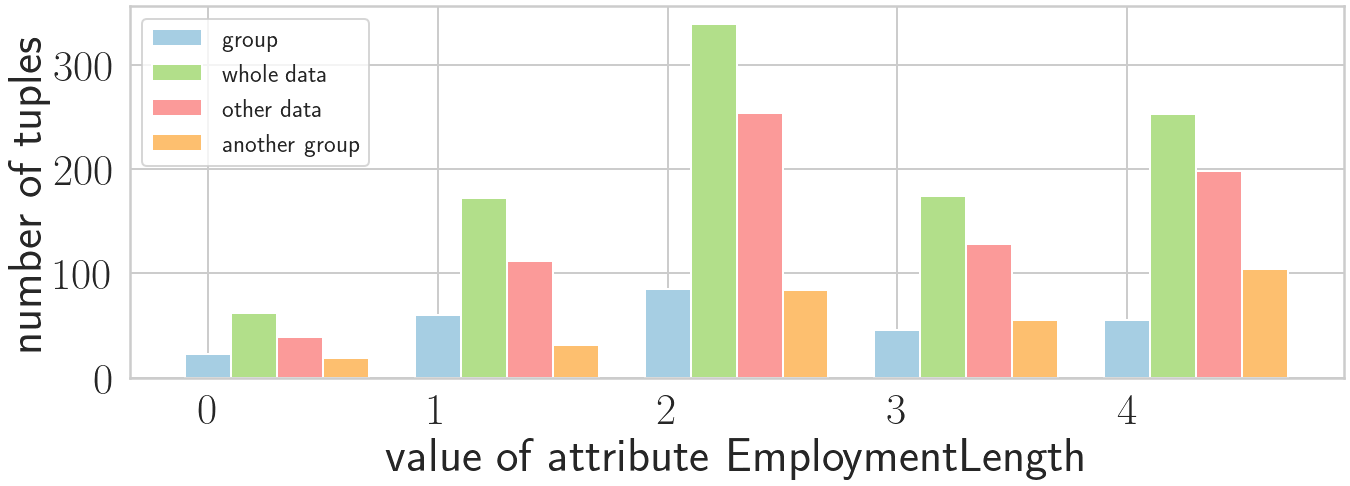

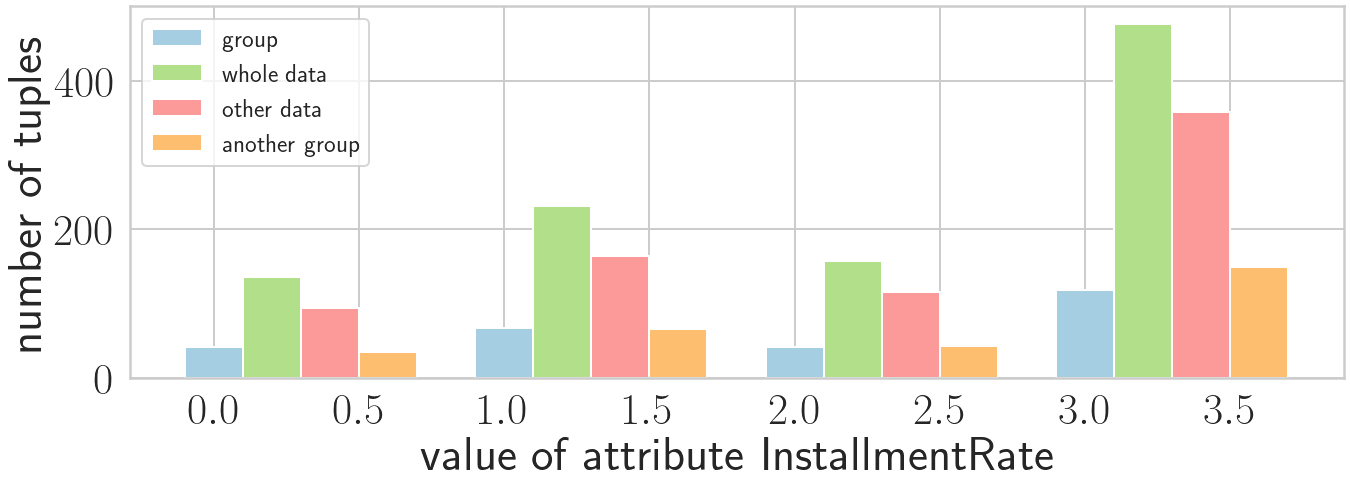

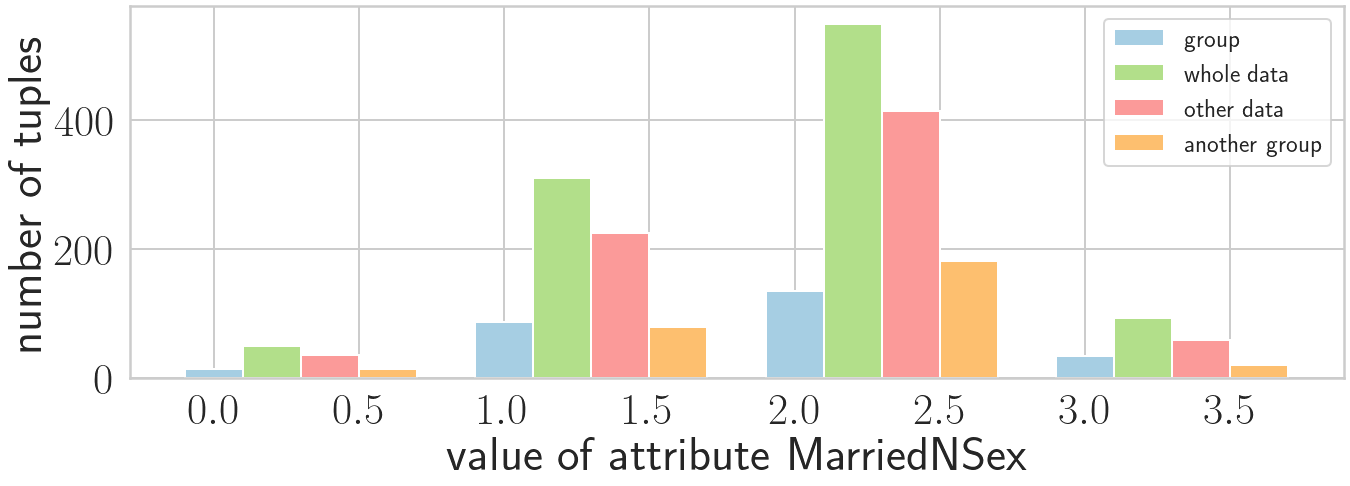

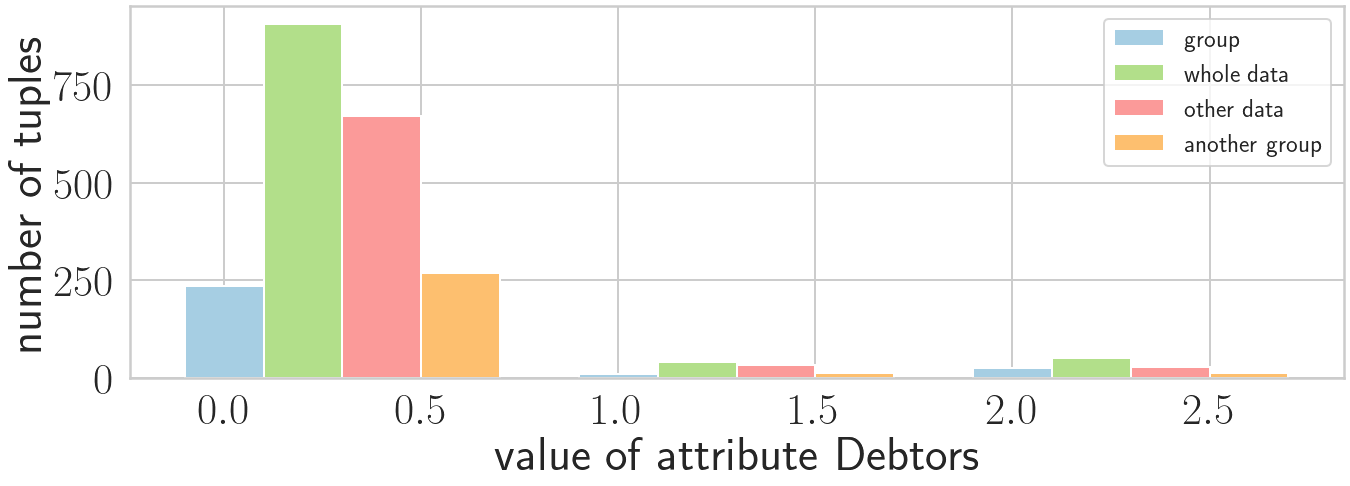

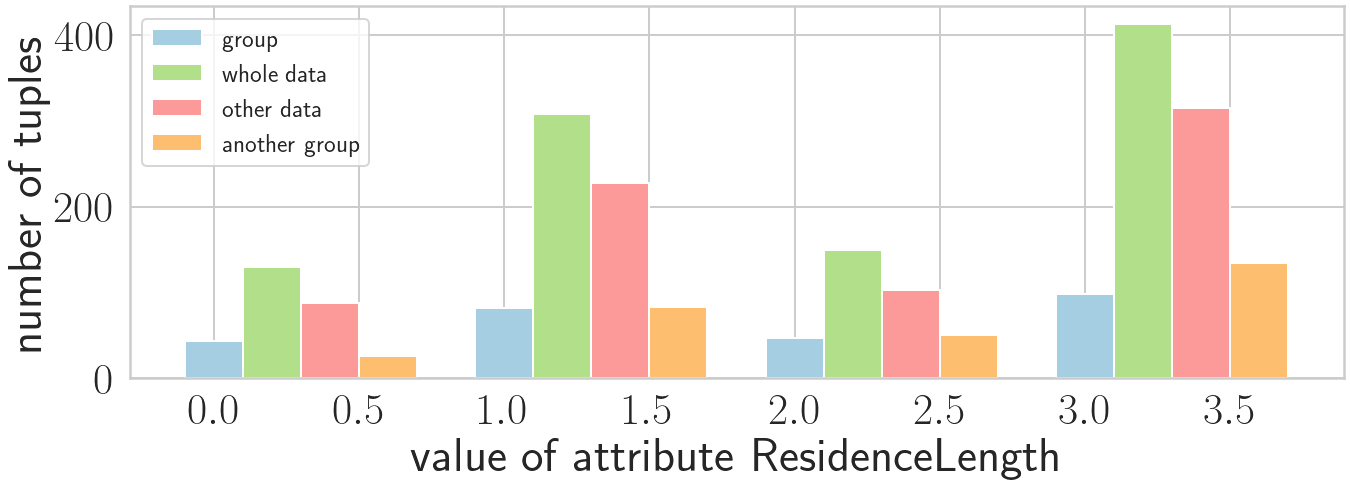

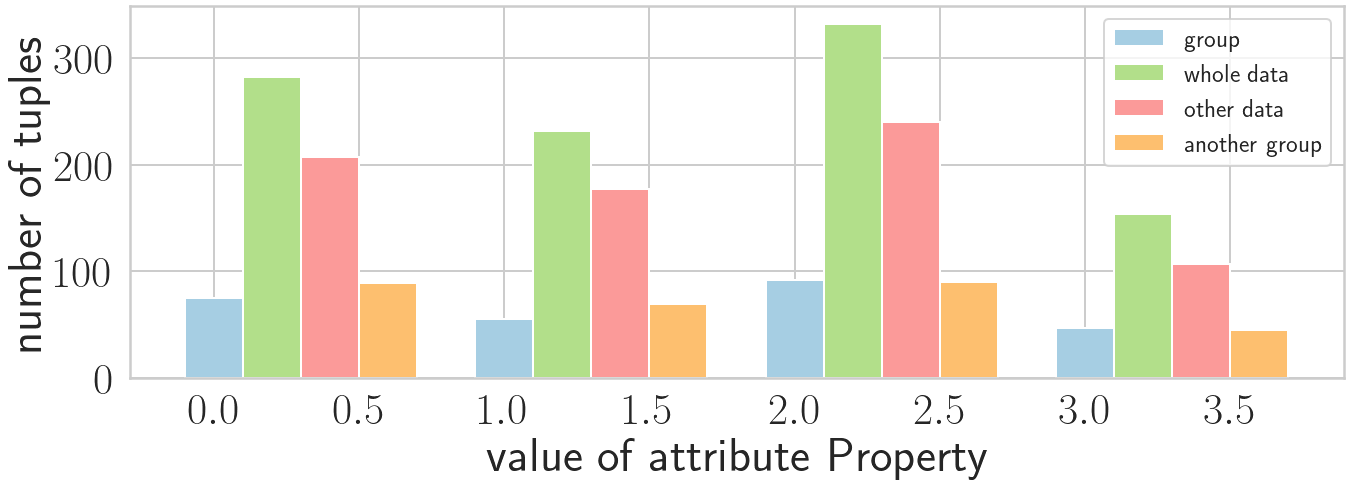

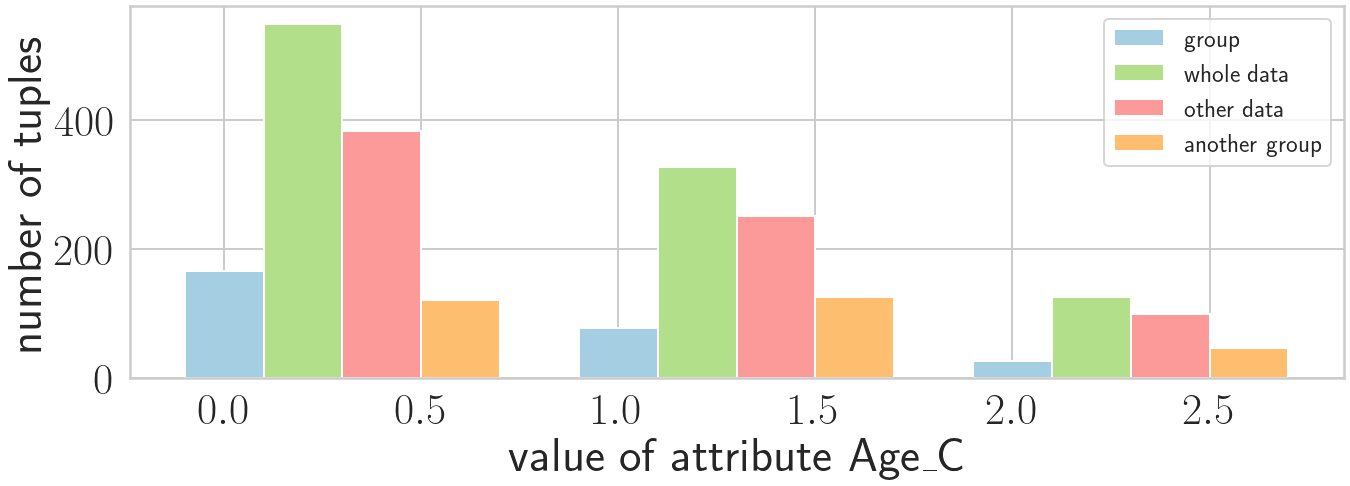

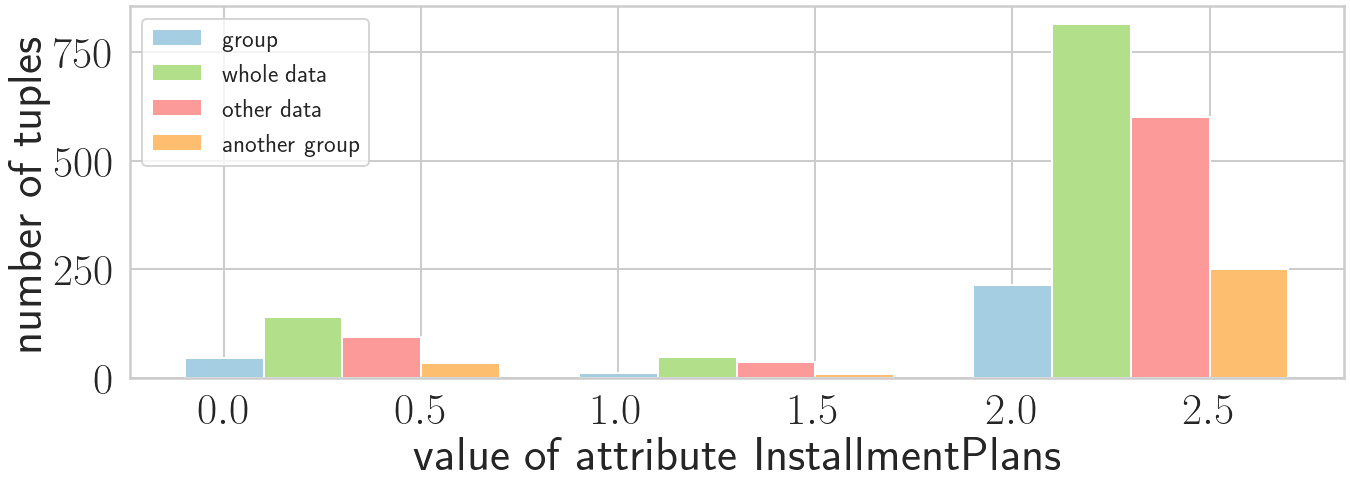

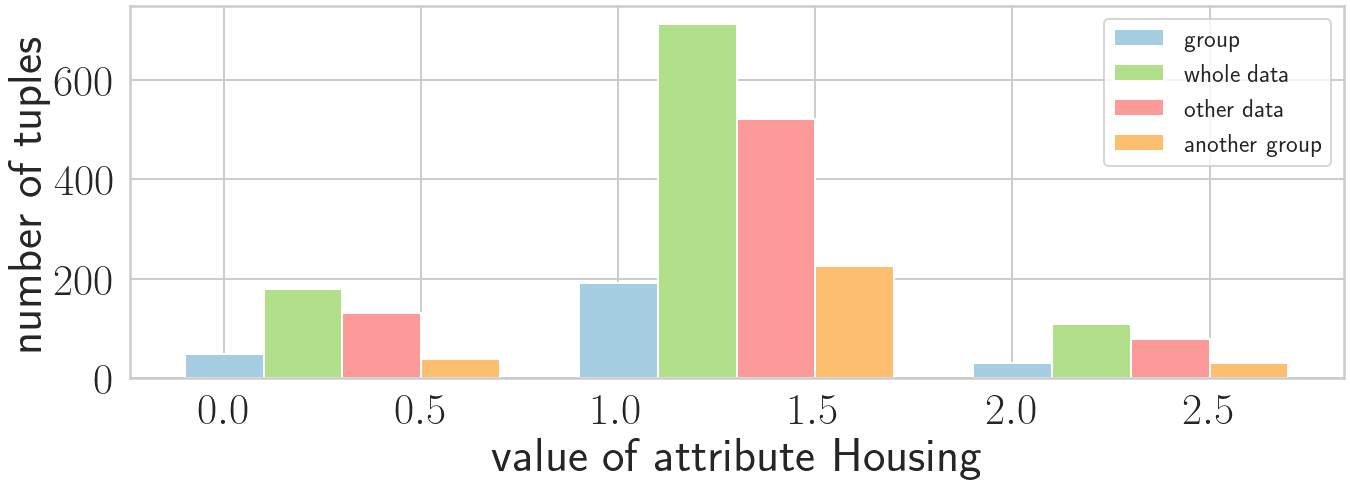

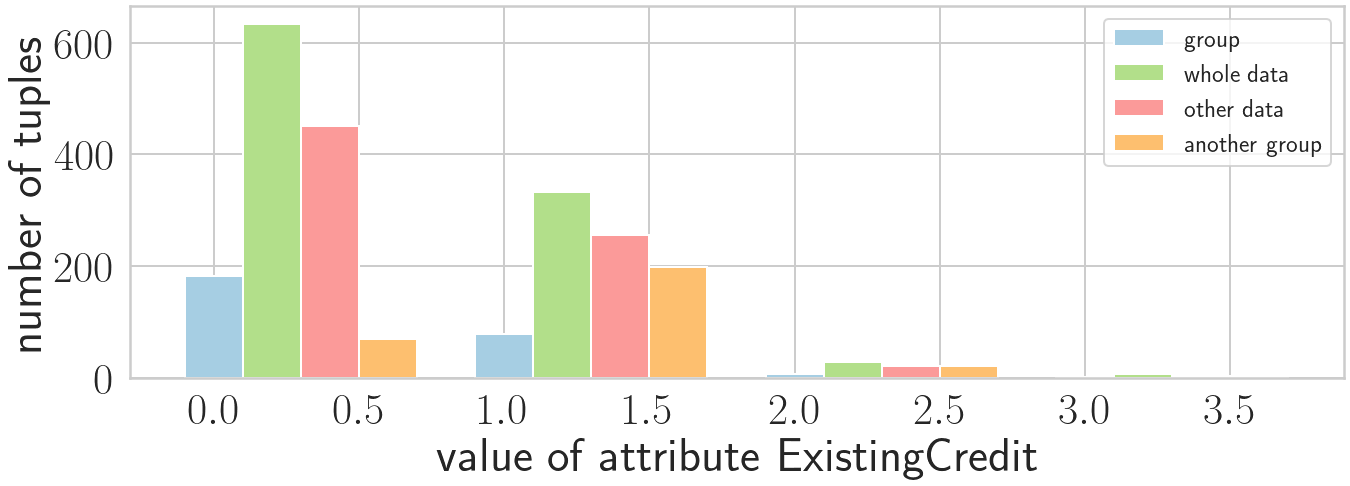

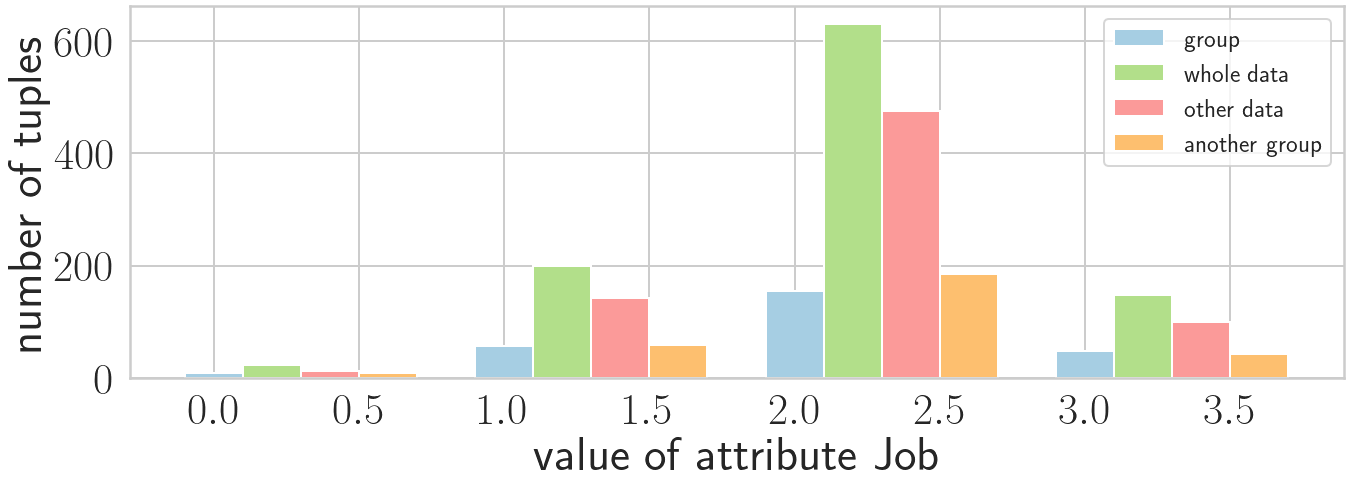

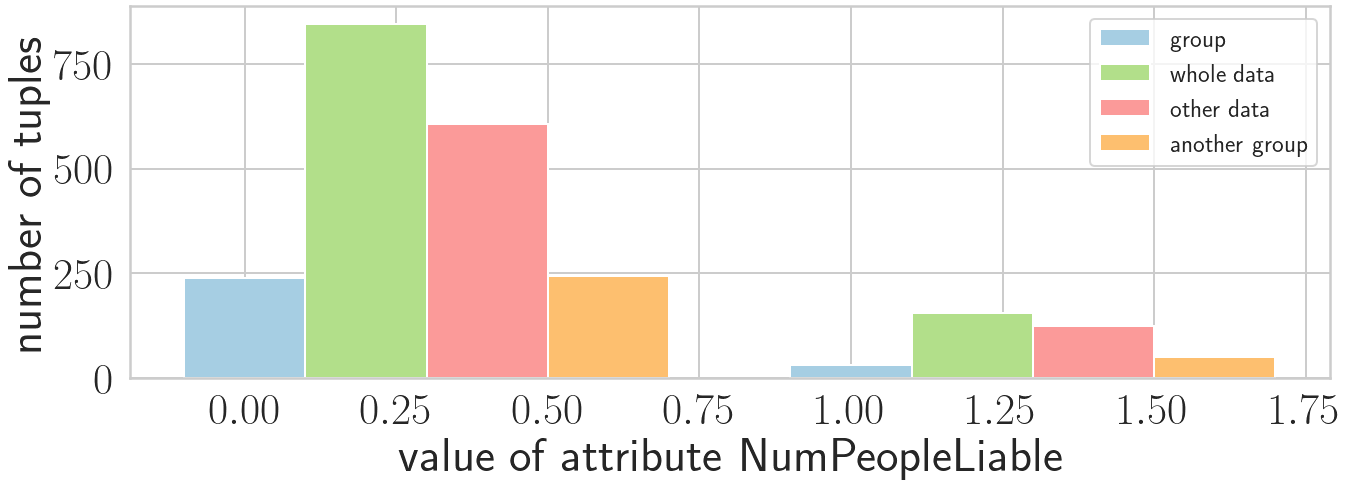

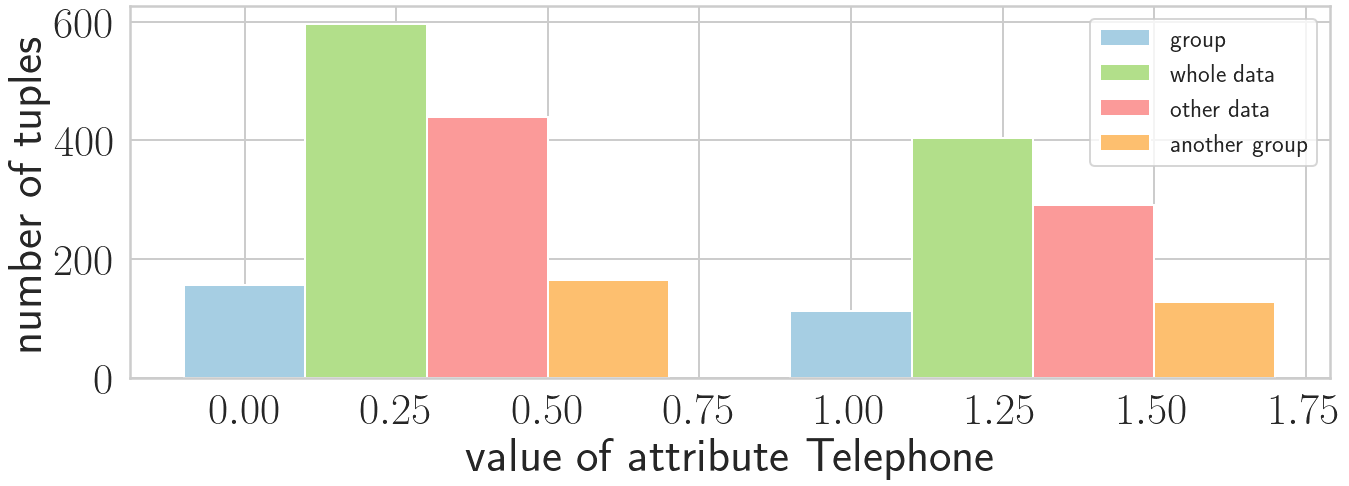

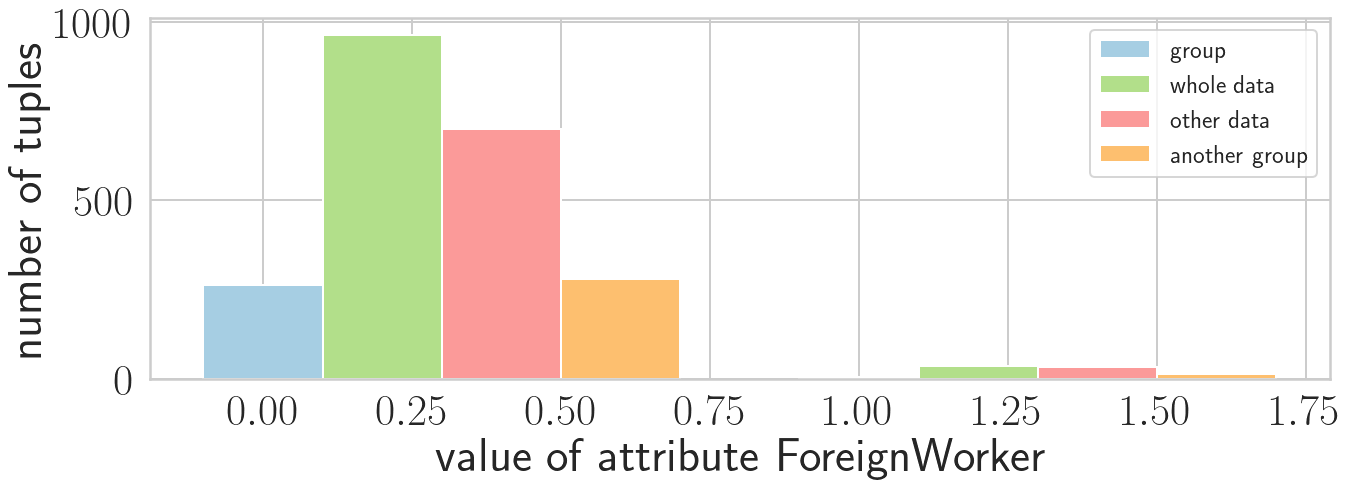

In [194]:
for att in selected_attributes:
    plot_distribution_number(ranked_data, att, groups_global_bounds[1], another_group, k)

True


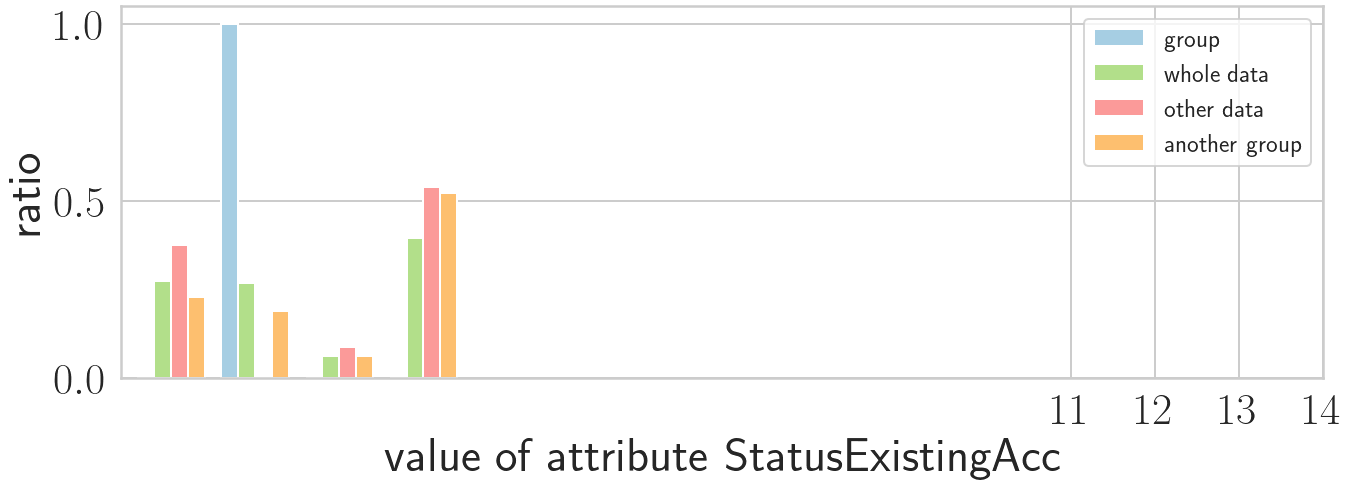

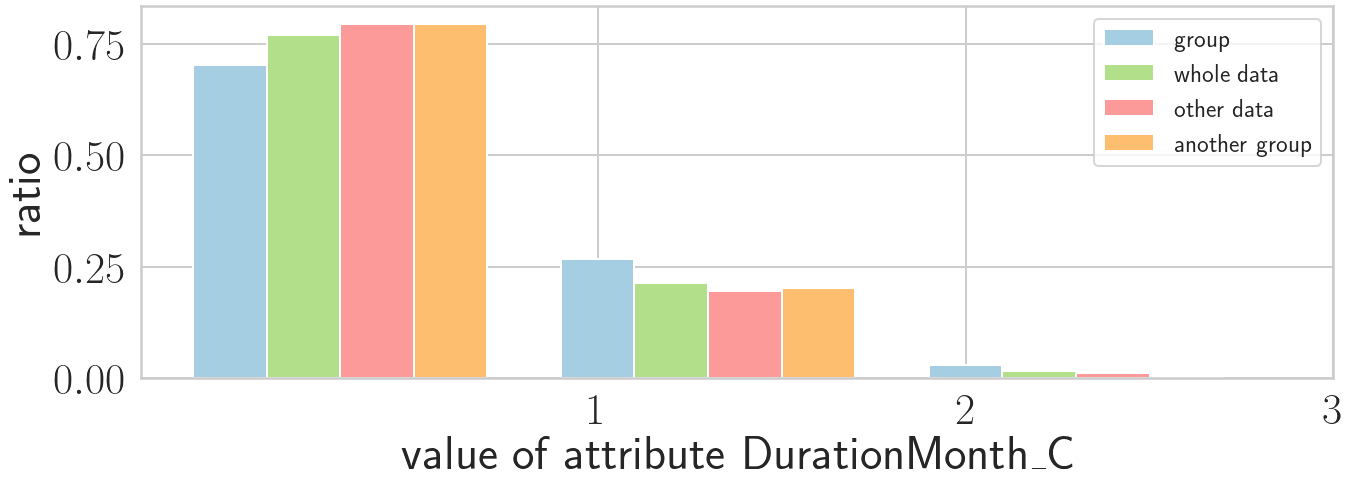

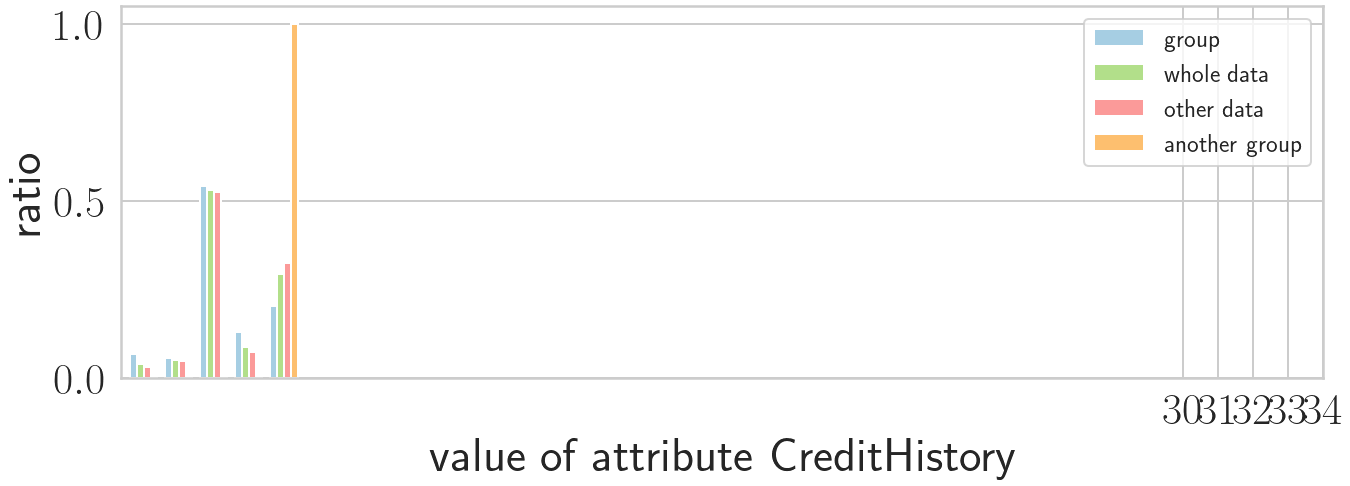

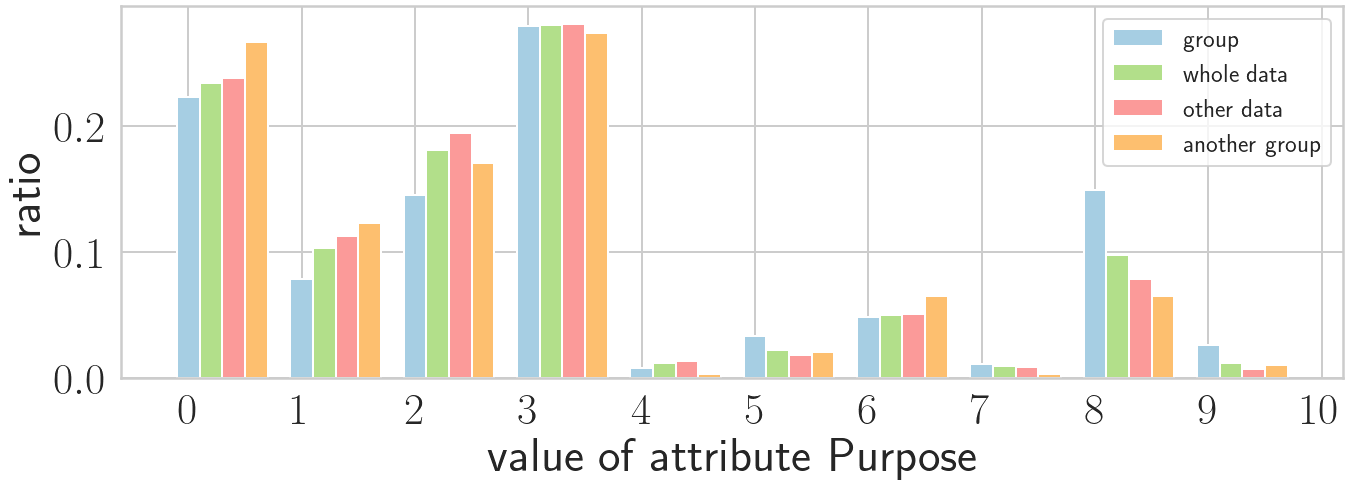

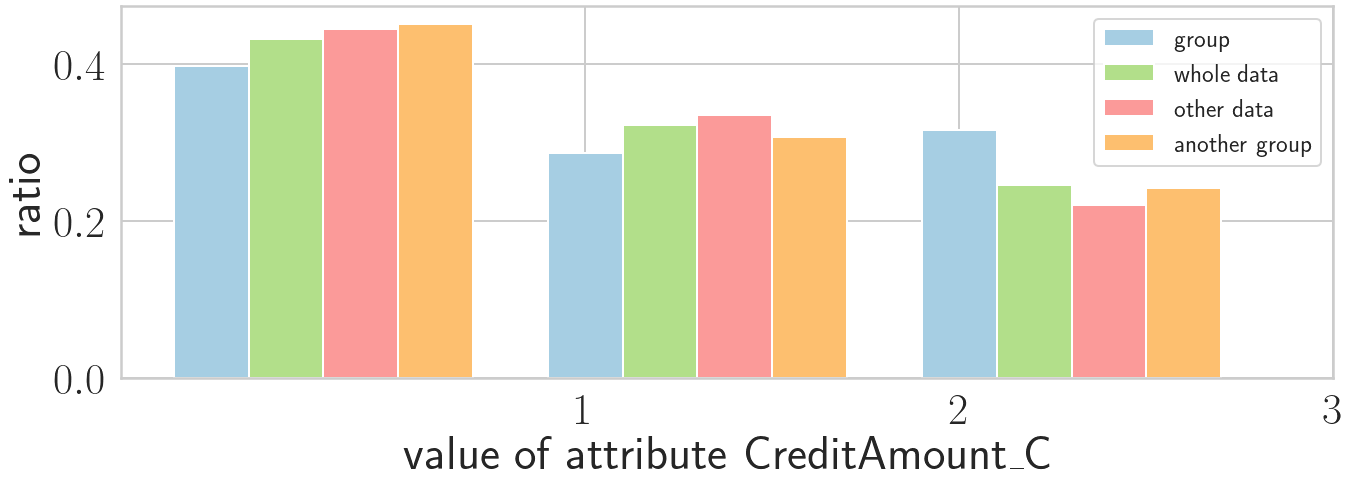

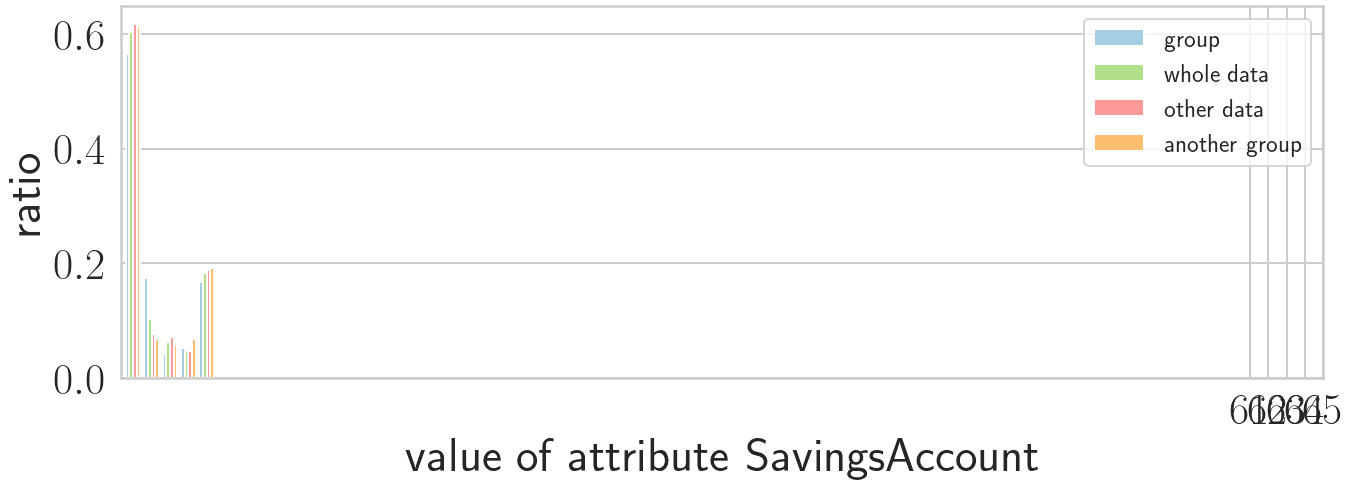

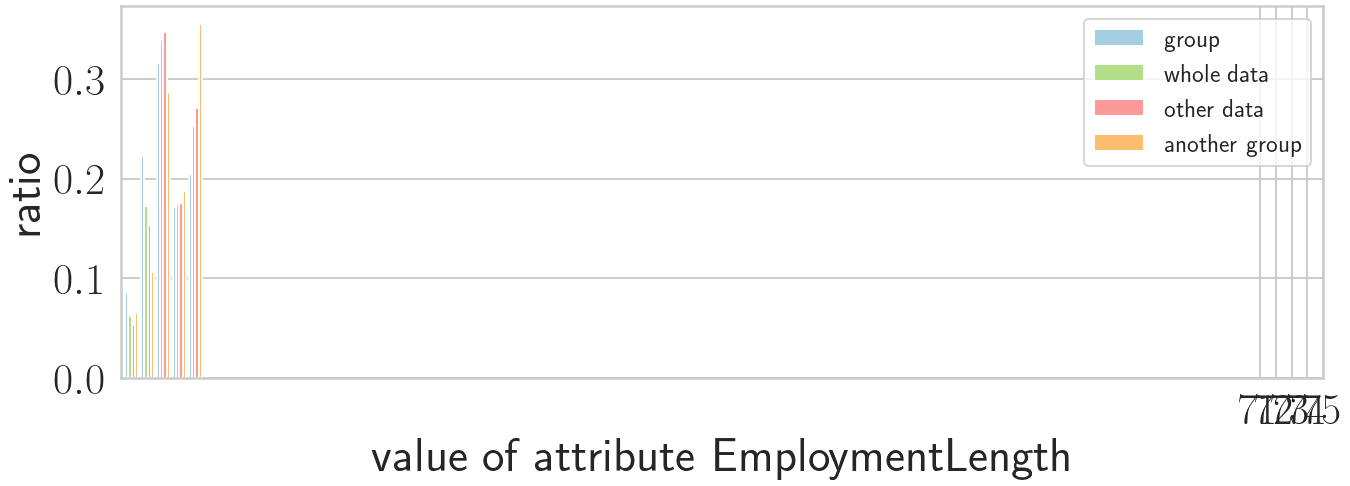

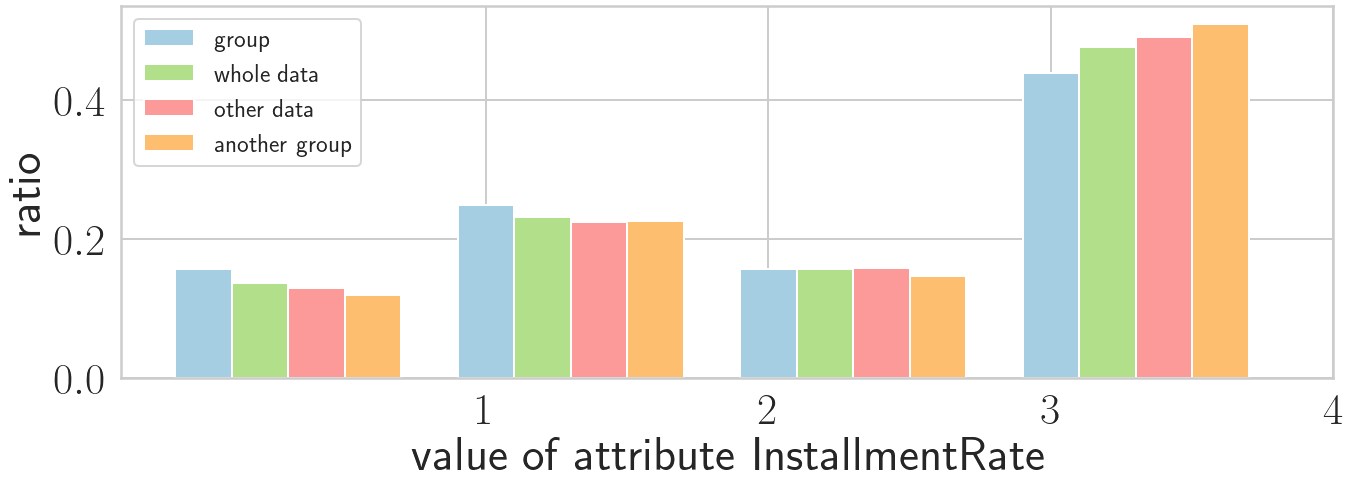

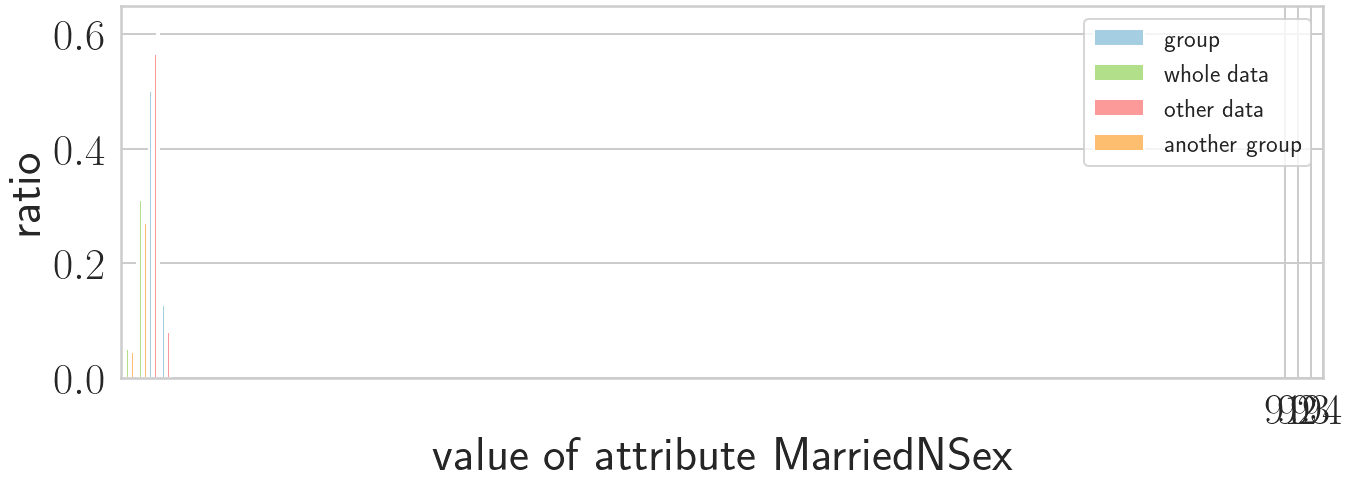

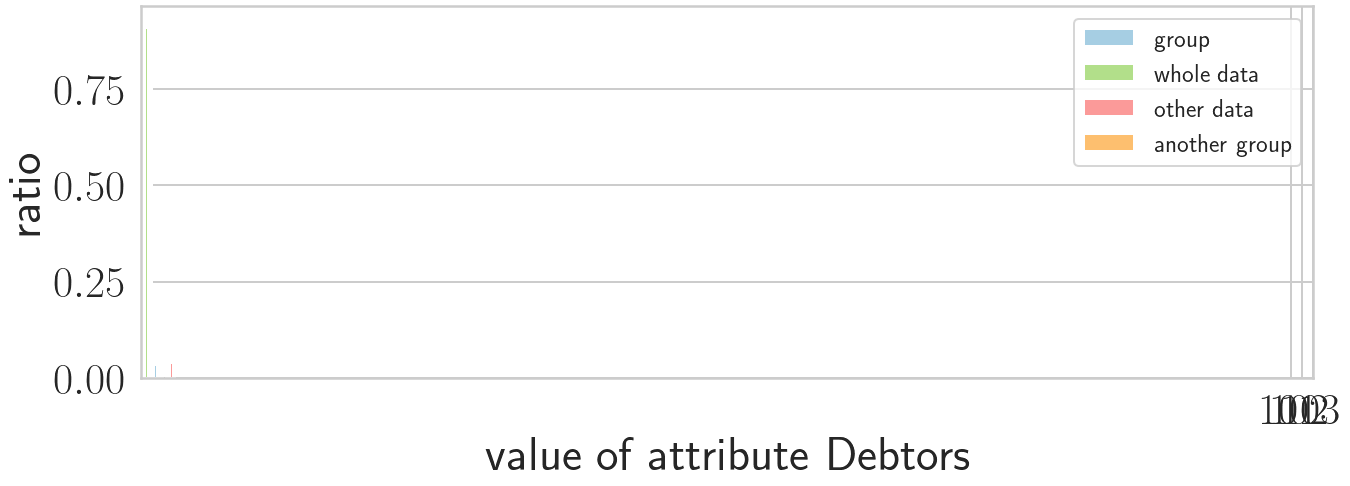

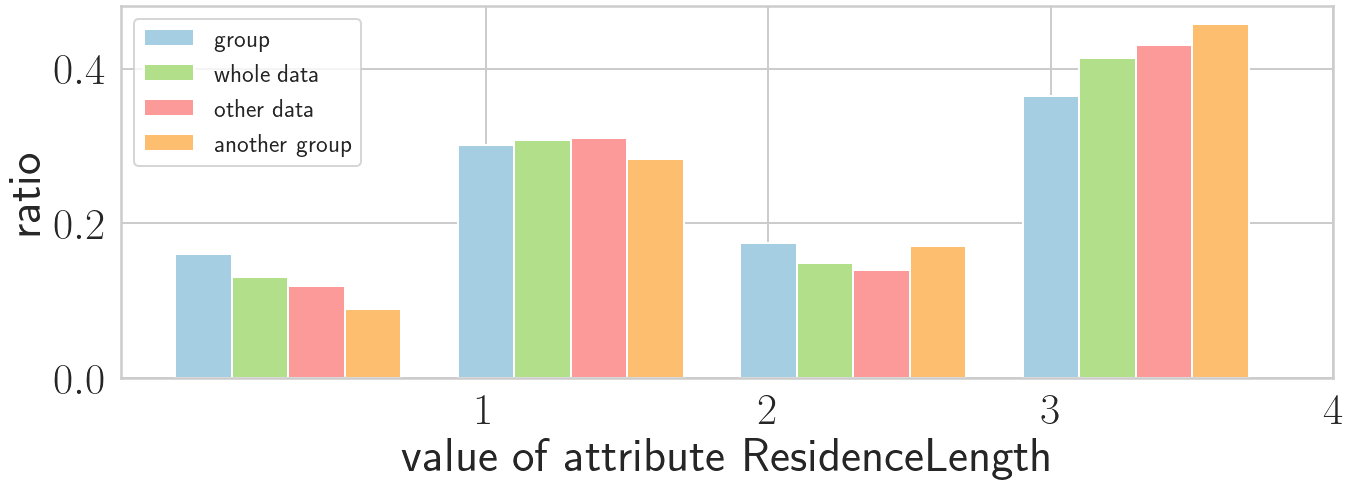

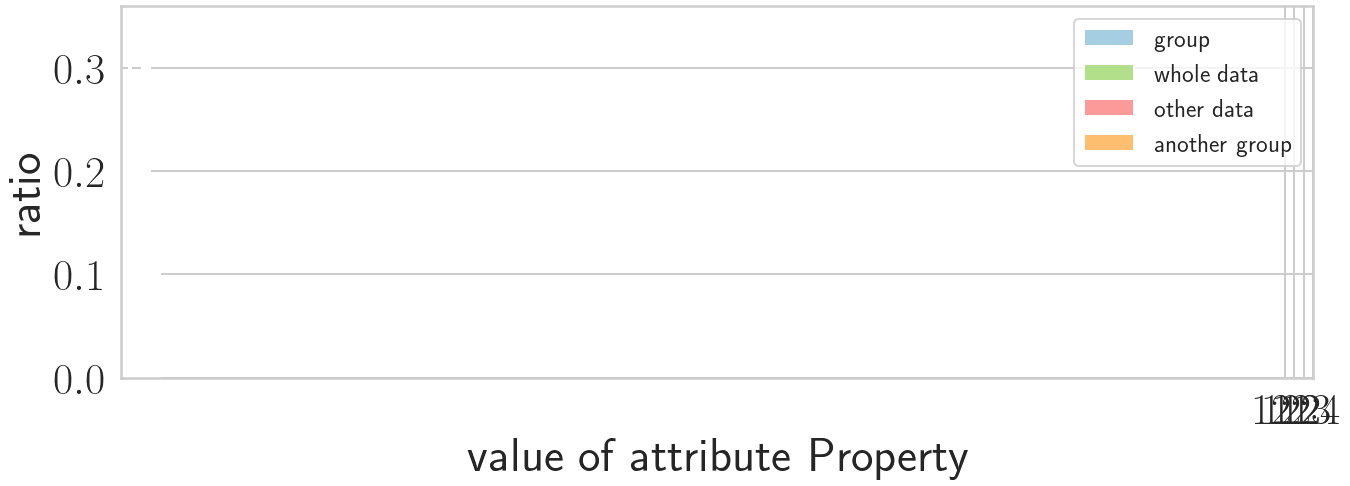

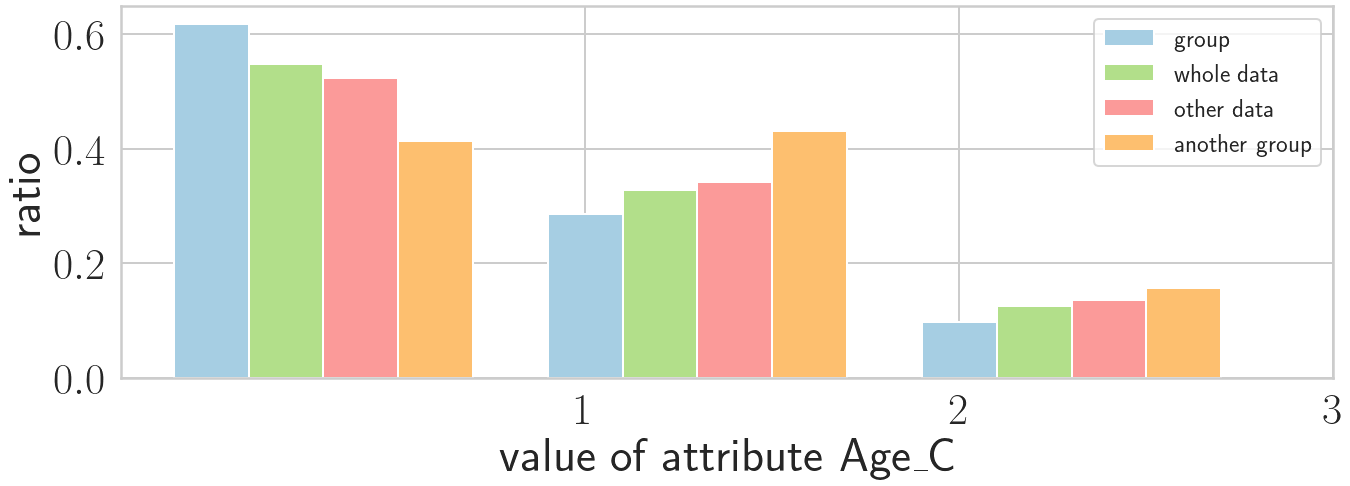

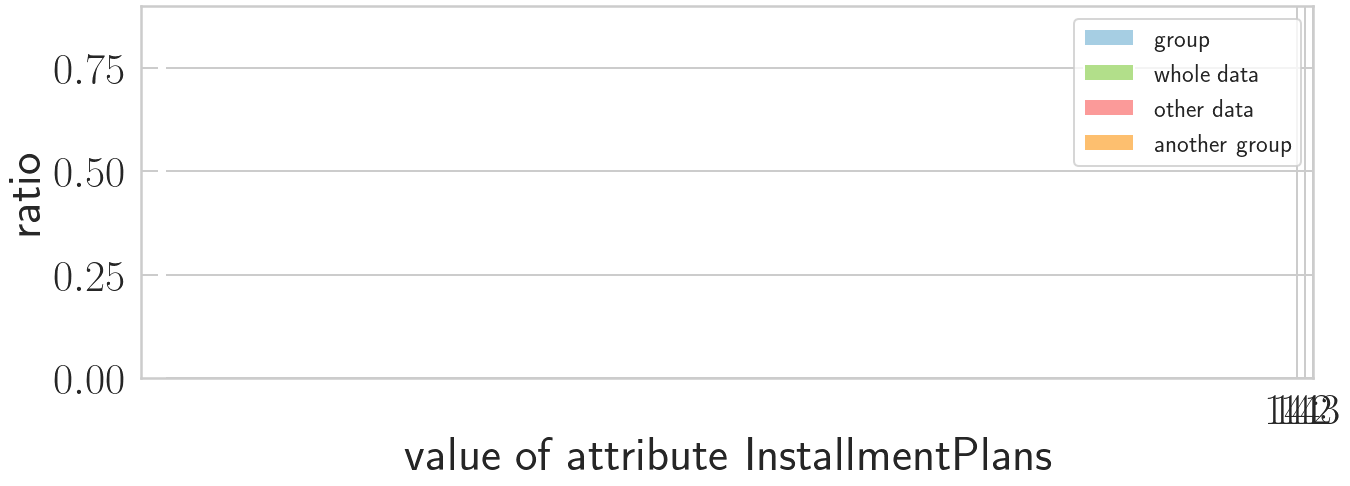

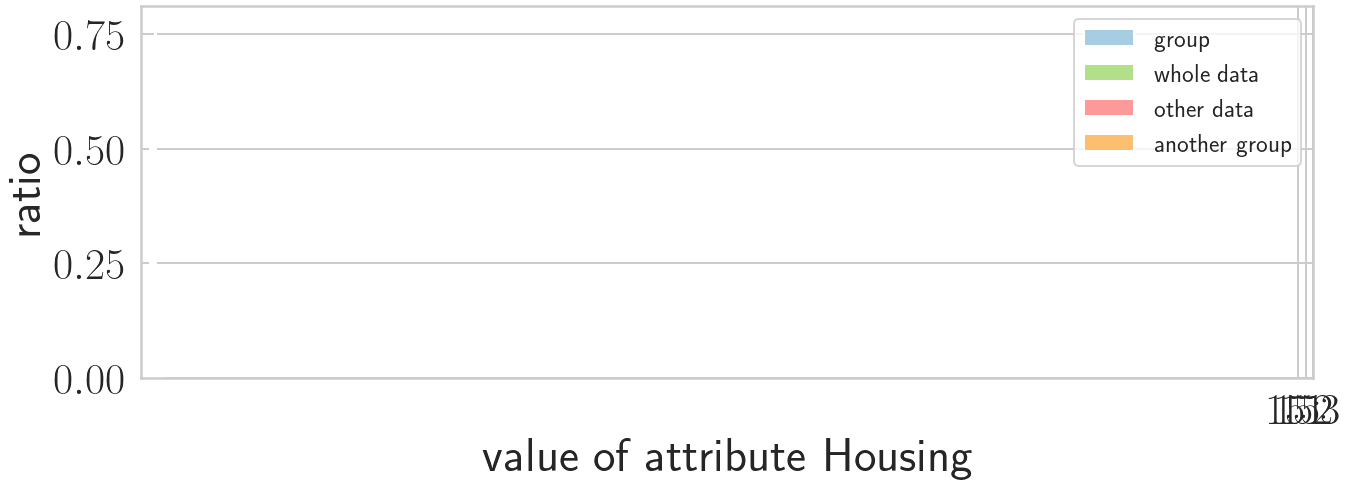

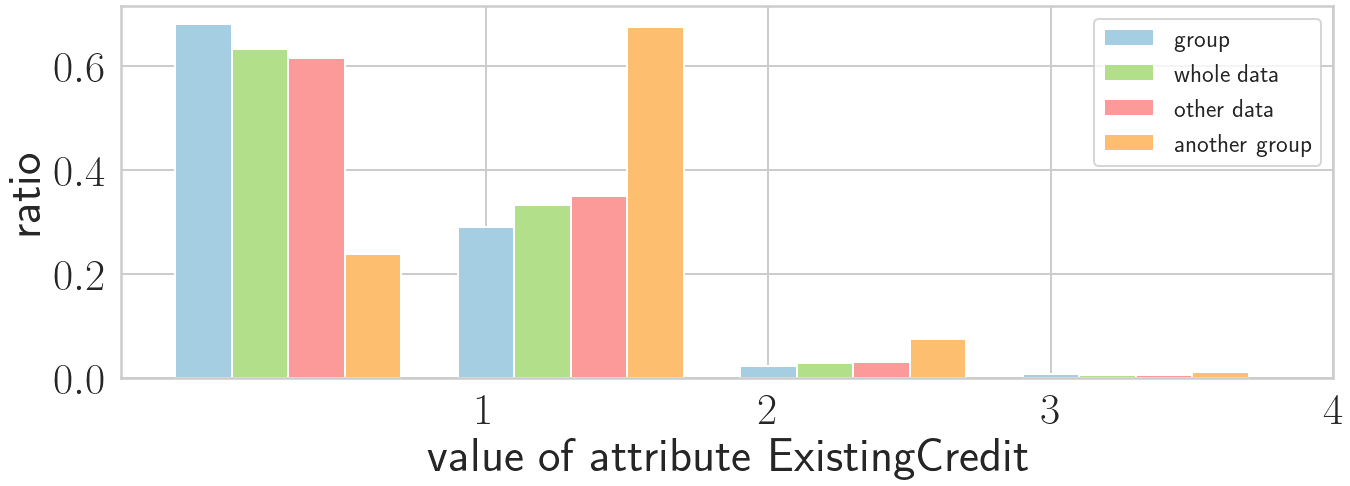

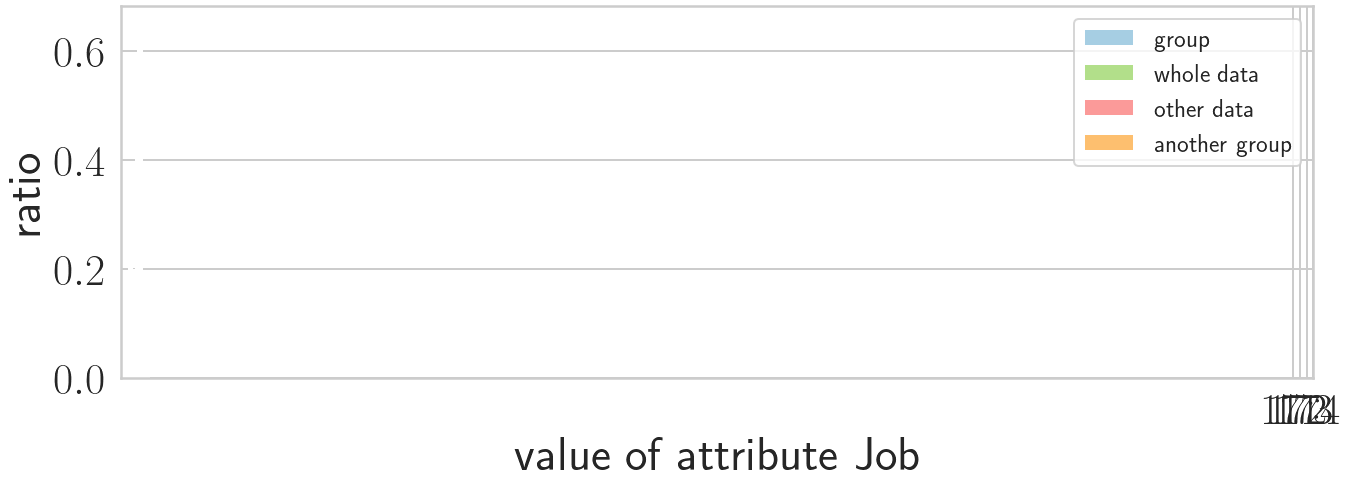

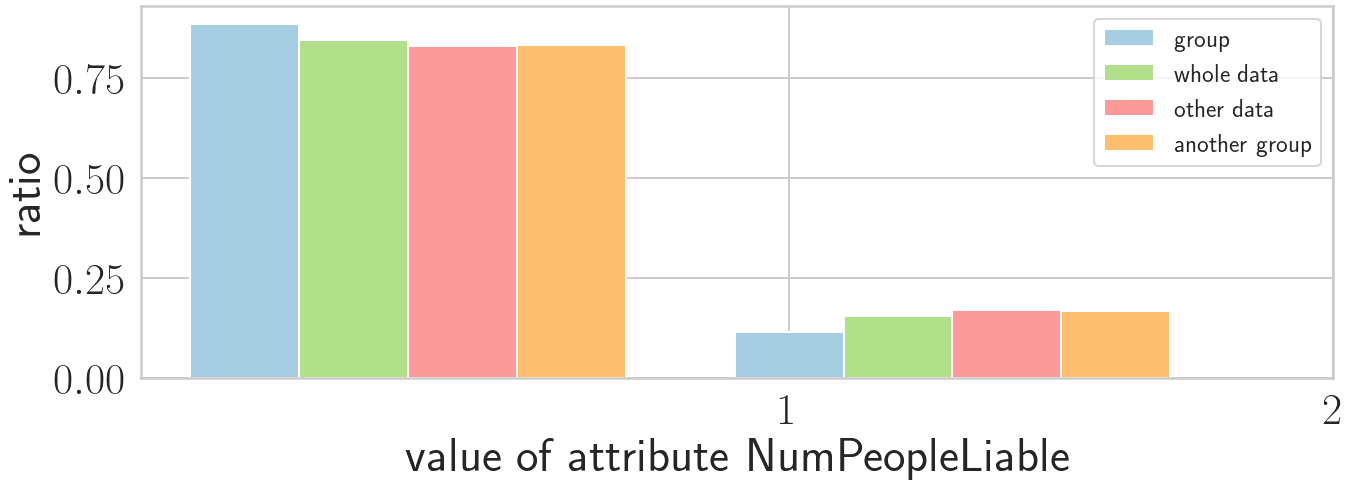

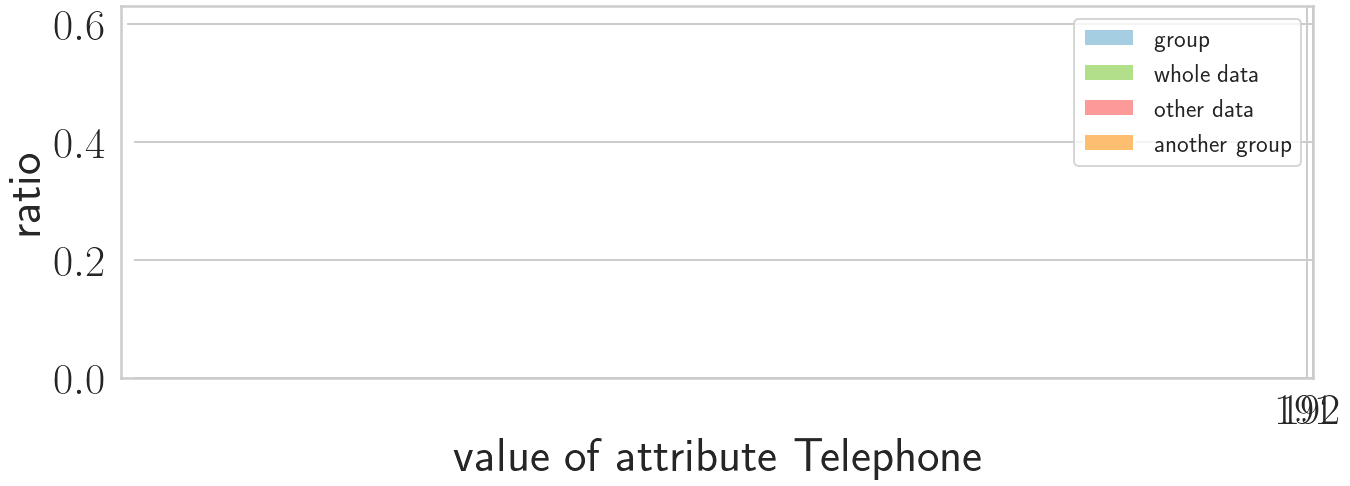

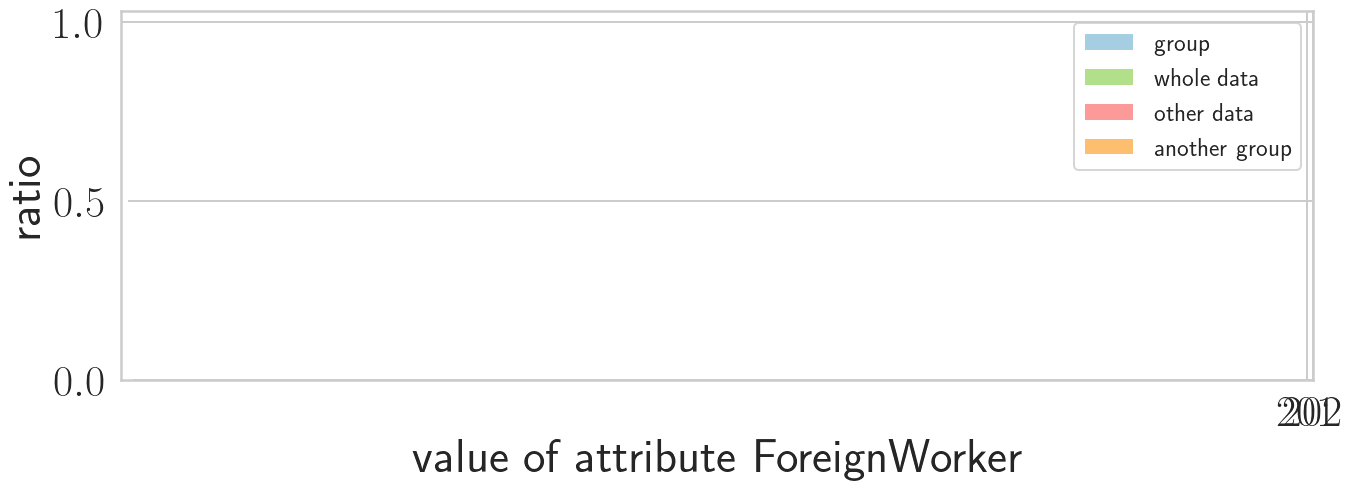

In [195]:
another_group = [-1, -1, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc))
for att in selected_attributes:
    plot_distribution_ratio(ranked_data, att, groups_global_bounds[1], another_group, k)

In [196]:
another_group = [14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))


159 7 6.36
True


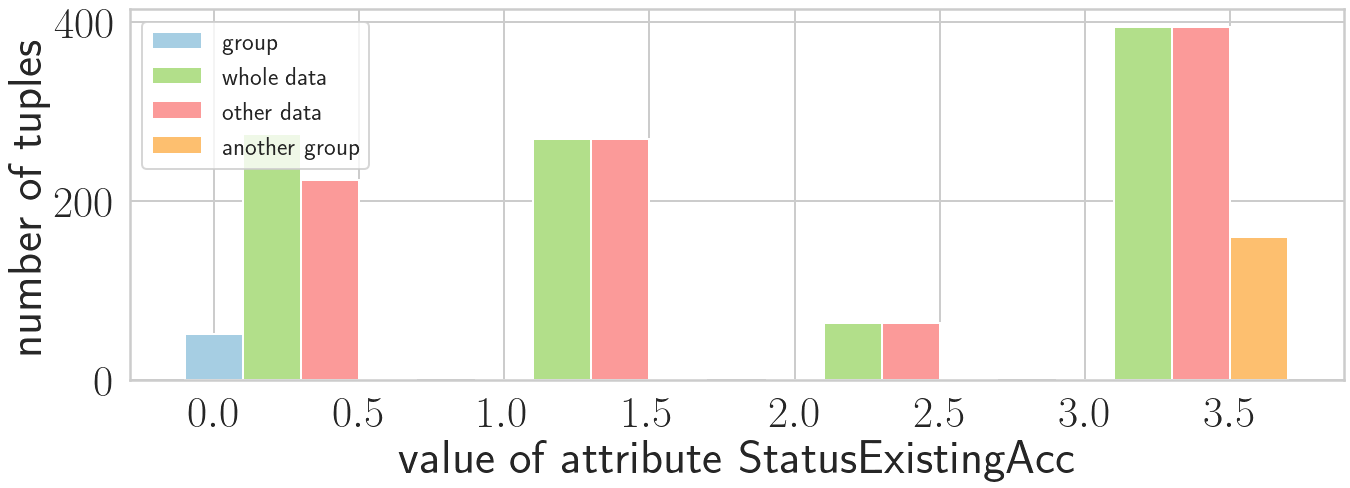

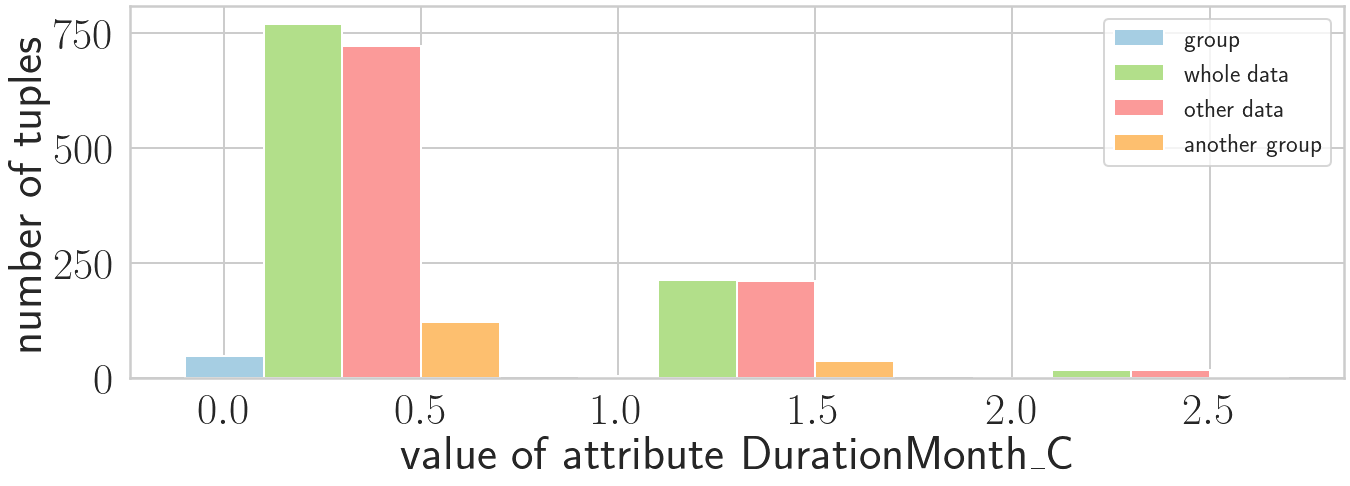

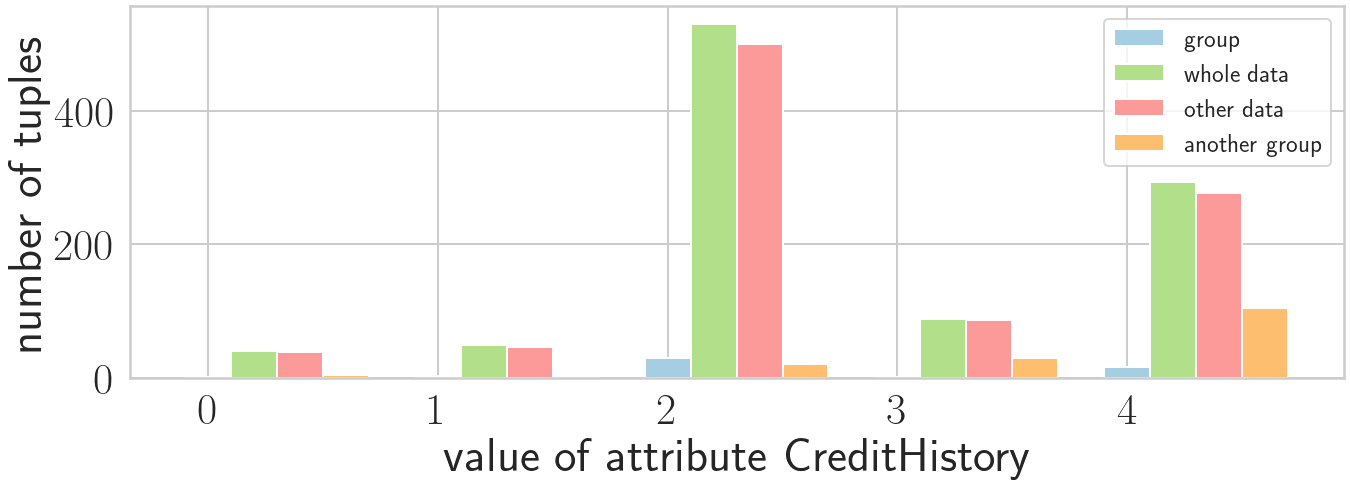

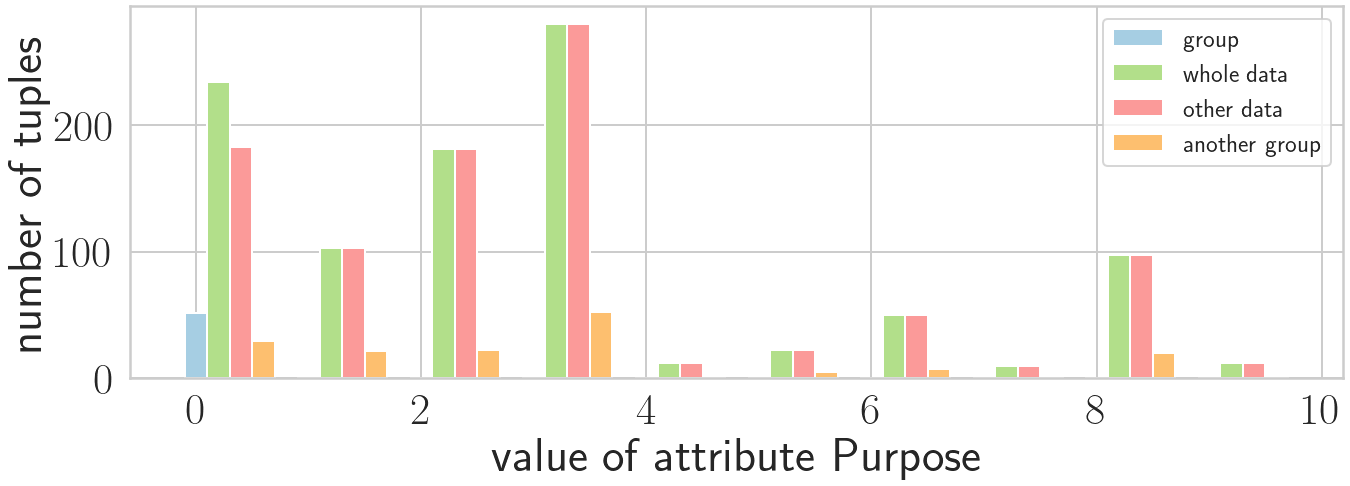

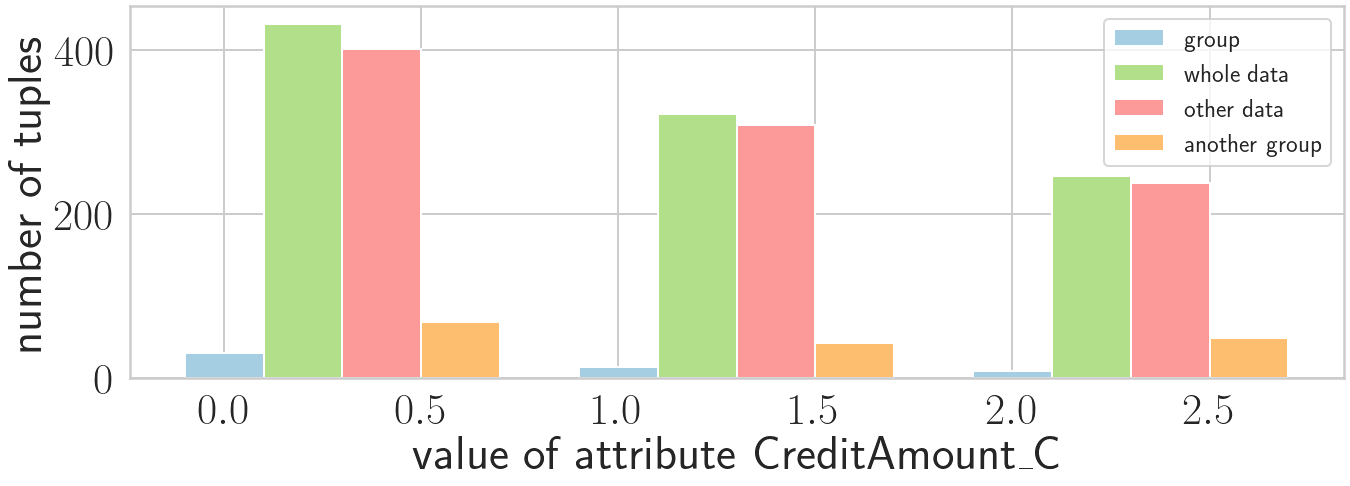

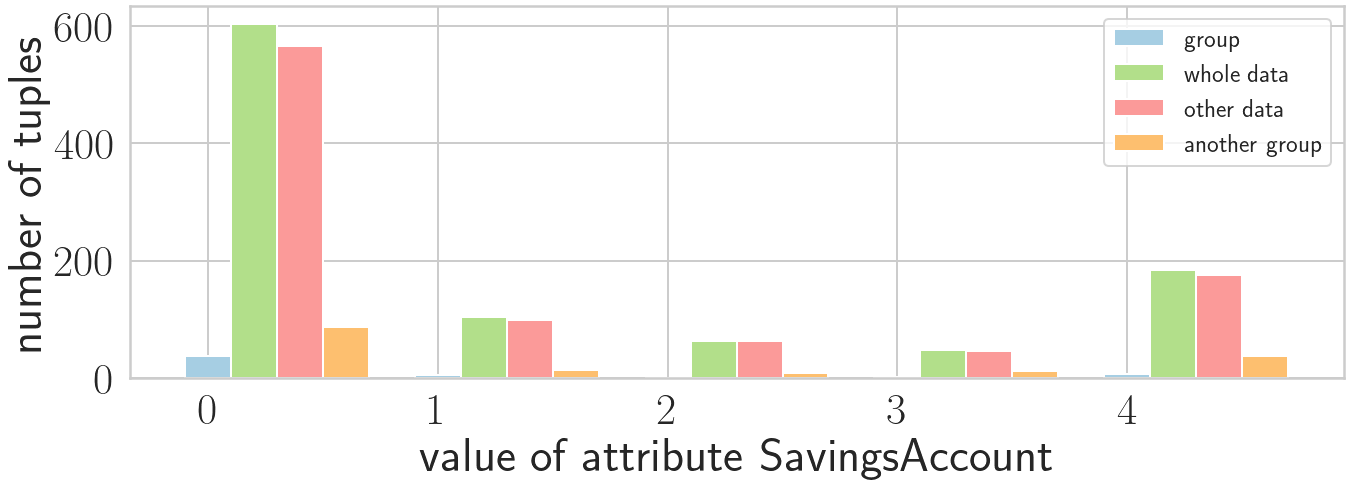

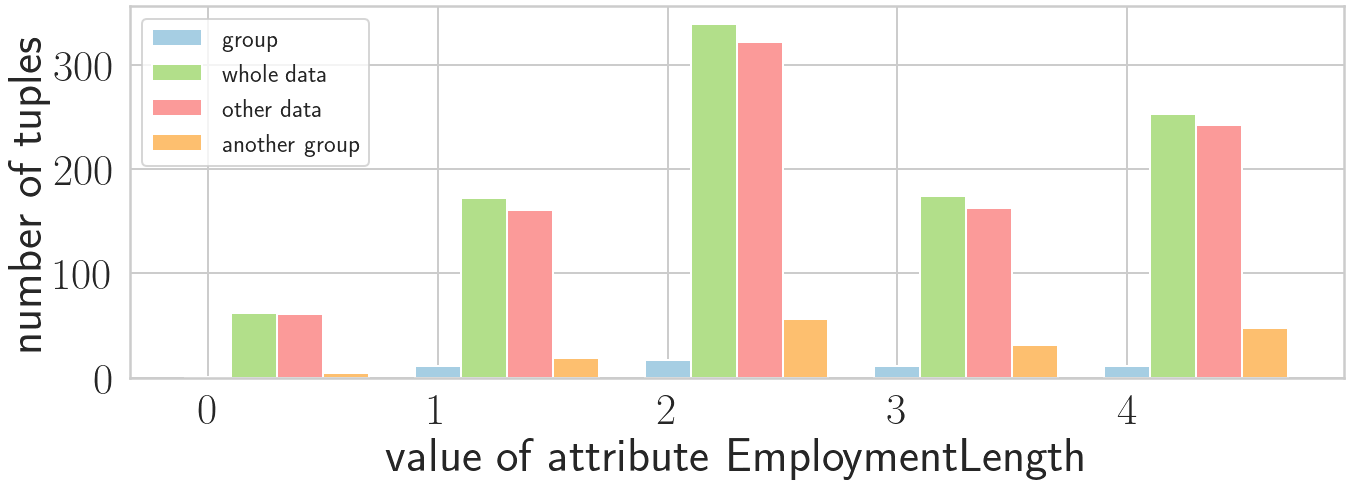

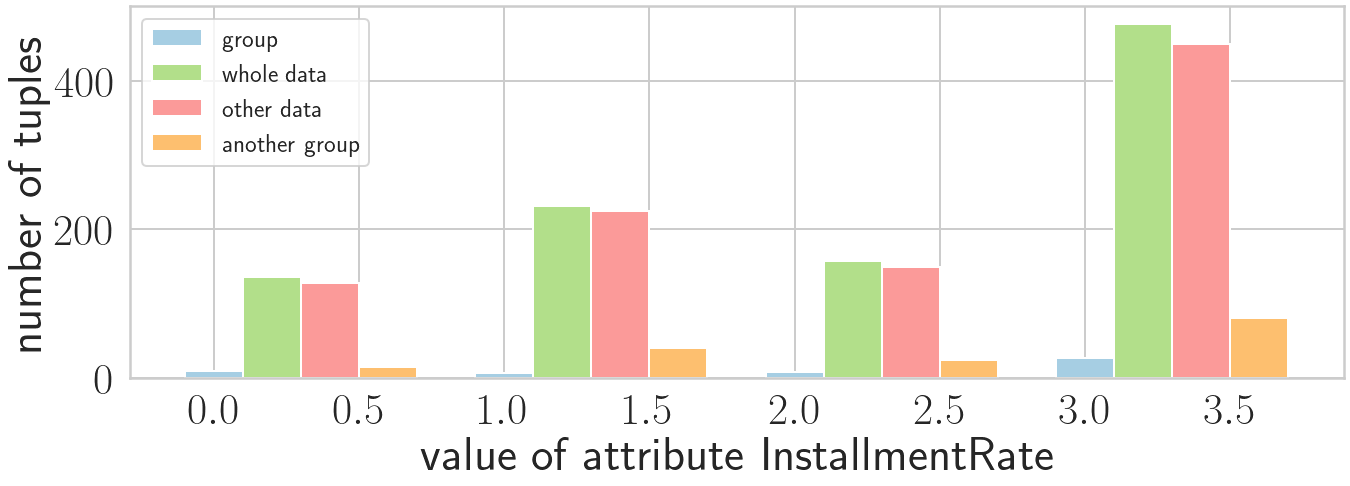

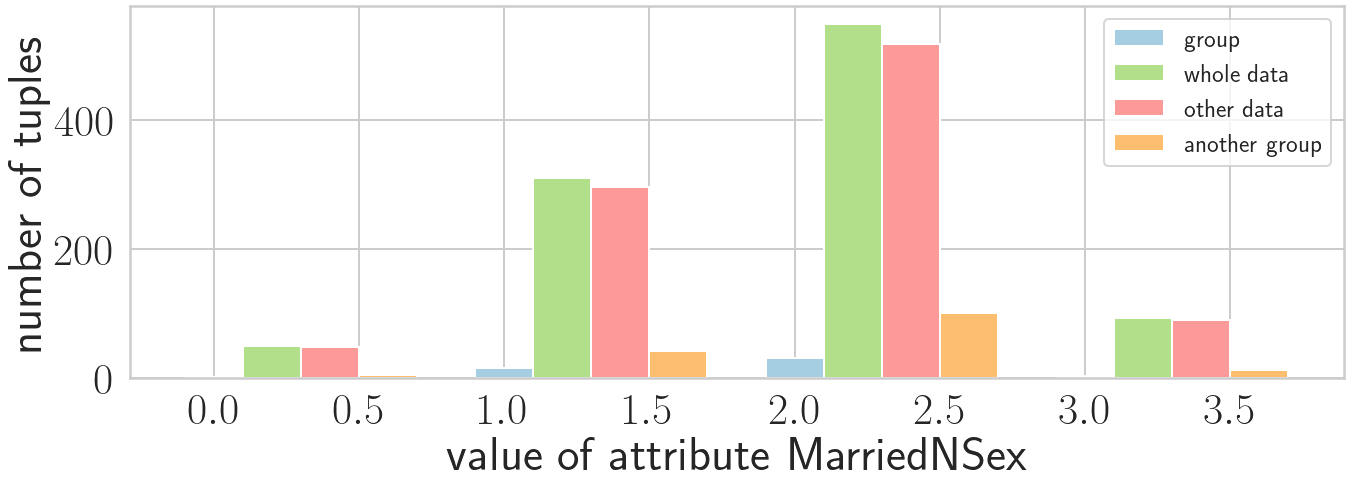

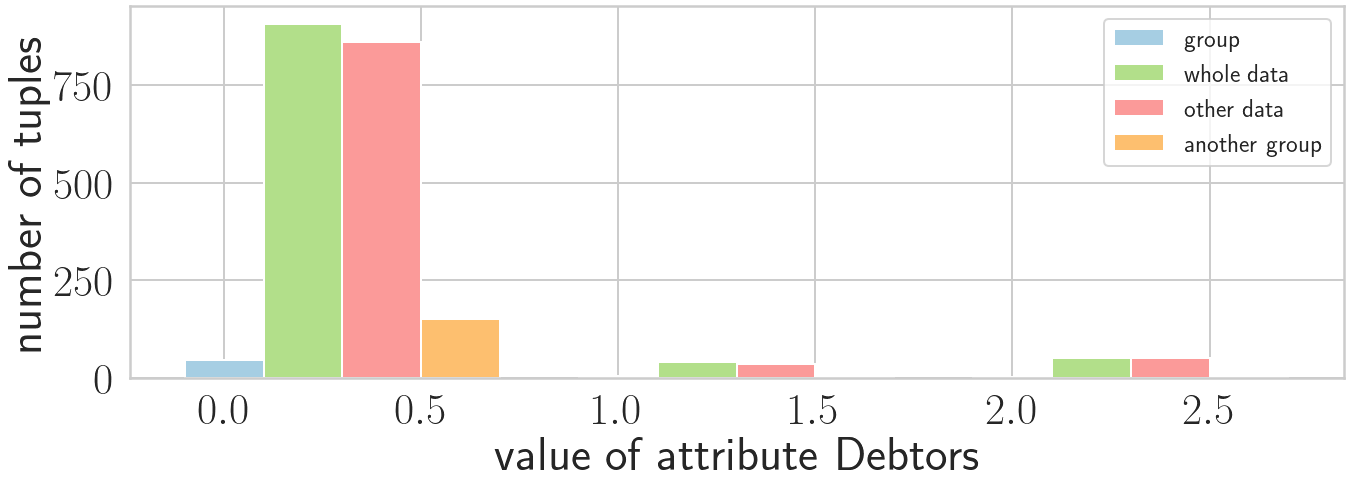

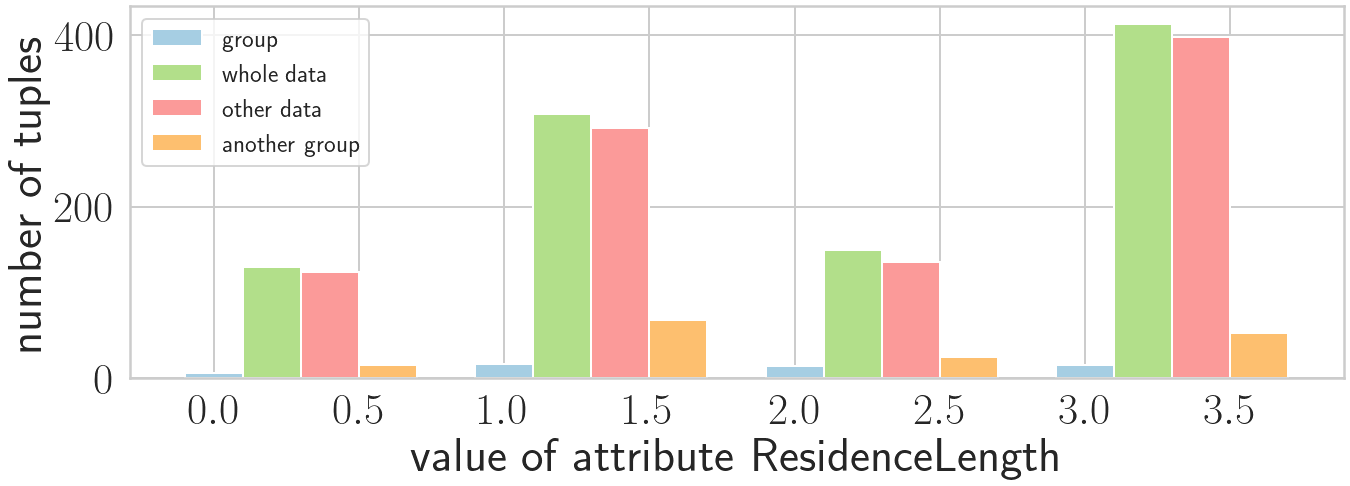

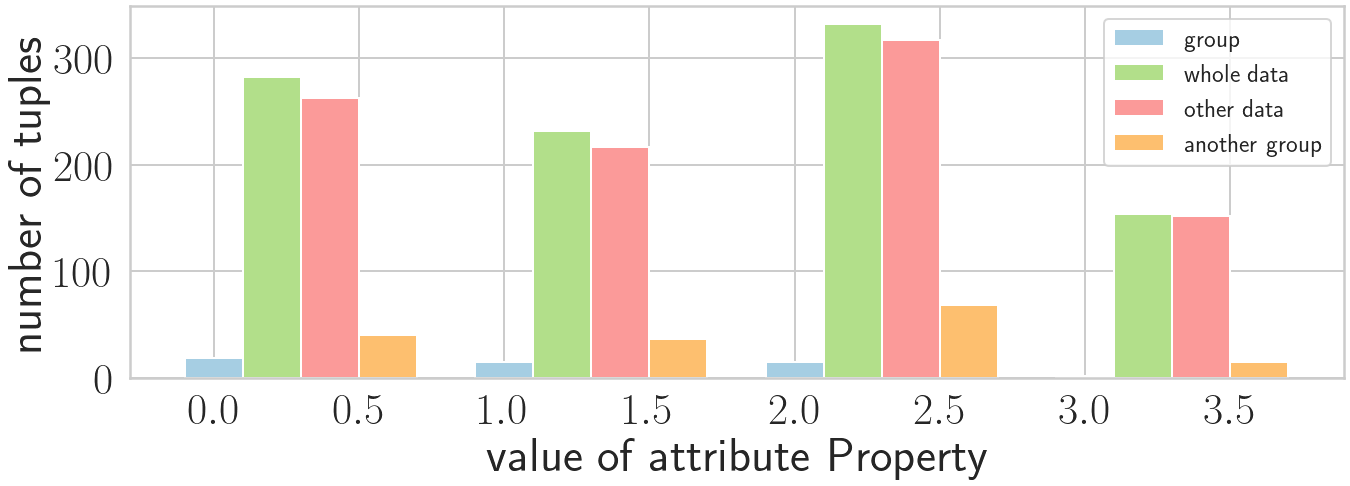

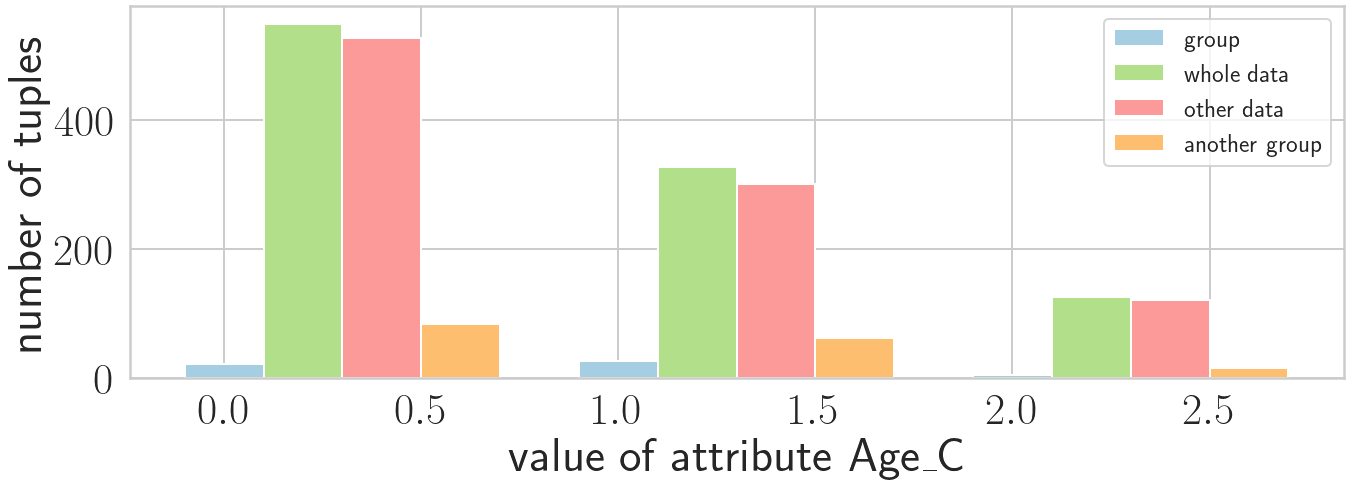

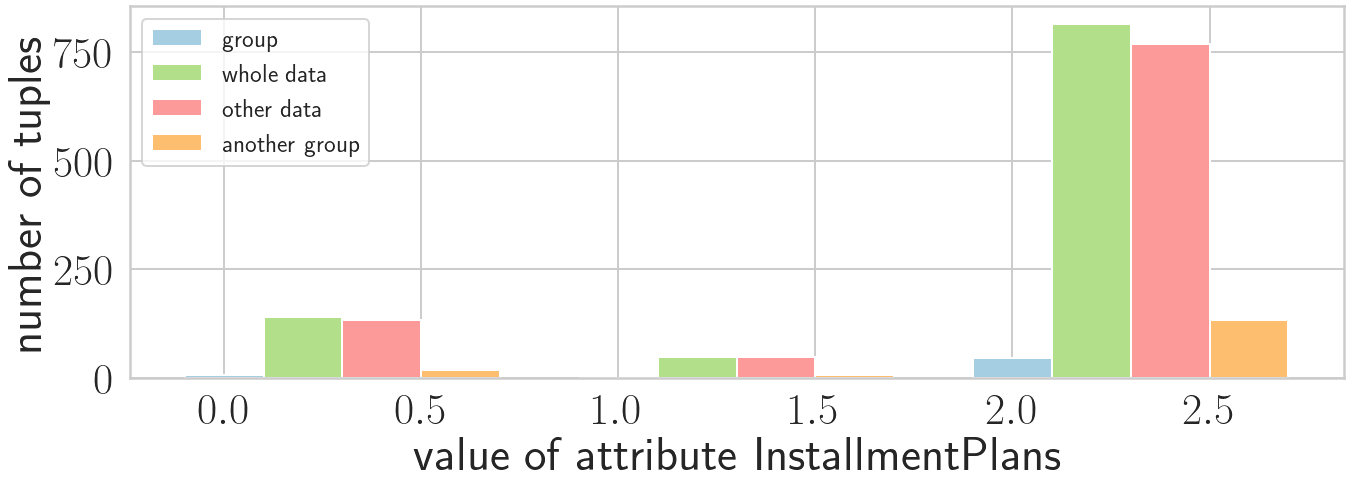

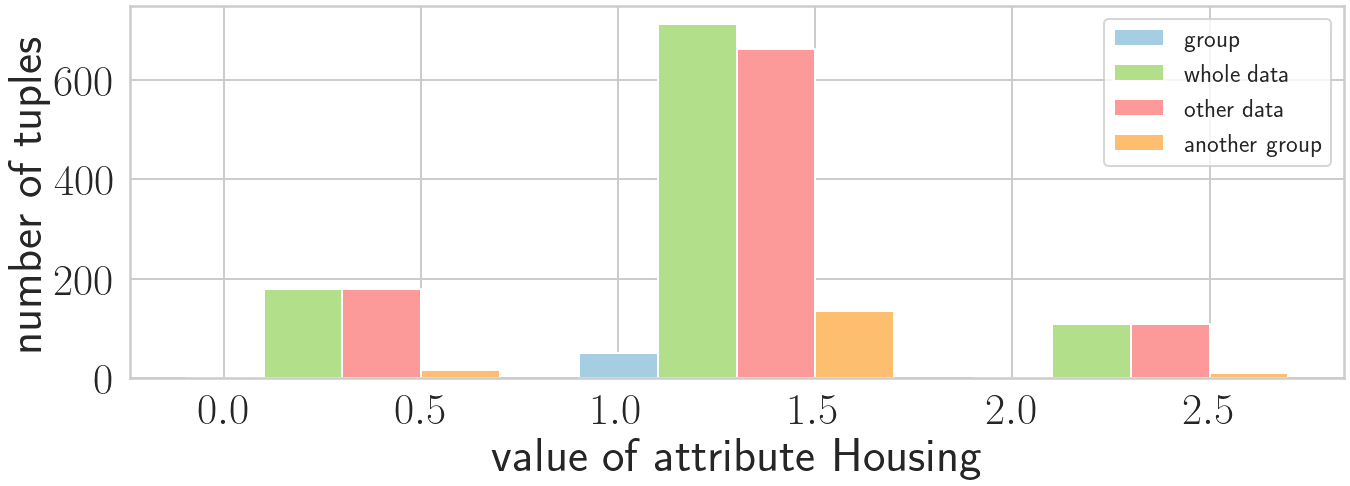

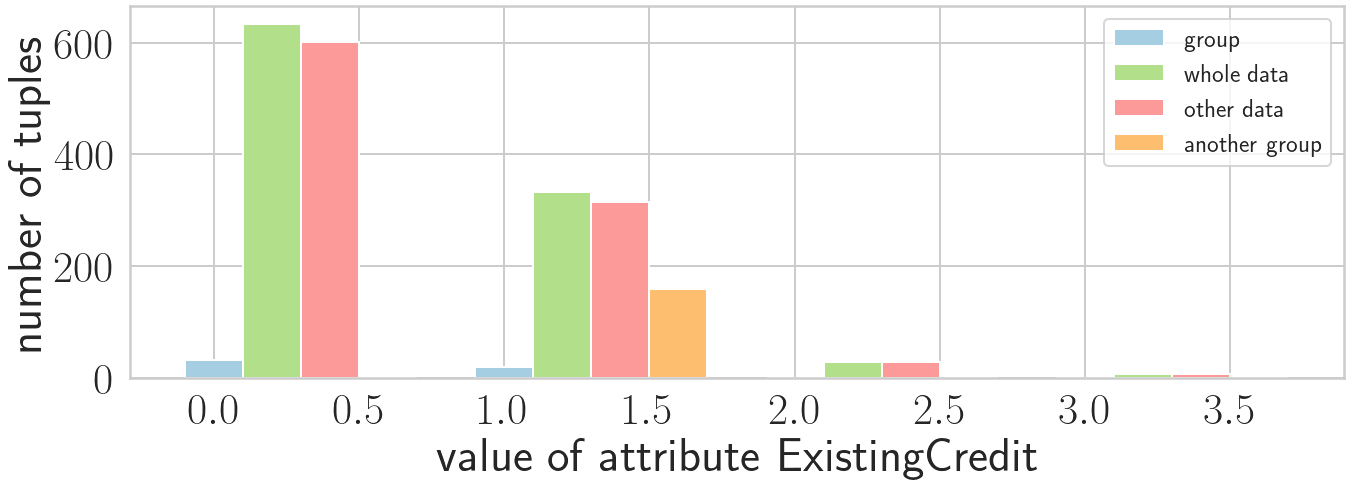

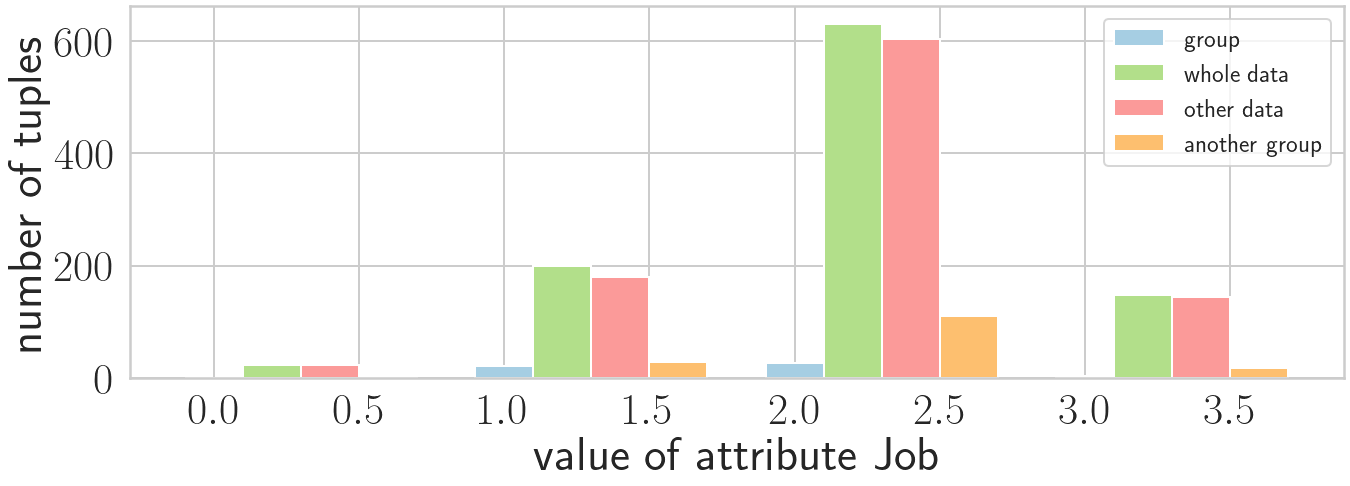

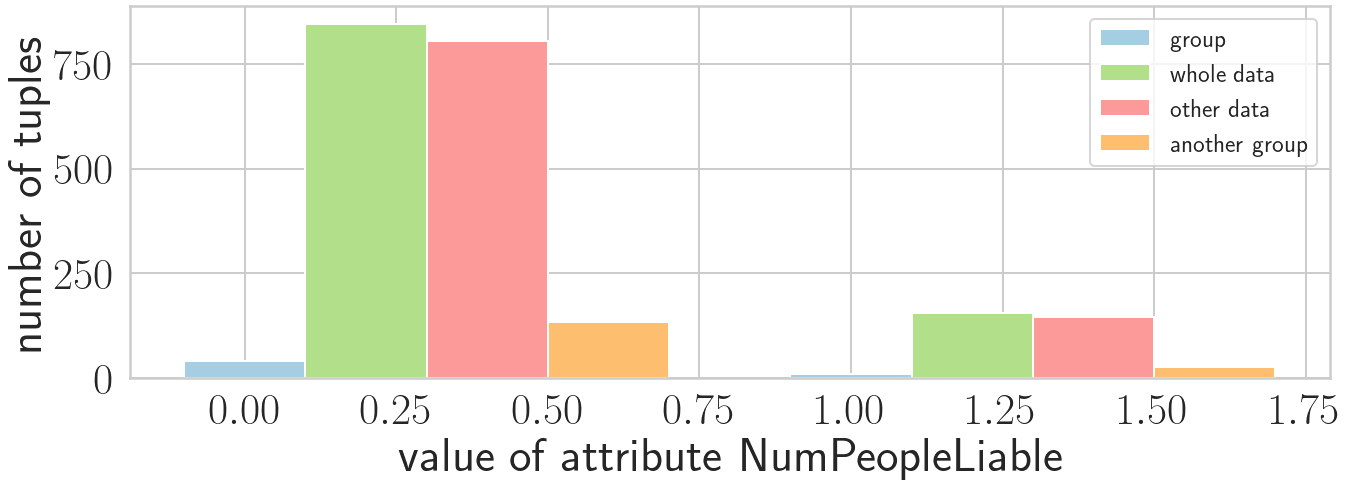

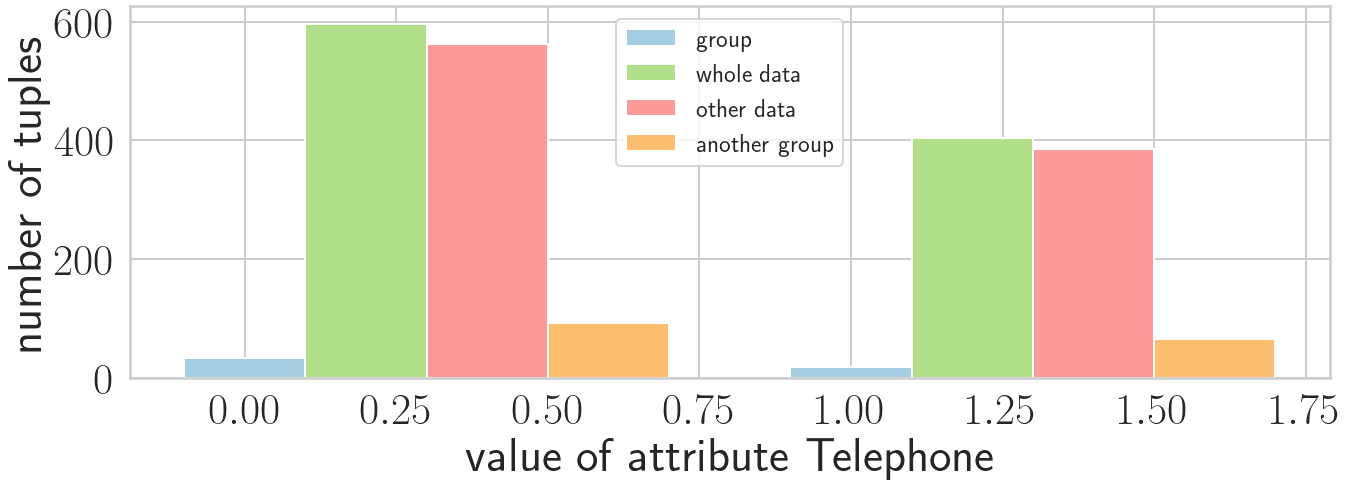

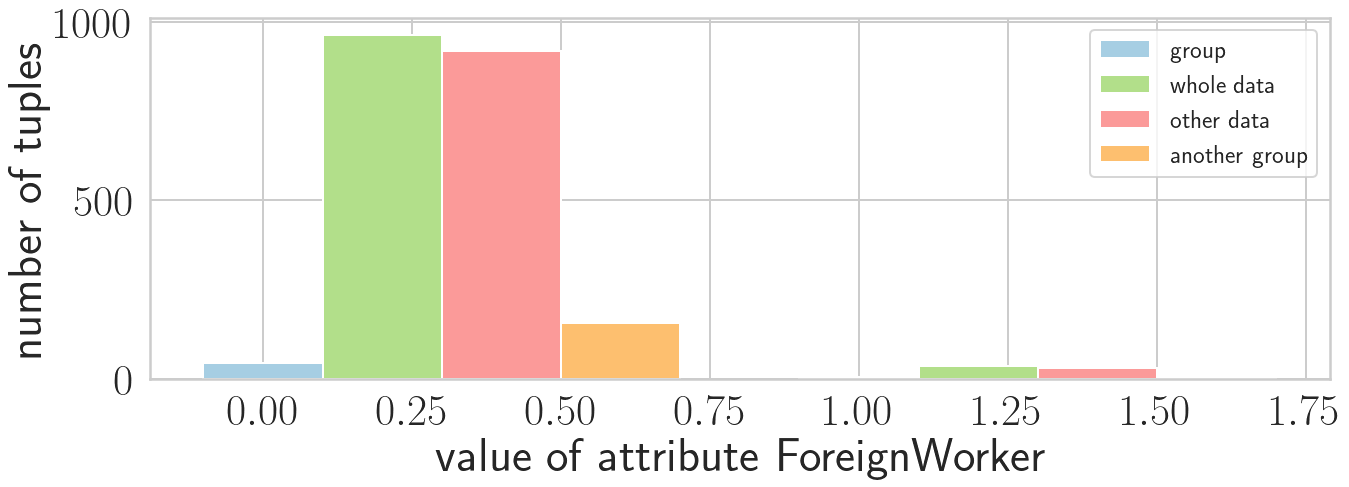

In [197]:
for att in selected_attributes:
    plot_distribution_number(ranked_data, att, groups_prop_bounds[1], another_group, k)

159 7 6.36
True


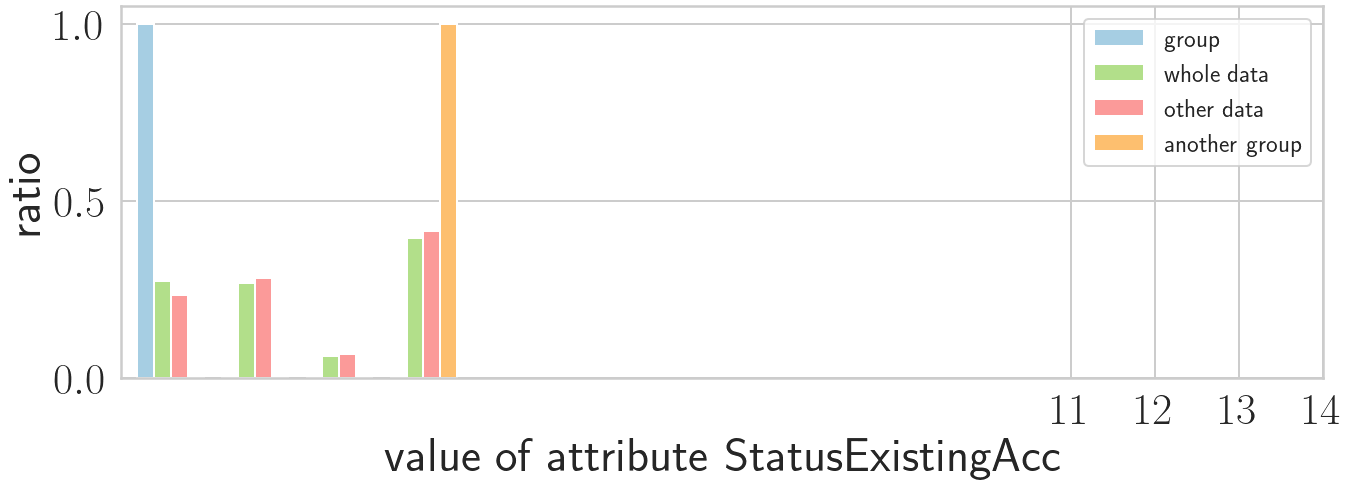

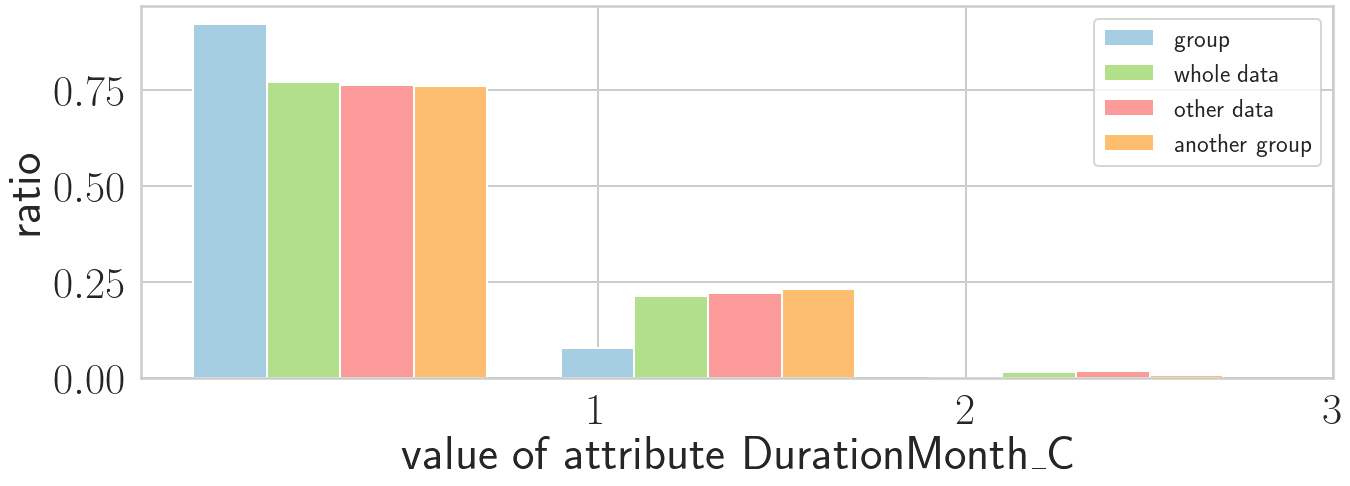

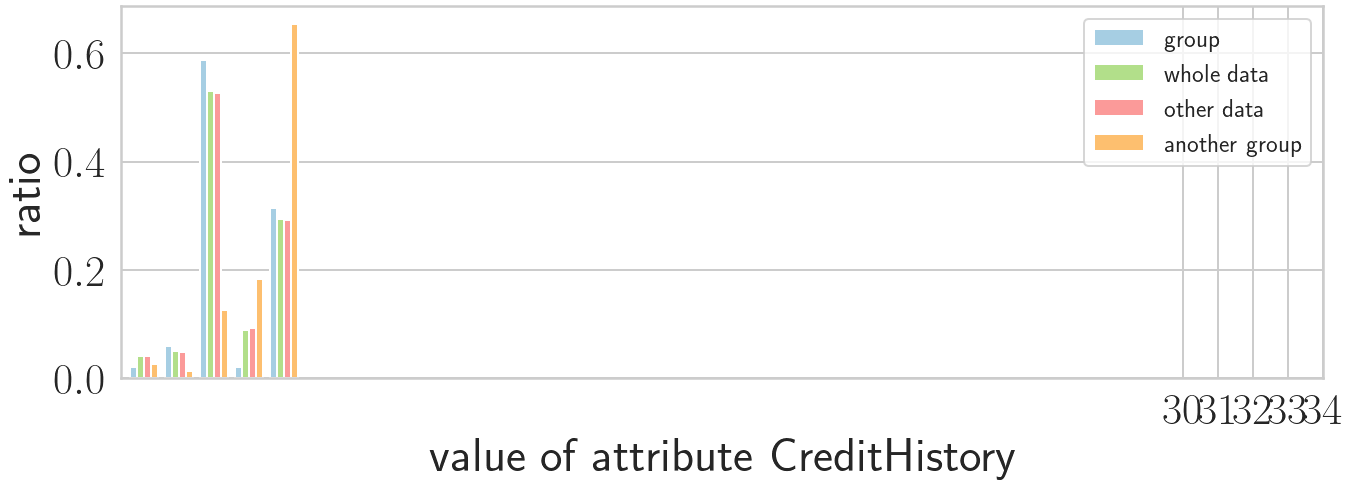

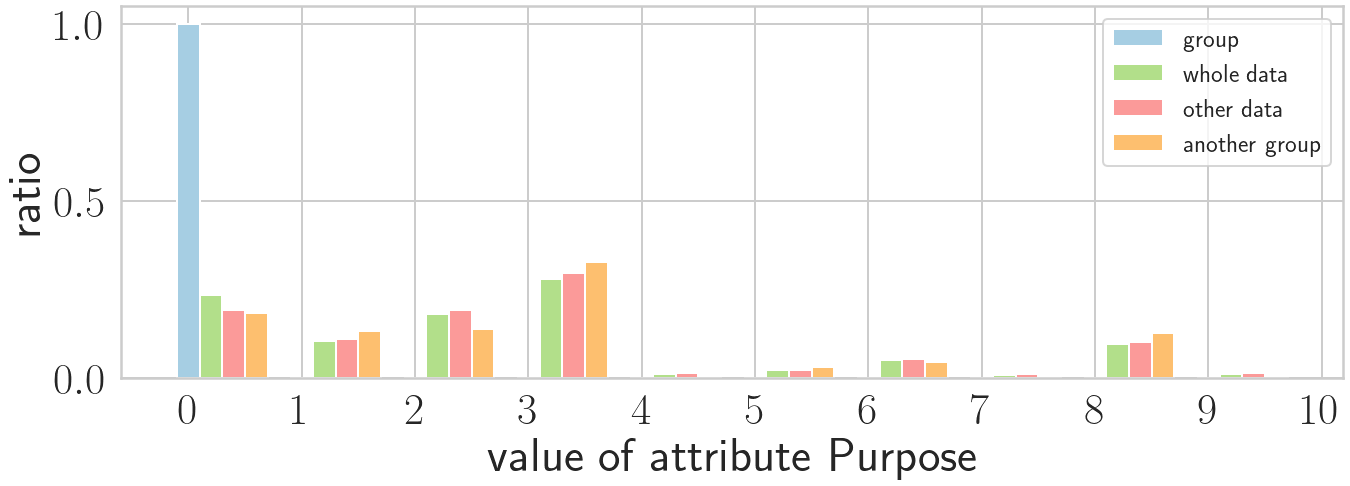

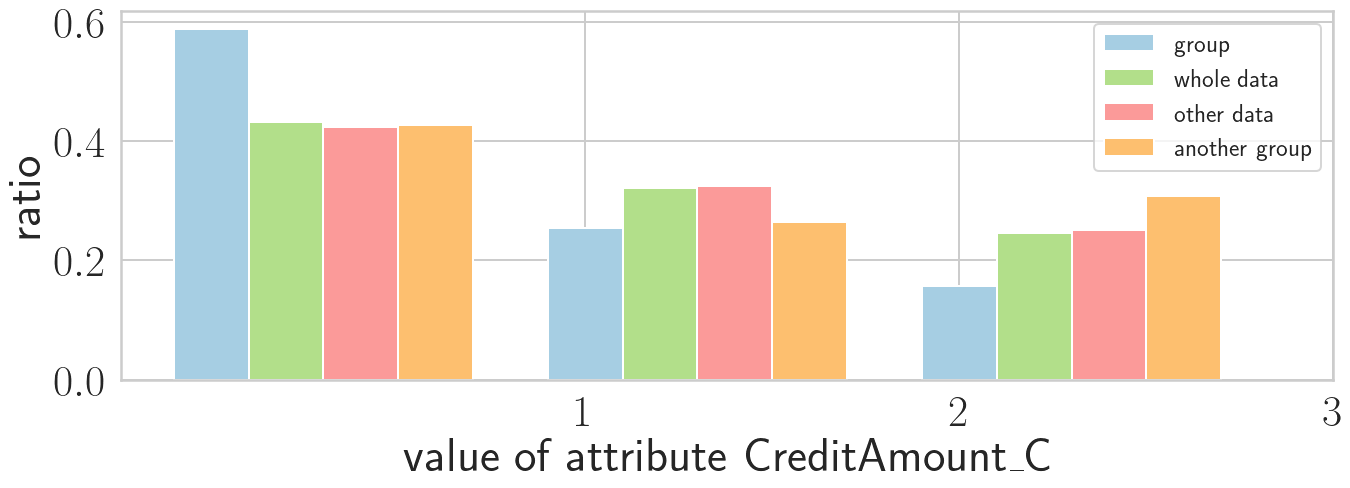

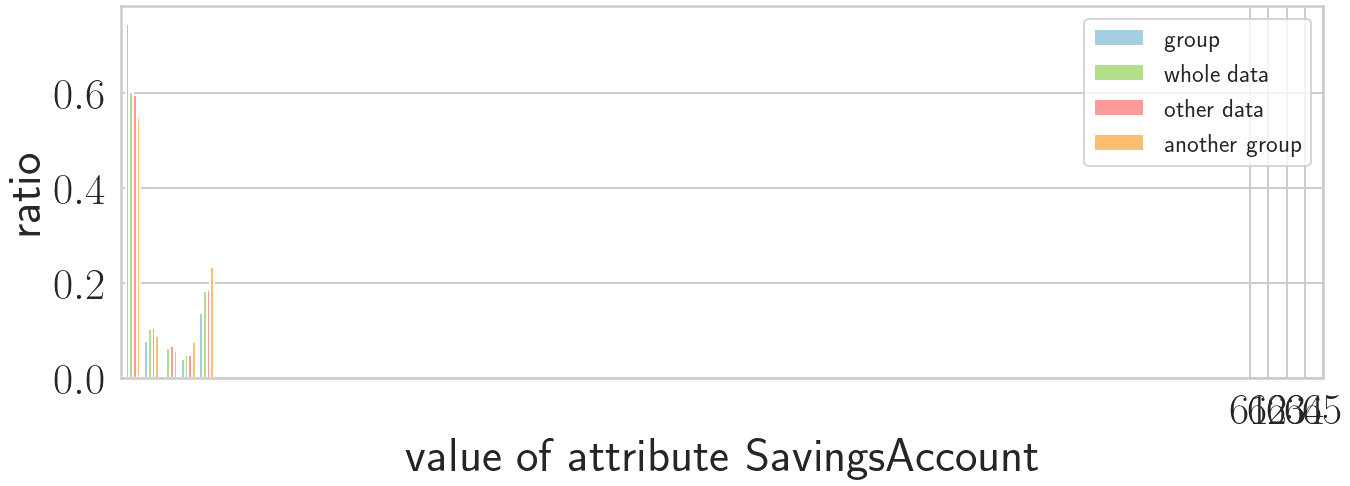

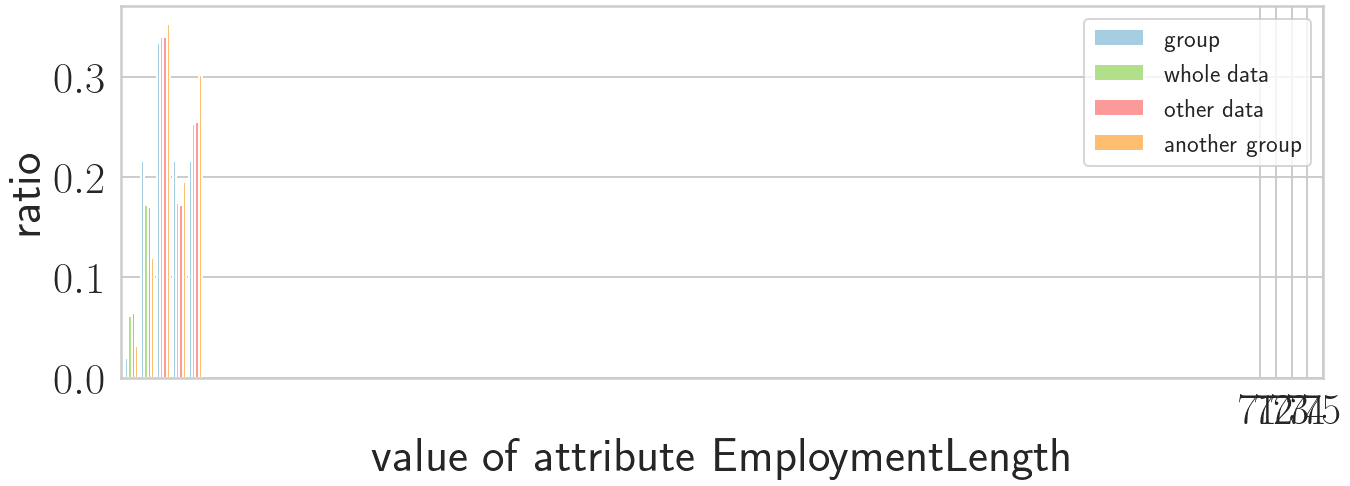

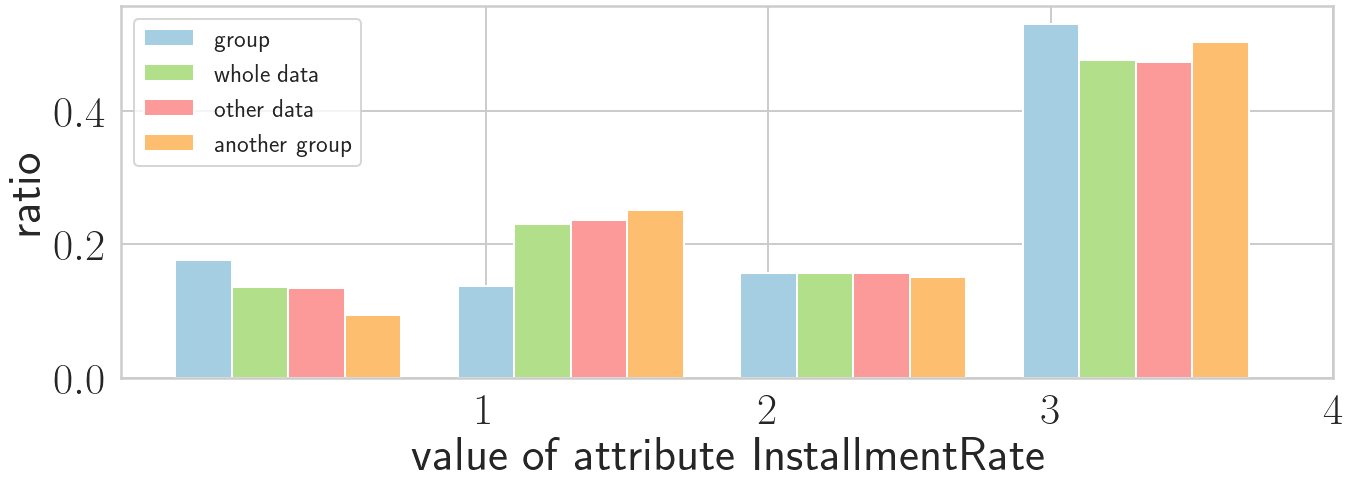

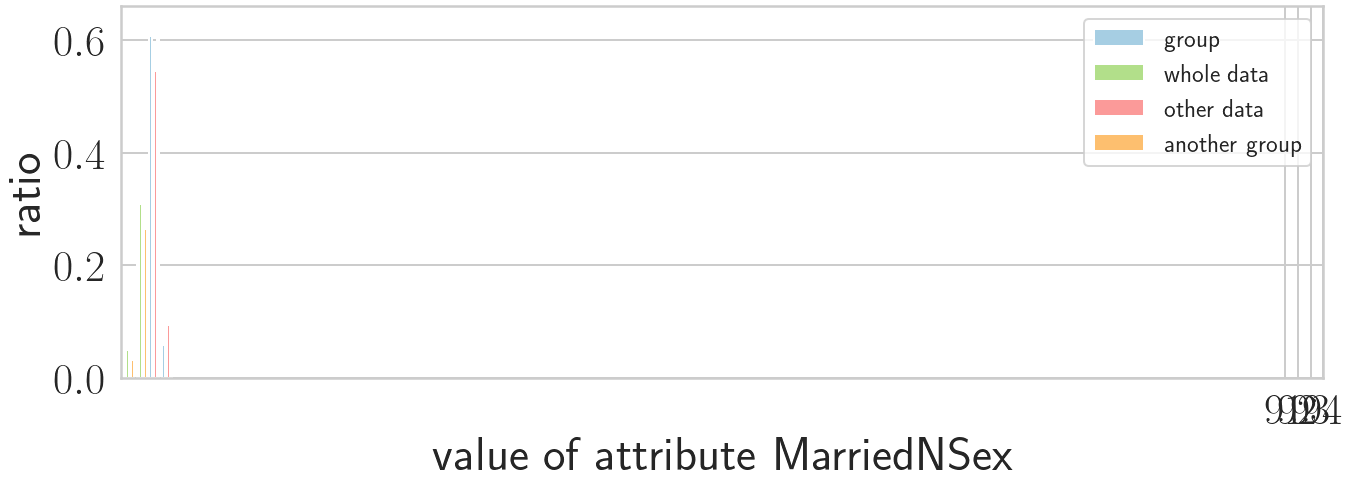

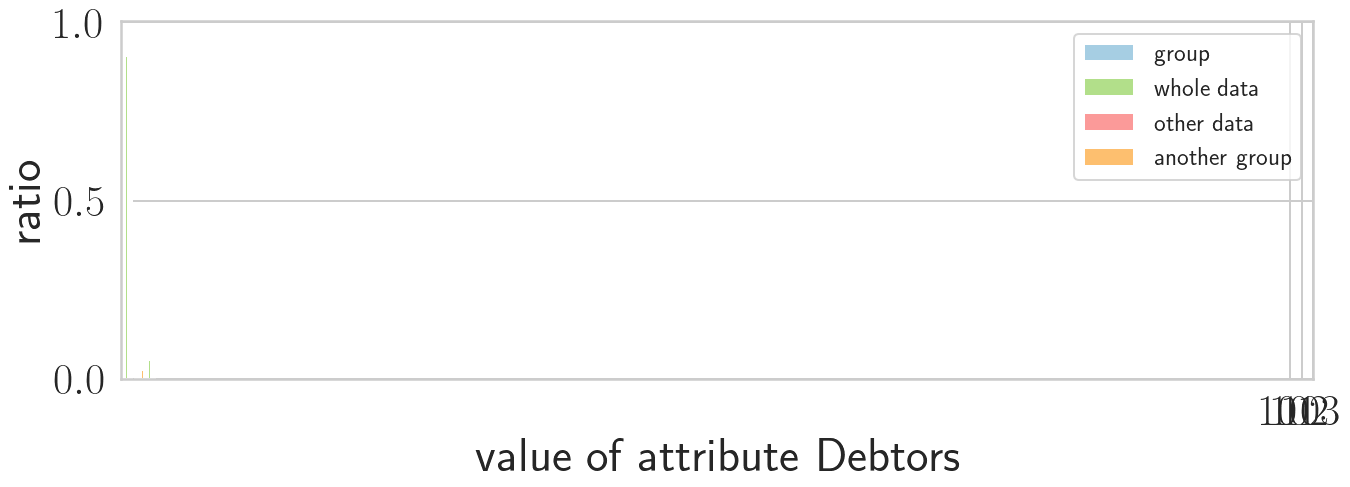

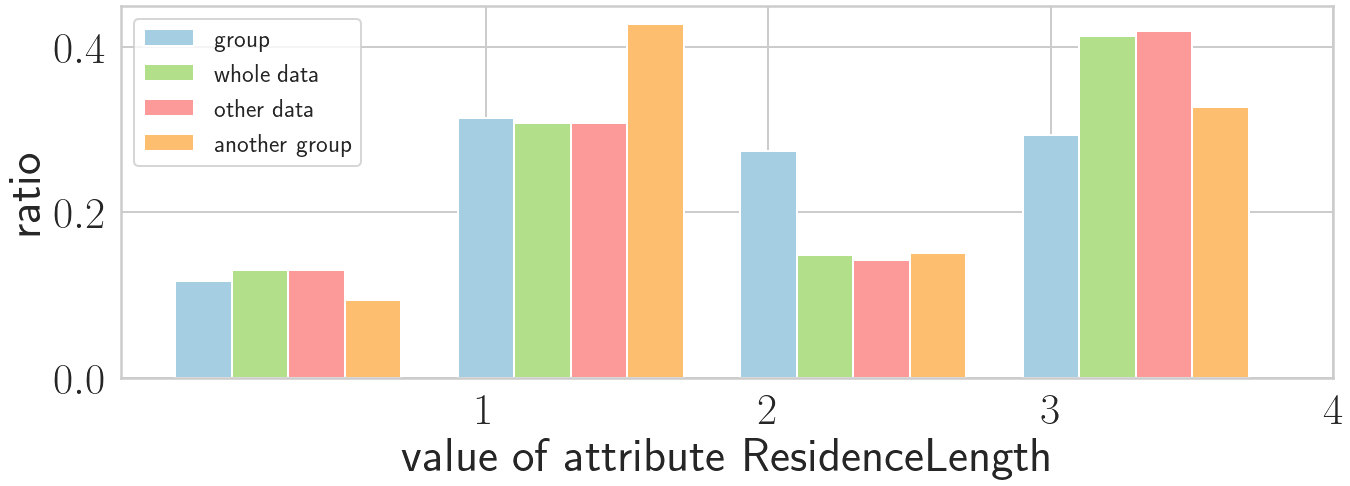

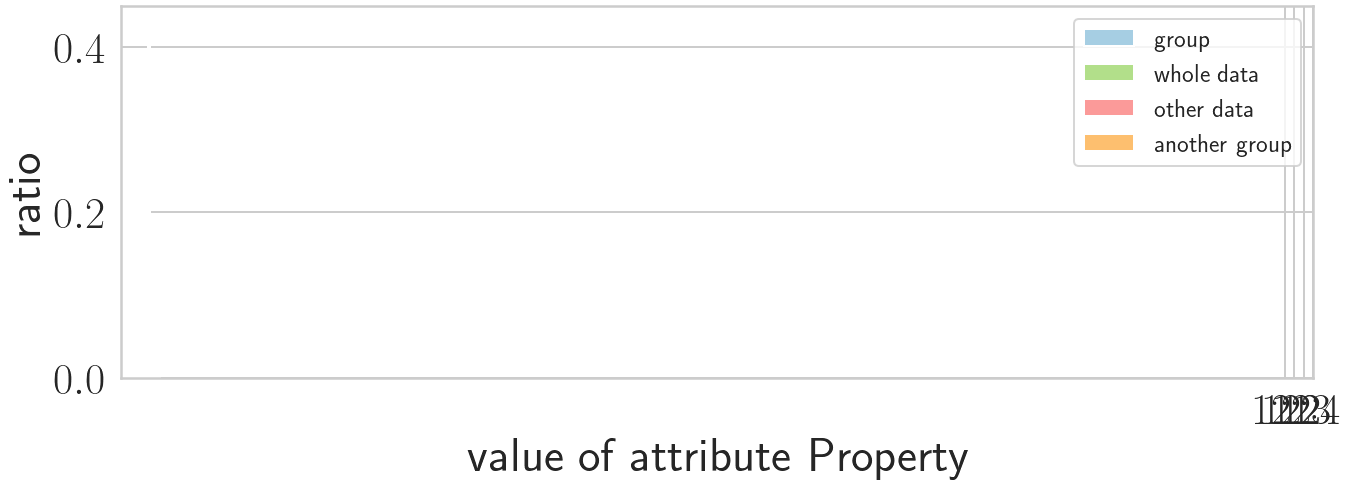

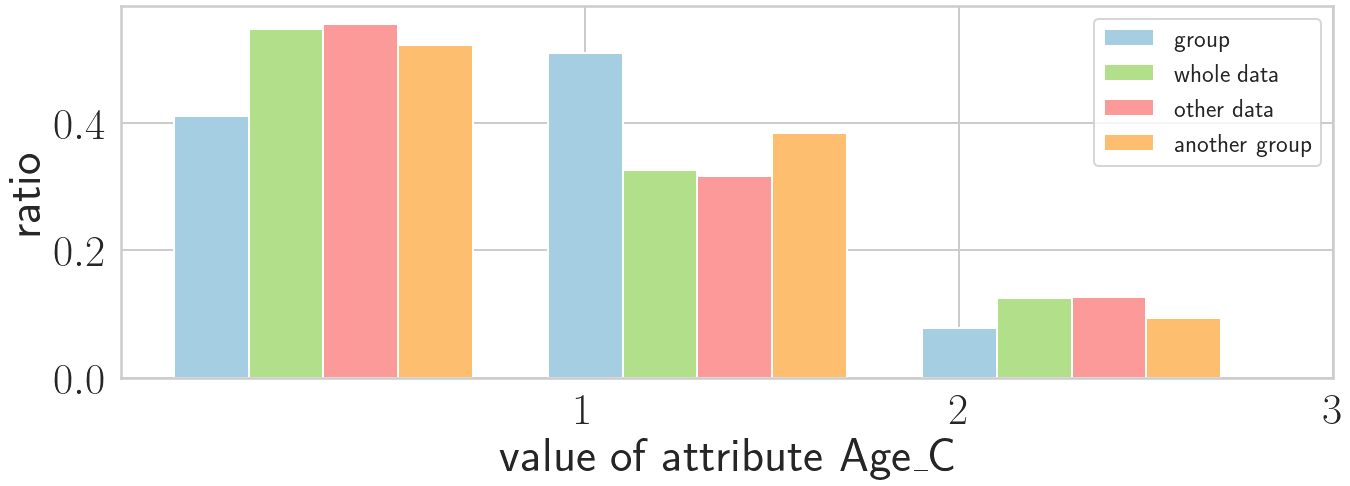

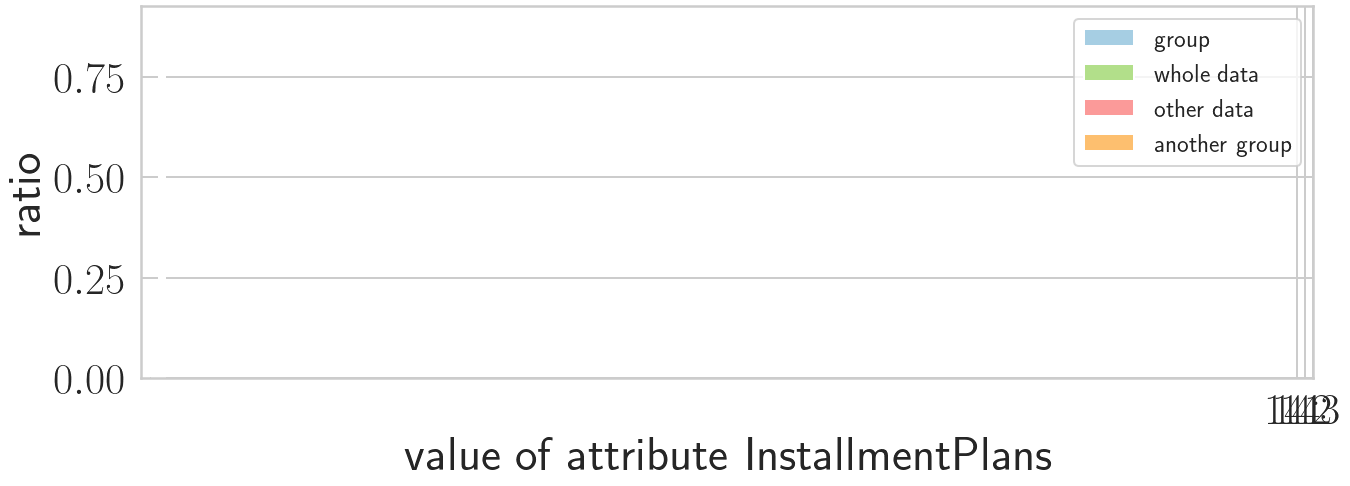

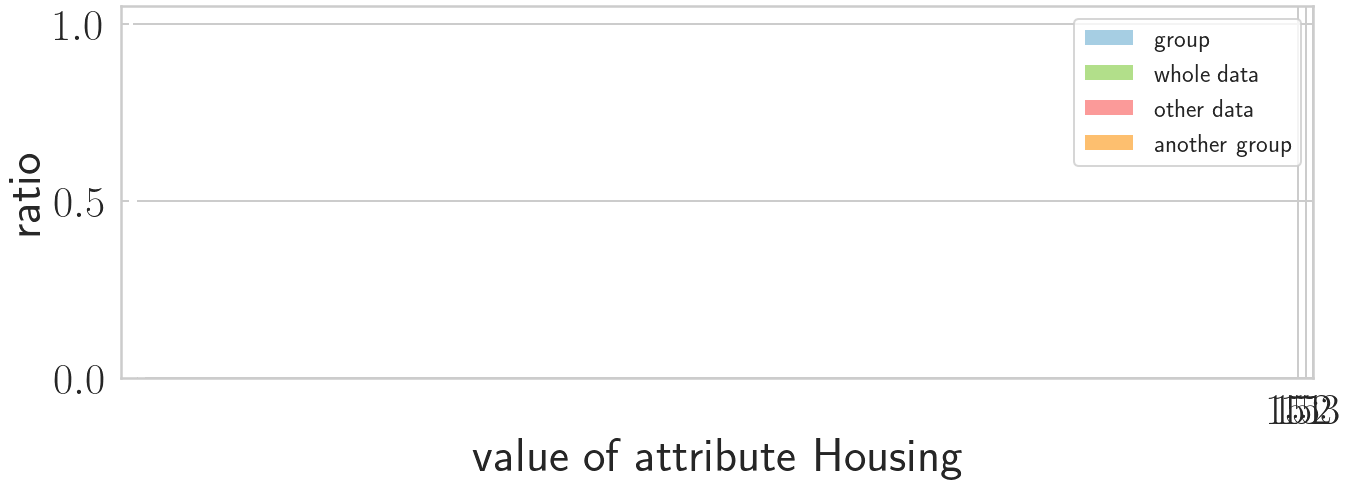

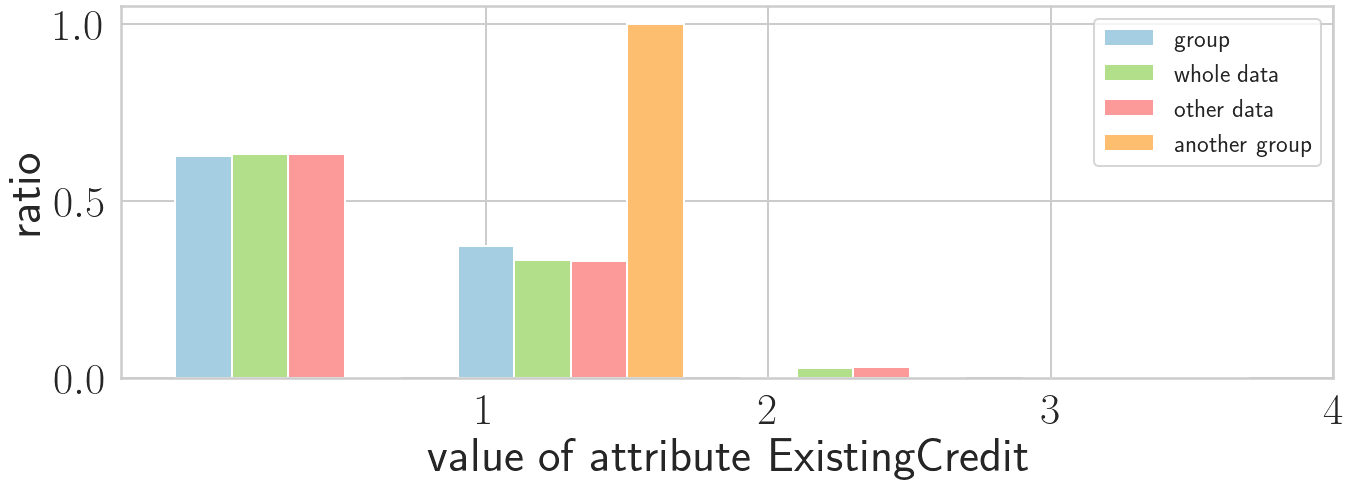

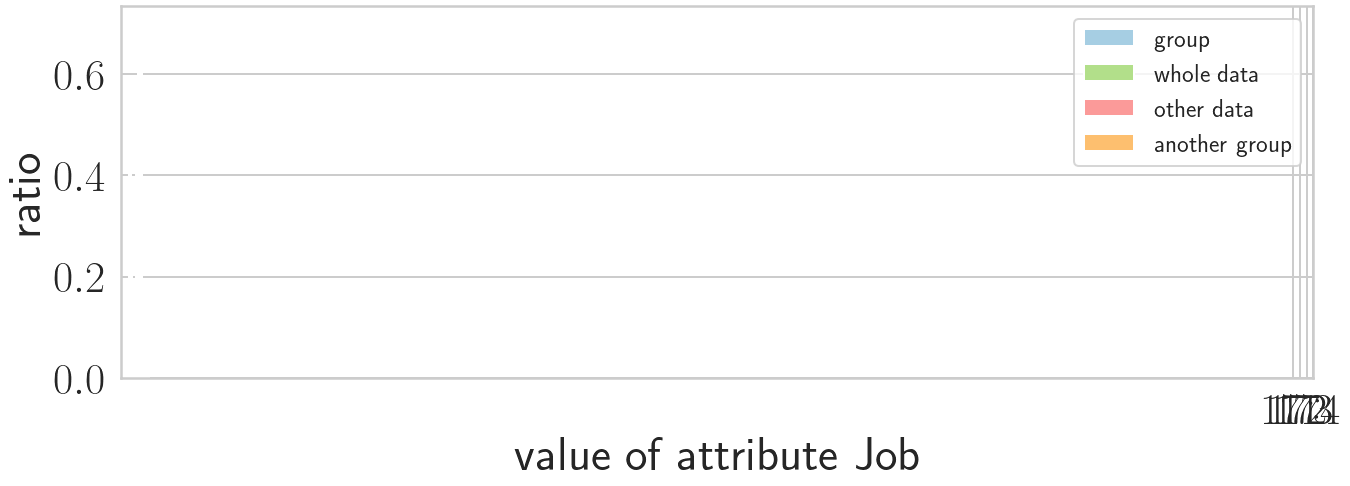

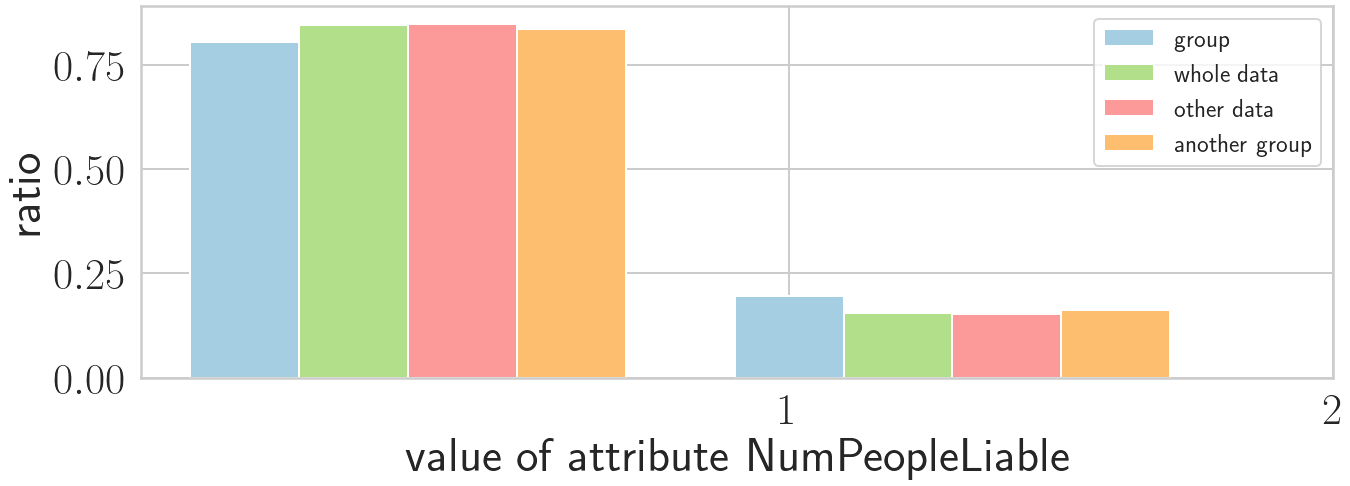

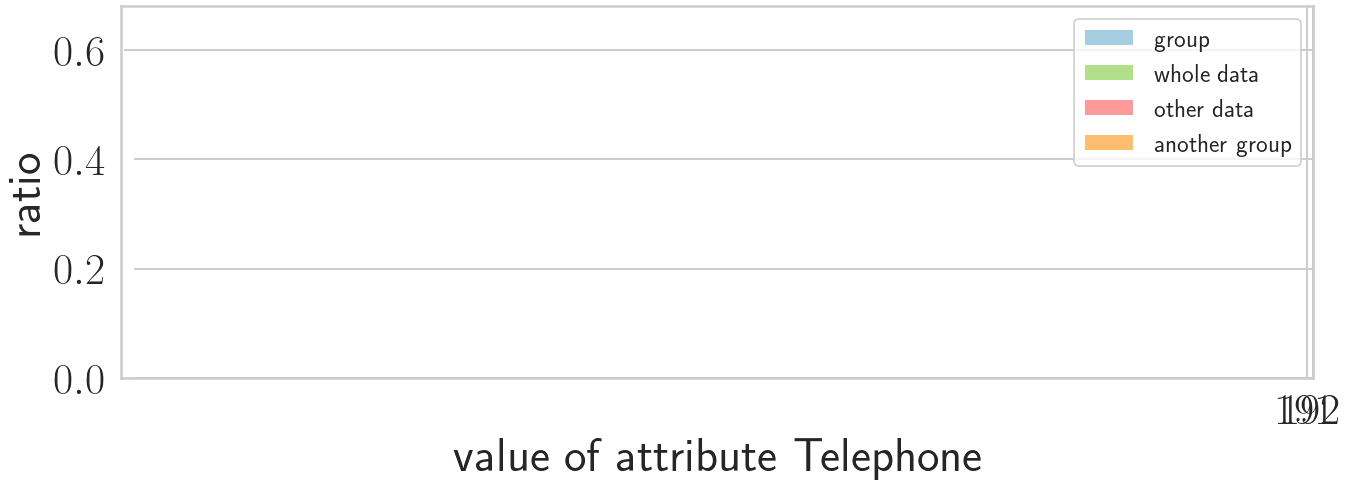

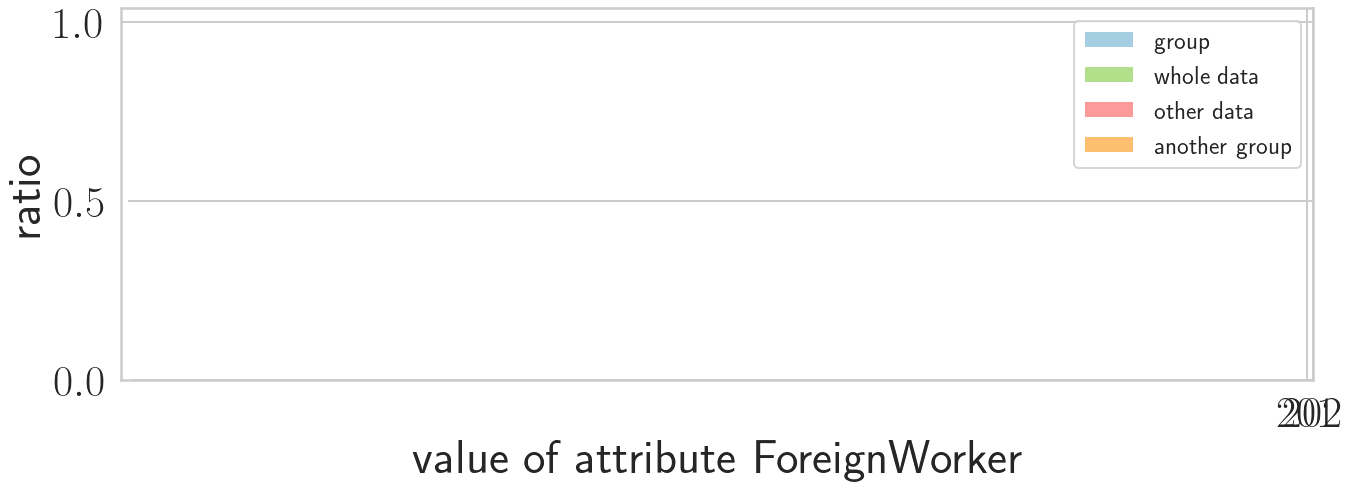

In [198]:
another_group = [14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))

for att in selected_attributes:
    plot_distribution_ratio(ranked_data, att, groups_prop_bounds[1], another_group, k)